#  Wound Infection Detection


### 0

In [1]:
# ============================================================================
# Quick Start: Load Everything Automatically
# ============================================================================
# Run this cell first when opening a new notebook session!

import json
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, List, Tuple
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# PyTorch Vision
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

print("=" * 60)
print("✓ Libraries imported!")

# ============================================================================
# Load CONFIG
# ============================================================================
CONFIG = {
    'num_classes': 17,  # Background + 16 classes
    'batch_size': 2,
    'num_workers': 2,
    'learning_rate': 0.0005,
    'num_epochs': 50,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'checkpoints_dir': '../checkpoints_medical_aug',
}

print("✓ CONFIG loaded!")

# ============================================================================
# Build Model
# ============================================================================
def build_model(num_classes=17):
    """بناء Mask R-CNN model"""
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
    return model

model = build_model(num_classes=CONFIG['num_classes'])
model.to(CONFIG['device'])
print("✓ Model built!")

# ============================================================================
# Load Trained Model (if exists)
# ============================================================================
# Find project root
current_dir = Path.cwd()
project_root = current_dir
for parent in current_dir.parents:
    if (parent / 'README.md').exists() or (parent / 'requirements.txt').exists():
        project_root = parent
        break
project_root = Path(project_root).resolve()

# Resolve checkpoint path
checkpoints_dir = CONFIG['checkpoints_dir']
if checkpoints_dir.startswith('../') or checkpoints_dir.startswith('..\\'):
    checkpoints_dir = checkpoints_dir.replace('../', '').replace('..\\', '')
checkpoints_dir = project_root / checkpoints_dir

# Use checkpoint_epoch_15 instead of best_model.pth (epoch 15 is closer to best val_loss at epoch 11)
model_path = checkpoints_dir / 'checkpoint_epoch_15.pth'

if model_path.exists():
    print(f"✓ Loading trained model from: {model_path}")
    # weights_only=False is needed to load optimizer_state_dict, epoch, val_loss, etc.
    checkpoint = torch.load(model_path, map_location=CONFIG['device'], weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("✓ Trained model loaded successfully!")
    if 'epoch' in checkpoint:
        print(f"  - Epoch: {checkpoint['epoch']}")
    if 'val_loss' in checkpoint:
        print(f"  - Val Loss: {checkpoint['val_loss']:.4f}")
else:
    print(f"⚠️  No trained model found at: {model_path}")
    print("   Run Part 6 (Training) to train a model first.")

print("=" * 60)
print("✅ Quick Start Complete! You can now use the model for prediction.")
print("=" * 60)


✓ Libraries imported!
✓ CONFIG loaded!


e:\GitHub\Wound-infection-detection-model\.venv_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\GitHub\Wound-infection-detection-model\.venv_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model built!
⚠️  No trained model found at: E:\GitHub\Wound-infection-detection-model\checkpoints_medical_aug\checkpoint_epoch_15.pth
   Run Part 6 (Training) to train a model first.
✅ Quick Start Complete! You can now use the model for prediction.


## 📦 Part 1: Import Libraries


In [2]:
# ============================================================================
# Import all required libraries
# ============================================================================

try:
    import json
    import cv2
    import numpy as np
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    from pathlib import Path
    from typing import Dict, List, Tuple
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    from tqdm import tqdm
    import random
    import yaml
    import matplotlib.pyplot as plt
    
    # PyTorch Vision
    import torchvision
    from torchvision.models.detection import maskrcnn_resnet50_fpn
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
    
    print("=" * 60)
    print("✓ All libraries imported successfully!")
    print("=" * 60)
    print(f"PyTorch: {torch.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"CUDA: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Device: {torch.cuda.get_device_name(0)}")
    print("=" * 60)
    
except ValueError as e:
    if "numpy.dtype size changed" in str(e):
        print("=" * 60)
        print("❌ خطأ: تعارض بين numpy و scipy")
        print("=" * 60)
        print("\n🔧 الحل:")
        print("   1. شغّل هذه الأوامر في Terminal:")
        print("      pip install --upgrade --force-reinstall numpy scipy")
        print("   2. أو شغّل Part 0 مرة أخرى")
        print("   3. أعد تشغيل Kernel: Kernel → Restart")
        print("=" * 60)
        raise
    else:
        raise
        
except ImportError as e:
    print("=" * 60)
    print("❌ خطأ في استيراد المكتبات!")
    print("=" * 60)
    print(f"الخطأ: {e}")
    print("\n🔧 الحل:")
    print("   1. شغّل Part 0 أولاً (تثبيت المكتبات)")
    print("   2. أعد تشغيل Kernel: Kernel → Restart")
    print("=" * 60)
    raise


✓ All libraries imported successfully!
PyTorch: 2.5.1+cu121
NumPy: 2.3.5
CUDA: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU


## ⚙️ Part 2: Configuration


In [3]:
# ============================================================================
# تثبيت المكتبات المطلوبة
# ============================================================================

import sys
import subprocess

def install_package(package):
    """تثبيت مكتبة واحدة مع معالجة الأخطاء"""
    try:
        print(f"  📦 {package}...", end=" ", flush=True)
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", package],
            capture_output=True,
            text=True,
            check=False
        )
        if result.returncode == 0:
            print("✓")
            return True
        else:
            print("⚠️ (فشل - قد تكون موجودة بالفعل)")
            return False
    except Exception as e:
        print(f"❌ خطأ: {e}")
        return False

print("=" * 60)
print("📦 تثبيت المكتبات...")
print("=" * 60)

# تثبيت setuptools و wheel أولاً (مهم لـ Python 3.13)
print("\n[1/3] تثبيت setuptools و wheel...")
install_package("setuptools")
install_package("wheel")

# تثبيت numpy و scipy (إصدارات تدعم Python 3.13)
print("\n[2/3] تثبيت numpy و scipy...")
install_package("numpy>=1.26.0")
install_package("scipy>=1.11.0")

# تثبيت باقي المكتبات (واحدة تلو الأخرى)
print("\n[3/3] تثبيت باقي المكتبات...")
packages = [
    "torch", "torchvision",
    "opencv-python", "Pillow", "albumentations",
    "pandas", "matplotlib", "seaborn",
    "tqdm", "scikit-learn", "pycocotools",
    "pyyaml", "jupyter", "ipywidgets"
]

for package in packages:
    install_package(package)

print("\n" + "=" * 60)
print("✓ تم التثبيت!")
print("=" * 60)
print("⚠️ أعد تشغيل Kernel: Kernel → Restart")
print("=" * 60)



# ============================================================================
# Configuration - يمكنك تعديل هذه القيم
# ============================================================================

import platform

CONFIG = {
    # Data - مسارات نسبية من notebooks/ إلى project root
    'data_root': '../data',  # مجلد البيانات الأصلية (للتحقق validation)
    # ملاحظة: البيانات المعززة تُستخدم للتدريب (../data/augmented/)
    'image_size': [1024, 1024],
    'num_classes': 17,  # 16 wound types + background
    'batch_size': 2,
    # على Windows، استخدم num_workers=0 لتجنب مشاكل multiprocessing
    'num_workers': 0 if platform.system() == 'Windows' else 4,
    
    # Training
    'epochs': 50,
    'learning_rate': 0.0005,  # Reduced from 0.001 to prevent NaN loss
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Early stopping
    'early_stop_patience': 7,
    'early_stop_min_delta': 0.001,
    
    # Training stability
    'loss_clip_max': 100.0,
    'loss_skip_threshold': 1000.0,
    'skip_invalid_targets': True,
    
    # Splits
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    
    # Paths - مسارات نسبية من notebooks/ إلى project root
    'checkpoints_dir': '../checkpoints_medical_aug',  # مجلد checkpoints في الجذر
    'results_dir': '../results',  # مجلد results في الجذر
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print(f"\n✓ Device: {CONFIG['device']}")


📦 تثبيت المكتبات...

[1/3] تثبيت setuptools و wheel...
  📦 setuptools... ✓
  📦 wheel... ✓

[2/3] تثبيت numpy و scipy...
  📦 numpy>=1.26.0... ✓
  📦 scipy>=1.11.0... ✓

[3/3] تثبيت باقي المكتبات...
  📦 torch... ✓
  📦 torchvision... ✓
  📦 opencv-python... ✓
  📦 Pillow... ✓
  📦 albumentations... ✓
  📦 pandas... ✓
  📦 matplotlib... ✓
  📦 seaborn... ✓
  📦 tqdm... ✓
  📦 scikit-learn... ✓
  📦 pycocotools... ✓
  📦 pyyaml... ✓
  📦 jupyter... ✓
  📦 ipywidgets... ✓

✓ تم التثبيت!
⚠️ أعد تشغيل Kernel: Kernel → Restart
Configuration:
  data_root: ../data
  image_size: [1024, 1024]
  num_classes: 17
  batch_size: 2
  num_workers: 0
  epochs: 50
  learning_rate: 0.0005
  device: cuda
  early_stop_patience: 7
  early_stop_min_delta: 0.001
  loss_clip_max: 100.0
  loss_skip_threshold: 1000.0
  skip_invalid_targets: True
  train_ratio: 0.7
  val_ratio: 0.15
  test_ratio: 0.15
  checkpoints_dir: ../checkpoints_medical_aug
  results_dir: ../results

✓ Device: cuda


## 📊 Part 3: Data Processing


In [4]:
# ============================================================================
# 3.1 CVAT to COCO Converter
# ============================================================================

def convert_cvat_to_coco(data_root: str, output_file: str):
    """تحويل تعليقات CVAT إلى صيغة COCO"""
    
    # Convert to absolute path - handle relative paths correctly
    current_dir = Path.cwd()
    data_root = Path(data_root)
    
    # Handle relative paths - notebook is in notebooks/ directory
    if not data_root.is_absolute():
        # If path starts with ../, it's already relative to parent
        if str(data_root).startswith('../'):
            data_root = current_dir.parent / data_root
        # If path is relative and we're in notebooks/, go up one level
        elif current_dir.name == 'notebooks':
            data_root = current_dir.parent / data_root
        else:
            data_root = current_dir / data_root
    
    data_root = data_root.resolve()
    
    # Check if project.json exists
    project_file = data_root / "project.json"
    if not project_file.exists():
        print("=" * 60)
        print("❌ خطأ: ملف project.json غير موجود!")
        print("=" * 60)
        print(f"المسار المطلوب: {project_file}")
        print(f"المسار الحالي: {current_dir}")
        print(f"data_root: {data_root}")
        print("\n🔧 الحل:")
        print("   1. تأكد أن مجلد 'data' موجود في المجلد الرئيسي للمشروع")
        print("   2. تأكد أن 'data/project.json' موجود")
        print("   3. أو عدّل CONFIG['data_root'] في Part 2")
        print("=" * 60)
        raise FileNotFoundError(f"project.json not found at {project_file}")
    
    # Load project info
    with open(project_file, 'r', encoding='utf-8') as f:
        project_info = json.load(f)
    
    # Create label mapping
    label_map = {label['name']: idx for idx, label in enumerate(project_info['labels'])}
    
    # Initialize COCO structure
    coco_data = {
        'images': [],
        'annotations': [],
        'categories': [{'id': idx, 'name': name} for name, idx in label_map.items()]
    }
    
    image_id = 0
    annotation_id = 0
    
    # Process all tasks
    task_folders = sorted([f for f in data_root.iterdir() if f.is_dir() and f.name.startswith('task_')])
    
    print(f"Processing {len(task_folders)} tasks...")
    
    for task_folder in tqdm(task_folders):
        try:
            # Load annotations
            with open(task_folder / "annotations.json", 'r', encoding='utf-8') as f:
                annotations = json.load(f)
            
            # Get images
            data_dir = task_folder / "data"
            image_files = list(data_dir.glob('*.jpg')) + list(data_dir.glob('*.png'))
            
            for img_file in image_files:
                # Read image to get size
                img = cv2.imread(str(img_file))
                if img is None:
                    continue
                
                h, w = img.shape[:2]
                
                # Add image
                is_infected = '-not-' not in img_file.name.lower()
                coco_data['images'].append({
                    'id': image_id,
                    'file_name': str(img_file.relative_to(data_root)),
                    'width': w,
                    'height': h,
                    'infection_status': is_infected
                })
                
                # Add annotations for this image (first frame)
                if len(annotations) > 0 and 'shapes' in annotations[0]:
                    for shape in annotations[0]['shapes']:
                        if shape['type'] != 'polygon' or shape['label'] not in label_map:
                            continue
                        
                        # Convert polygon points - handle different formats
                        points = shape['points']
                        
                        # Check if points is a list of lists or a flat list
                        if not isinstance(points, list):
                            continue
                        
                        # Handle case where points might be a flat list of floats
                        if len(points) > 0 and isinstance(points[0], (int, float)):
                            # Flat list: [x1, y1, x2, y2, ...]
                            if len(points) % 2 != 0:
                                continue
                            points = [[points[i], points[i+1]] for i in range(0, len(points), 2)]
                        
                        # Ensure points is a list of [x, y] pairs
                        if not all(isinstance(p, (list, tuple)) and len(p) == 2 for p in points):
                            continue
                        
                        polygon = [coord for point in points for coord in point]
                        
                        # Calculate bbox
                        x_coords = [p[0] for p in points]
                        y_coords = [p[1] for p in points]
                        x_min, x_max = min(x_coords), max(x_coords)
                        y_min, y_max = min(y_coords), max(y_coords)
                        bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
                        
                        # Calculate area
                        area = (x_max - x_min) * (y_max - y_min)
                        
                        coco_data['annotations'].append({
                            'id': annotation_id,
                            'image_id': image_id,
                            'category_id': label_map[shape['label']],
                            'segmentation': [polygon],
                            'area': area,
                            'bbox': bbox,
                            'iscrowd': 0
                        })
                        annotation_id += 1
                
                image_id += 1
        
        except Exception as e:
            print(f"Error processing {task_folder.name}: {e}")
    
    # Save COCO file
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(coco_data, f, indent=2)
    
    print(f"\n✓ Done! Saved to {output_file}")
    print(f"✓ Total images: {len(coco_data['images'])}")
    print(f"✓ Total annotations: {len(coco_data['annotations'])}")
    
    return coco_data

print("✓ Converter function defined!")


# ============================================================================
# 3.2 Dataset Splitter
# ============================================================================

def split_dataset(coco_file: str, output_dir: str, train_r=0.7, val_r=0.15, test_r=0.15):
    """تقسيم البيانات إلى train/val/test"""
    
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)
    
    images = coco_data['images']
    random.shuffle(images)
    
    n = len(images)
    n_train = int(n * train_r)
    n_val = int(n * val_r)
    
    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train+n_val],
        'test': images[n_train+n_val:]
    }
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    for split_name, split_images in splits.items():
        split_ids = {img['id'] for img in split_images}
        split_anns = [ann for ann in coco_data['annotations'] if ann['image_id'] in split_ids]
        
        split_data = {
            'images': split_images,
            'annotations': split_anns,
            'categories': coco_data['categories']
        }
        
        output_file = Path(output_dir) / f'{split_name}.json'
        with open(output_file, 'w') as f:
            json.dump(split_data, f, indent=2)
        
        print(f"✓ {split_name}: {len(split_images)} images, {len(split_anns)} annotations")

print("✓ Splitter function defined!")



✓ Converter function defined!
✓ Splitter function defined!


## 🏋️ Part 5: Model Building 


In [5]:
# ============================================================================
# 5.1 Build Model
# ============================================================================

def build_model(num_classes=17):
    """بناء Mask R-CNN model"""
    
    # Load pretrained model
    model = maskrcnn_resnet50_fpn(pretrained=True)
    
    # Replace box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Replace mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
    
    return model

# Build model
model = build_model(num_classes=CONFIG['num_classes'])
model.to(CONFIG['device'])
print(f"✓ Model built with {CONFIG['num_classes']} classes")
print(f"✓ Model moved to {CONFIG['device']}")


✓ Model built with 17 classes
✓ Model moved to cuda


In [6]:
# ============================================================================
# 5.2 Create Datasets and DataLoaders
# ============================================================================

# Note: WoundDataset class is defined later in this cell
# The dataset creation code is moved to the end of this cell, after the class definition
# Make sure to run this entire cell from the beginning



# ============================================================================
# 5.3 Training Functions
# ============================================================================

def _is_valid_target(target):
    boxes = target.get('boxes')
    if boxes is None or boxes.numel() == 0:
        return False
    if boxes.ndim != 2 or boxes.shape[1] != 4:
        return False
    if (boxes[:, 2] <= boxes[:, 0]).any() or (boxes[:, 3] <= boxes[:, 1]).any():
        return False
    masks = target.get('masks')
    if masks is not None:
        if masks.numel() == 0 or masks.sum().item() <= 0:
            return False
    return True


def _filter_valid_batch(images, targets):
    valid_images = []
    valid_targets = []
    for image, target in zip(images, targets):
        if _is_valid_target(target):
            valid_images.append(image)
            valid_targets.append(target)
    return valid_images, valid_targets


def train_one_epoch(model, optimizer, data_loader, device):
    """تدريب epoch واحد"""
    model.train()
    total_loss = 0
    valid_batches = 0
    skipped_batches = 0
    
    pbar = tqdm(data_loader, desc="Training")
    
    for images, targets in pbar:
        # Move to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Filter invalid targets
        if CONFIG.get('skip_invalid_targets', True):
            images, targets = _filter_valid_batch(images, targets)
            if len(images) == 0:
                skipped_batches += 1
                continue
        
        # Forward
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        # Check for NaN/Inf loss
        if torch.isnan(losses) or torch.isinf(losses):
            print("⚠️ Warning: NaN/Inf loss detected, skipping batch")
            skipped_batches += 1
            continue
        
        # Skip extreme loss spikes
        if CONFIG.get('loss_skip_threshold') is not None and loss_value > CONFIG['loss_skip_threshold']:
            print(f"⚠️ Warning: High loss spike ({loss_value:.2f}), skipping batch")
            skipped_batches += 1
            continue
        
        # Loss clipping
        if CONFIG.get('loss_clip_max') is not None:
            losses = torch.clamp(losses, max=CONFIG['loss_clip_max'])
            loss_value = losses.item()
        
        # Backward
        optimizer.zero_grad()
        losses.backward()
        
        # Gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss_value
        valid_batches += 1
        pbar.set_postfix({'loss': f'{loss_value:.4f}'})
    
    return total_loss / valid_batches if valid_batches > 0 else float('inf')


@torch.no_grad()
def validate(model, data_loader, device):
    """Validation"""
    model.eval()
    total_loss = 0
    valid_batches = 0
    skipped_batches = 0
    
    pbar = tqdm(data_loader, desc="Validation")
    
    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Filter invalid targets
        if CONFIG.get('skip_invalid_targets', True):
            images, targets = _filter_valid_batch(images, targets)
            if len(images) == 0:
                skipped_batches += 1
                continue
        
        # Get loss
        model.train()  # Need to be in train mode to get loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        model.eval()
        
        loss_value = losses.item()
        # Check for NaN/Inf loss
        if torch.isnan(losses) or torch.isinf(losses):
            print("⚠️ Warning: NaN/Inf loss detected in validation, skipping batch")
            skipped_batches += 1
            continue
        
        # Skip extreme loss spikes
        if CONFIG.get('loss_skip_threshold') is not None and loss_value > CONFIG['loss_skip_threshold']:
            skipped_batches += 1
            continue
        
        # Loss clipping
        if CONFIG.get('loss_clip_max') is not None:
            losses = torch.clamp(losses, max=CONFIG['loss_clip_max'])
            loss_value = losses.item()
        
        total_loss += loss_value
        valid_batches += 1
        pbar.set_postfix({'loss': f'{loss_value:.4f}'})
    
    return total_loss / valid_batches if valid_batches > 0 else float('inf')

print("✓ Training functions defined!")


# ============================================================================
# 3.3 PyTorch Dataset
# ============================================================================

class WoundDataset(Dataset):
    """Dataset بسيط للجروح"""
    
    def __init__(self, coco_file: str, data_root: str, image_size=(1024, 1024), is_train=True):
        # Find project root by looking for README.md or requirements.txt
        # Start from current directory and go up until we find project root
        current_dir = Path.cwd()
        project_root = None
        
        # Strategy 1: Try to find project root by looking for README.md or requirements.txt
        # Start from current_dir and go up
        search_dir = current_dir
        max_levels = 10  # Search up to 10 levels
        for level in range(max_levels):
            if (search_dir / 'README.md').exists() or (search_dir / 'requirements.txt').exists():
                project_root = search_dir
                break
            # Check if we've reached filesystem root
            parent = search_dir.parent
            if parent == search_dir:  # Reached filesystem root
                break
            search_dir = parent
        
        # Strategy 2: If project root not found, try to find 'notebooks' directory
        if project_root is None:
            search_dir = current_dir
            for _ in range(10):
                # If we find a 'notebooks' directory, its parent is likely the project root
                if (search_dir / 'notebooks').exists() and (search_dir / 'notebooks').is_dir():
                    project_root = search_dir
                    break
                # Also check if current directory is 'notebooks'
                if search_dir.name == 'notebooks':
                    potential_root = search_dir.parent
                    if (potential_root / 'README.md').exists() or (potential_root / 'requirements.txt').exists():
                        project_root = potential_root
                        break
                parent = search_dir.parent
                if parent == search_dir:
                    break
                search_dir = parent
        
        # Strategy 3: If still not found, try to find 'data' directory with 'splits' subdirectory
        if project_root is None:
            search_dir = current_dir
            for _ in range(10):
                if (search_dir / 'data' / 'splits').exists() and (search_dir / 'data' / 'splits').is_dir():
                    project_root = search_dir
                    break
                parent = search_dir.parent
                if parent == search_dir:
                    break
                search_dir = parent
        
        # Fallback: use current_dir
        if project_root is None:
            project_root = current_dir
        
        # Ensure project_root is absolute and resolved
        project_root = Path(project_root).resolve()
        
        # Resolve data_root path
        data_root = Path(data_root)
        if not data_root.is_absolute():
            # Handle relative paths (both '../' and '..\\' formats)
            data_root_str = str(data_root)
            # Normalize path separators and check for parent directory reference
            if data_root_str.startswith('../') or data_root_str.startswith('..\\'):
                # Remove '../' or '..\\' prefix and resolve from project root
                # Remove first 3 characters ('../' or '..\\')
                relative_path = data_root_str[3:]
                # Normalize path separators
                relative_path = relative_path.replace('\\', '/')
                data_root = project_root / relative_path
            else:
                data_root = project_root / data_root
        
        self.data_root = data_root.resolve()
        
        # Debug: Print data_root for augmented data
        if 'augmented' in str(self.data_root):
            print(f"🔍 DEBUG: data_root resolved to: {self.data_root}")
            print(f"🔍 DEBUG: data_root exists: {self.data_root.exists()}")
            if self.data_root.exists():
                contents = list(self.data_root.iterdir())
                print(f"🔍 DEBUG: Contents (first 3): {[str(c.name) for c in contents[:3]]}")
        
        # Handle coco_file path - resolve relative to project root
        # project_root is already resolved to absolute path
        coco_file_str = str(coco_file)
        if not Path(coco_file).is_absolute():
            if coco_file_str.startswith('../'):
                # Remove '../' prefix and build path relative to project_root
                relative_path = coco_file_str[3:]  # Remove '../'
                # Build absolute path directly
                coco_file_path = project_root / relative_path
            else:
                # Path is relative but doesn't start with ../
                coco_file_path = project_root / coco_file_str
        else:
            # Path is already absolute
            coco_file_path = Path(coco_file)
        
        # Resolve to absolute path (should already be absolute, but resolve() handles any remaining .. or .)
        coco_file = str(coco_file_path.resolve())
        
        # Verify file exists before trying to open
        if not Path(coco_file).exists():
            # Additional debugging: check if the path components are correct
            debug_info = (
                f"COCO annotation file not found: {coco_file}\n"
                f"Project root: {project_root}\n"
                f"Project root type: {type(project_root)}\n"
                f"Current dir: {current_dir}\n"
                f"Original coco_file parameter: {coco_file}\n"
                f"Relative path extracted: {relative_path if 'relative_path' in locals() else 'N/A'}\n"
                f"Path before resolve: {coco_file_path}\n"
                f"Path after resolve: {coco_file}\n"
                f"Please check the path and ensure the file exists."
            )
            raise FileNotFoundError(debug_info)
        self.image_size = image_size
        self.is_train = is_train
        
        # Load COCO data
        with open(coco_file, 'r', encoding='utf-8') as f:
            self.coco = json.load(f)
        
        # Filter out images that don't exist
        valid_images = []
        missing_count = 0
        missing_samples = []  # Store first few missing paths for debugging
        
        for img_info in self.coco['images']:
            img_path = self.data_root / img_info['file_name']
            if img_path.exists():
                valid_images.append(img_info)
            else:
                missing_count += 1
                if len(missing_samples) < 3:  # Store first 3 missing paths
                    missing_samples.append(str(img_path))
        
        self.images = valid_images
        
        if missing_count > 0:
            print(f"⚠️ Skipped {missing_count} missing images. Using {len(self.images)} valid images.")
            if len(self.images) == 0 and missing_samples:
                print(f"⚠️ ERROR: All images are missing! Sample missing paths:")
                for path in missing_samples:
                    print(f"   - {path}")
                print(f"   data_root: {self.data_root}")
                print(f"   data_root exists: {self.data_root.exists()}")
        
        # Create annotation index (only for valid images)
        valid_image_ids = {img['id'] for img in self.images}
        self.img_to_anns = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id in valid_image_ids:  # Only index annotations for valid images
                if img_id not in self.img_to_anns:
                    self.img_to_anns[img_id] = []
                self.img_to_anns[img_id].append(ann)
        
        # Setup transforms
        if self.is_train:
            # Transform with bbox support (for images with annotations)
            self.transform_with_bbox = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.Resize(*self.image_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))
            # Transform without bbox (for images without annotations)
            self.transform_no_bbox = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.Resize(*self.image_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
            self.transform = None  # Will use transform_with_bbox or transform_no_bbox in __getitem__
        else:
            # For validation, no bbox_params needed
            self.transform = A.Compose([
                A.Resize(*self.image_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
            self.transform_with_bbox = None
            self.transform_no_bbox = None
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info['id']
        
        # Load image
        img_path = self.data_root / img_info['file_name']
        image = cv2.imread(str(img_path))
        
        # Check if image loaded successfully
        if image is None:
            # This should not happen if filtering worked correctly, but handle gracefully
            print(f"⚠️ Warning: Could not load image: {img_path}")
            # Skip by returning next valid image (fallback)
            return self.__getitem__((idx + 1) % len(self.images))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get annotations
        anns = self.img_to_anns.get(img_id, [])
        
        boxes = []
        labels = []
        masks = []
        
        # Get image dimensions for normalization (use actual image dimensions, not JSON)
        img_h, img_w = image.shape[:2]
        
        for ann in anns:
            # Create mask from polygon first to validate segmentation
            # Use actual image dimensions, not JSON dimensions (they may differ)
            mask = np.zeros((img_h, img_w), dtype=np.uint8)
            valid_segmentation = False
            
            # Check if segmentation exists and is valid
            if 'segmentation' in ann and ann['segmentation']:
                # Calculate scale factors if image dimensions differ from JSON
                json_h, json_w = img_info.get('height', img_h), img_info.get('width', img_w)
                scale_x = img_w / json_w if json_w > 0 else 1.0
                scale_y = img_h / json_h if json_h > 0 else 1.0
                
                for seg in ann['segmentation']:
                    if not isinstance(seg, list) or len(seg) < 6:  # Need at least 3 points (x,y pairs)
                        continue
                    try:
                        seg_array = np.array(seg)
                        if seg_array.size < 6:  # Need at least 3 points
                            continue
                        # Reshape to (N, 2) where N is number of points
                        if seg_array.size % 2 != 0:
                            continue  # Must be even number for (x,y) pairs
                        poly = seg_array.reshape(-1, 2).astype(np.float32)
                        if len(poly) < 3:  # Need at least 3 points for a polygon
                            continue
                        # Scale coordinates if image dimensions differ from JSON
                        if scale_x != 1.0 or scale_y != 1.0:
                            poly[:, 0] *= scale_x  # Scale x coordinates
                            poly[:, 1] *= scale_y  # Scale y coordinates
                        poly = poly.astype(np.int32)
                        # Clip to image bounds
                        poly[:, 0] = np.clip(poly[:, 0], 0, img_w - 1)
                        poly[:, 1] = np.clip(poly[:, 1], 0, img_h - 1)
                        cv2.fillPoly(mask, [poly], 1)
                        valid_segmentation = True
                    except (ValueError, TypeError) as e:
                        # Skip invalid segmentation
                        continue
            
            # Only add annotation if we have valid segmentation
            if not valid_segmentation:
                continue  # Skip this annotation entirely
            
            # COCO bbox format: [x, y, width, height] in pixels
            bbox = ann['bbox']
            # Normalize to [0, 1] range for albumentations
            normalized_bbox = [
                bbox[0] / img_w,  # x
                bbox[1] / img_h,  # y
                bbox[2] / img_w,  # width
                bbox[3] / img_h   # height
            ]
            boxes.append(normalized_bbox)
            labels.append(ann['category_id'])
            masks.append(mask)
        
        # Apply transforms
        if self.is_train:
            if len(boxes) > 0:
                # Use transform with bbox support
                transformed = self.transform_with_bbox(
                    image=image,
                    bboxes=boxes,
                    labels=labels,
                    masks=masks
                )
                image = transformed['image']
                boxes = transformed.get('bboxes', [])
                labels = transformed.get('labels', [])
                masks = transformed.get('masks', [])
                
                # Convert normalized bboxes back to pixel coordinates
                # Get transformed image size
                if isinstance(image, torch.Tensor):
                    _, new_h, new_w = image.shape
                else:
                    new_h, new_w = image.shape[:2]
                
                # Convert from normalized [x, y, w, h] to pixel [x, y, w, h]
                boxes_pixel = []
                for bbox in boxes:
                    boxes_pixel.append([
                        bbox[0] * new_w,  # x
                        bbox[1] * new_h,  # y
                        bbox[2] * new_w,  # width
                        bbox[3] * new_h   # height
                    ])
                boxes = boxes_pixel
            else:
                # Use transform without bbox
                transformed = self.transform_no_bbox(image=image)
                image = transformed['image']
        else:
            # For validation, no bbox_params needed
            transformed = self.transform(image=image)
            image = transformed['image']
        
        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            # Convert COCO format [x, y, w, h] to x1,y1,x2,y2
            boxes_xyxy = boxes.clone()
            boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2]  # x2 = x + w
            boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3]  # y2 = y + h
            
            labels = torch.tensor(labels, dtype=torch.int64)
            
            # Convert masks to tensors - handle both numpy arrays and tensors
            mask_tensors = []
            for m in masks:
                if isinstance(m, torch.Tensor):
                    mask_tensors.append(m)
                elif isinstance(m, np.ndarray):
                    mask_tensors.append(torch.from_numpy(m))
                else:
                    # Fallback: convert to numpy first
                    mask_tensors.append(torch.from_numpy(np.array(m)))
            masks = torch.stack(mask_tensors)
        else:
            boxes_xyxy = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, *self.image_size), dtype=torch.uint8)
        
        target = {
            'boxes': boxes_xyxy,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_id])
        }
        
        return image, target


def collate_fn(batch):
    """Custom collate for DataLoader"""
    return tuple(zip(*batch))

print("✓ Dataset class defined!")

# ============================================================================
# 5.2 Create Datasets and DataLoaders (moved here after class definition)
# ============================================================================

# Create datasets
# Use augmented data for training (more data = better model)
train_dataset = WoundDataset(
    '../data/augmented/annotations_augmented.json',  # ✅ Augmented data
    '../data/augmented',  # ✅ Path to augmented images
    tuple(CONFIG['image_size']),
    is_train=True
)

# Use original data for validation (real data, not augmented)
val_dataset = WoundDataset(
    '../data/splits/val.json',  # ✅ Original validation data
    CONFIG['data_root'],  # '../data' - original data path
    tuple(CONFIG['image_size']),
    is_train=False
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn
)

print("✓ Datasets and DataLoaders created!")
print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Val samples: {len(val_dataset)}")

# ============================================================================
# 5.4 Setup Optimizer and Scheduler
# ============================================================================

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=CONFIG['learning_rate'], momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("✓ Optimizer and scheduler setup complete!")

✓ Training functions defined!
✓ Dataset class defined!
🔍 DEBUG: data_root resolved to: E:\GitHub\Wound-infection-detection-model\data\augmented
🔍 DEBUG: data_root exists: True
🔍 DEBUG: Contents (first 3): ['annotations_augmented.json', 'images']
✓ Datasets and DataLoaders created!
✓ Train samples: 316
✓ Val samples: 16
✓ Optimizer and scheduler setup complete!


## 🎯 Part 6: Start Training



In [7]:
# ============================================================================
# Training Loop
# ============================================================================

from train_model import save_checkpoint

print("=" * 60)
print("Starting Training")
print("=" * 60)

best_val_loss = float('inf')
epochs_without_improve = 0
checkpoints_dir = Path(CONFIG['checkpoints_dir'])
checkpoints_dir.mkdir(exist_ok=True)

early_stop_patience = CONFIG.get('early_stop_patience', 0)
early_stop_min_delta = CONFIG.get('early_stop_min_delta', 0.0)

for epoch in range(1, CONFIG['epochs'] + 1):
    print(f"\nEpoch {epoch}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Train
    train_loss = train_one_epoch(model, optimizer, train_loader, CONFIG['device'])
    
    # Validate
    val_loss = validate(model, val_loader, CONFIG['device'])
    
    # Step scheduler
    lr_scheduler.step()
    
    # Print stats
    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Determine best model by val_loss
    is_best = val_loss < (best_val_loss - early_stop_min_delta)
    if is_best:
        best_val_loss = val_loss
        epochs_without_improve = 0
        print(f"✓ Saved best model (val_loss: {val_loss:.4f})")
    else:
        epochs_without_improve += 1
    
    # Save last checkpoint + best_model.pth when improved
    save_checkpoint(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'best_metric': best_val_loss,
            'best_metric_name': 'val_loss',
            'current_metric': val_loss
        },
        str(checkpoints_dir),
        filename='last.pt',
        is_best=is_best,
        best_metric_name='val_loss',
        current_metric=val_loss,
        best_filename='best_model.pth'
    )
    
    # Save checkpoint every 5 epochs
    if epoch % 5 == 0:
        save_checkpoint(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            },
            str(checkpoints_dir),
            filename=f'checkpoint_epoch_{epoch}.pth',
            is_best=False,
            best_metric_name='val_loss',
            current_metric=val_loss,
            best_filename='best_model.pth'
        )

    # Early stopping
    if early_stop_patience > 0 and epochs_without_improve >= early_stop_patience:
        print(f"Early stopping triggered after {epochs_without_improve} epochs without improvement.")
        break

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print("=" * 60)


Starting Training

Epoch 1/50
----------------------------------------


Training:   3%|▎         | 4/158 [00:00<00:29,  5.19it/s]

⚠️ Warning: High loss spike (24531.71), skipping batch


Training:   8%|▊         | 12/158 [00:01<00:21,  6.82it/s, loss=4.0762]

⚠️ Warning: High loss spike (21747.89), skipping batch
⚠️ Warning: High loss spike (22967.05), skipping batch


Training:   9%|▉         | 14/158 [00:02<00:34,  4.12it/s, loss=4.0762]

⚠️ Warning: High loss spike (21028.20), skipping batch


Training:  11%|█▏        | 18/158 [00:03<00:22,  6.16it/s, loss=4.0762]

⚠️ Warning: High loss spike (23331.09), skipping batch


Training:  13%|█▎        | 20/158 [00:03<00:24,  5.57it/s, loss=4.0762]

⚠️ Warning: High loss spike (23966.86), skipping batch


Training:  13%|█▎        | 21/158 [00:04<00:38,  3.54it/s, loss=4.0762]

⚠️ Warning: High loss spike (7793.36), skipping batch


Training:  16%|█▋        | 26/158 [00:05<00:22,  5.87it/s, loss=4.0762]

⚠️ Warning: High loss spike (24066.16), skipping batch


Training:  18%|█▊        | 28/158 [00:05<00:23,  5.56it/s, loss=4.0762]

⚠️ Warning: High loss spike (22762.50), skipping batch
⚠️ Warning: High loss spike (24501.14), skipping batch


Training:  19%|█▉        | 30/158 [00:06<00:36,  3.47it/s, loss=4.0762]

⚠️ Warning: High loss spike (20839.75), skipping batch


Training:  20%|██        | 32/158 [00:07<00:41,  3.06it/s, loss=4.0762]

⚠️ Warning: High loss spike (23397.69), skipping batch


Training:  24%|██▍       | 38/158 [00:07<00:19,  6.03it/s, loss=4.0762]

⚠️ Warning: High loss spike (23981.30), skipping batch


Training:  25%|██▌       | 40/158 [00:08<00:20,  5.76it/s, loss=4.0762]

⚠️ Warning: High loss spike (22496.35), skipping batch


Training:  27%|██▋       | 42/158 [00:08<00:22,  5.26it/s, loss=4.0762]

⚠️ Warning: High loss spike (45862.32), skipping batch
⚠️ Warning: High loss spike (23195.76), skipping batch


Training:  27%|██▋       | 43/158 [00:09<00:26,  4.40it/s, loss=4.0762]

⚠️ Warning: High loss spike (21919.33), skipping batch


Training:  28%|██▊       | 45/158 [00:09<00:30,  3.73it/s, loss=4.0762]

⚠️ Warning: High loss spike (23379.48), skipping batch


Training:  30%|██▉       | 47/158 [00:10<00:27,  4.01it/s, loss=4.0762]

⚠️ Warning: High loss spike (22487.06), skipping batch


Training:  32%|███▏      | 51/158 [00:10<00:19,  5.52it/s, loss=4.0762]

⚠️ Warning: High loss spike (22718.91), skipping batch
⚠️ Warning: High loss spike (22970.49), skipping batch


Training:  34%|███▎      | 53/158 [00:10<00:18,  5.79it/s, loss=4.0762]

⚠️ Warning: High loss spike (24464.25), skipping batch


Training:  38%|███▊      | 60/158 [00:12<00:17,  5.46it/s, loss=8.4841]

⚠️ Warning: High loss spike (23851.94), skipping batch


Training:  39%|███▉      | 62/158 [00:12<00:22,  4.18it/s, loss=5.7978]

⚠️ Warning: High loss spike (24221.64), skipping batch


Training:  40%|███▉      | 63/158 [00:13<00:28,  3.39it/s, loss=5.7978]

⚠️ Warning: High loss spike (21748.20), skipping batch


Training:  42%|████▏     | 66/158 [00:15<00:42,  2.15it/s, loss=5.7978]

⚠️ Warning: High loss spike (46986.96), skipping batch


Training:  43%|████▎     | 68/158 [00:15<00:28,  3.15it/s, loss=5.7978]

⚠️ Warning: High loss spike (47432.29), skipping batch


Training:  47%|████▋     | 74/158 [00:18<00:35,  2.40it/s, loss=7.8342] 

⚠️ Warning: High loss spike (23689.15), skipping batch


Training:  48%|████▊     | 76/158 [00:18<00:28,  2.85it/s, loss=7.8342]

⚠️ Warning: High loss spike (23487.52), skipping batch


Training:  49%|████▊     | 77/158 [00:19<00:30,  2.64it/s, loss=7.8342]

⚠️ Warning: High loss spike (46292.68), skipping batch


Training:  50%|█████     | 79/158 [00:19<00:22,  3.53it/s, loss=7.8342]

⚠️ Warning: High loss spike (24285.30), skipping batch


Training:  51%|█████▏    | 81/158 [00:20<00:20,  3.81it/s, loss=7.8342]

⚠️ Warning: High loss spike (22848.28), skipping batch


Training:  56%|█████▌    | 88/158 [00:21<00:13,  5.08it/s, loss=13.8521]

⚠️ Warning: High loss spike (44780.53), skipping batch


Training:  59%|█████▉    | 93/158 [00:22<00:10,  6.48it/s, loss=13.8521]

⚠️ Warning: High loss spike (45350.89), skipping batch


Training:  65%|██████▍   | 102/158 [00:24<00:14,  3.81it/s, loss=17.1700]

⚠️ Warning: High loss spike (22934.38), skipping batch


Training:  66%|██████▋   | 105/158 [00:24<00:10,  5.10it/s, loss=17.1700]

⚠️ Warning: High loss spike (24326.51), skipping batch


Training:  67%|██████▋   | 106/158 [00:24<00:10,  4.98it/s, loss=17.1700]

⚠️ Warning: High loss spike (23115.11), skipping batch


Training:  68%|██████▊   | 108/158 [00:25<00:13,  3.83it/s, loss=17.1700]

⚠️ Warning: High loss spike (48684.98), skipping batch


Training:  69%|██████▉   | 109/158 [00:25<00:12,  3.83it/s, loss=17.1700]

⚠️ Warning: High loss spike (22976.27), skipping batch


Training:  71%|███████   | 112/158 [00:26<00:08,  5.49it/s, loss=17.1700]

⚠️ Warning: High loss spike (46780.77), skipping batch


Training:  72%|███████▏  | 113/158 [00:26<00:10,  4.30it/s, loss=17.1700]

⚠️ Warning: High loss spike (23633.53), skipping batch


Training:  72%|███████▏  | 114/158 [00:27<00:10,  4.35it/s, loss=4.8169] 

⚠️ Warning: High loss spike (23064.75), skipping batch


Training:  73%|███████▎  | 116/158 [00:27<00:09,  4.41it/s, loss=4.8169]

⚠️ Warning: High loss spike (24349.86), skipping batch


Training:  75%|███████▍  | 118/158 [00:27<00:07,  5.20it/s, loss=4.8169]

⚠️ Warning: High loss spike (23714.01), skipping batch


Training:  75%|███████▌  | 119/158 [00:28<00:12,  3.22it/s, loss=4.8169]

⚠️ Warning: High loss spike (21187.46), skipping batch


Training:  77%|███████▋  | 121/158 [00:28<00:09,  3.91it/s, loss=4.8169]

⚠️ Warning: High loss spike (25002.85), skipping batch


Training:  77%|███████▋  | 122/158 [00:29<00:11,  3.21it/s, loss=4.8169]

⚠️ Warning: High loss spike (22490.59), skipping batch


Training:  82%|████████▏ | 129/158 [00:29<00:04,  6.54it/s, loss=4.8169]

⚠️ Warning: High loss spike (46646.01), skipping batch
⚠️ Warning: High loss spike (22202.96), skipping batch


Training:  83%|████████▎ | 131/158 [00:30<00:04,  5.61it/s, loss=4.8169]

⚠️ Warning: High loss spike (21469.19), skipping batch


Training:  85%|████████▍ | 134/158 [00:30<00:03,  6.34it/s, loss=4.8169]

⚠️ Warning: High loss spike (22914.84), skipping batch


Training:  85%|████████▌ | 135/158 [00:31<00:04,  4.97it/s, loss=4.8169]

⚠️ Warning: High loss spike (15253.22), skipping batch
⚠️ Warning: High loss spike (23614.15), skipping batch


Training:  89%|████████▉ | 141/158 [00:31<00:02,  6.51it/s, loss=5.5401]

⚠️ Warning: High loss spike (45100.80), skipping batch


Training:  91%|█████████ | 144/158 [00:32<00:02,  6.34it/s, loss=5.5401]

⚠️ Warning: High loss spike (46500.43), skipping batch


Training:  92%|█████████▏| 145/158 [00:32<00:02,  5.76it/s, loss=5.5401]

⚠️ Warning: High loss spike (21333.01), skipping batch


Training:  94%|█████████▎| 148/158 [00:32<00:01,  6.87it/s, loss=5.5401]

⚠️ Warning: High loss spike (23668.27), skipping batch


Training:  97%|█████████▋| 153/158 [00:33<00:00,  8.81it/s, loss=5.5401]

⚠️ Warning: High loss spike (23270.37), skipping batch


Training:  99%|█████████▊| 156/158 [00:35<00:00,  3.95it/s, loss=8.7116]

⚠️ Warning: High loss spike (15297.71), skipping batch


Training: 100%|██████████| 158/158 [00:35<00:00,  4.46it/s, loss=8.7116]


⚠️ Warning: High loss spike (22845.75), skipping batch


Validation: 100%|██████████| 8/8 [00:09<00:00,  1.14s/it, loss=6.3082]



Train Loss: 8.4995
Val Loss: 6.6262
LR: 0.000500
✓ Saved best model (val_loss: 6.6262)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 1, val_loss=6.6262)

Epoch 2/50
----------------------------------------


Training:   2%|▏         | 3/158 [00:00<00:38,  4.05it/s]

⚠️ Warning: High loss spike (24474.70), skipping batch
⚠️ Warning: High loss spike (21850.11), skipping batch


Training:   5%|▌         | 8/158 [00:01<00:25,  5.77it/s]

⚠️ Warning: High loss spike (23246.96), skipping batch


Training:   8%|▊         | 13/158 [00:02<00:19,  7.49it/s]

⚠️ Warning: High loss spike (21026.39), skipping batch


Training:   9%|▉         | 15/158 [00:02<00:26,  5.50it/s]

⚠️ Warning: High loss spike (8287.94), skipping batch


Training:  10%|█         | 16/158 [00:03<00:27,  5.12it/s]

⚠️ Warning: High loss spike (45258.89), skipping batch


Training:  11%|█▏        | 18/158 [00:03<00:24,  5.75it/s]

⚠️ Warning: High loss spike (22560.60), skipping batch


Training:  15%|█▌        | 24/158 [00:03<00:12, 10.85it/s, loss=5.9657]

⚠️ Warning: High loss spike (23367.08), skipping batch


Training:  16%|█▋        | 26/158 [00:04<00:18,  7.08it/s, loss=5.9657]

⚠️ Warning: High loss spike (22709.22), skipping batch


Training:  18%|█▊        | 28/158 [00:04<00:18,  7.15it/s, loss=5.9657]

⚠️ Warning: High loss spike (21518.17), skipping batch
⚠️ Warning: High loss spike (23228.46), skipping batch


Training:  23%|██▎       | 36/158 [00:05<00:13,  9.32it/s, loss=5.9657]

⚠️ Warning: High loss spike (34431.22), skipping batch


Training:  23%|██▎       | 36/158 [00:05<00:13,  9.32it/s, loss=4.9495]

⚠️ Warning: High loss spike (45662.36), skipping batch


Training:  26%|██▌       | 41/158 [00:06<00:15,  7.35it/s, loss=4.9495]

⚠️ Warning: High loss spike (45146.21), skipping batch


Training:  30%|███       | 48/158 [00:07<00:16,  6.57it/s, loss=4.0513]

⚠️ Warning: High loss spike (22585.36), skipping batch


Training:  32%|███▏      | 50/158 [00:07<00:15,  6.87it/s, loss=4.0513]

⚠️ Warning: High loss spike (23691.32), skipping batch


Training:  33%|███▎      | 52/158 [00:07<00:14,  7.15it/s, loss=4.0513]

⚠️ Warning: High loss spike (22964.61), skipping batch


Training:  34%|███▎      | 53/158 [00:08<00:20,  5.03it/s, loss=4.0513]

⚠️ Warning: High loss spike (33976.64), skipping batch


Training:  36%|███▌      | 57/158 [00:09<00:16,  6.07it/s, loss=4.0513]

⚠️ Warning: High loss spike (47355.52), skipping batch


Training:  37%|███▋      | 58/158 [00:09<00:17,  5.75it/s, loss=4.0513]

⚠️ Warning: High loss spike (22297.15), skipping batch


Training:  37%|███▋      | 59/158 [00:10<00:30,  3.28it/s, loss=4.0513]

⚠️ Warning: High loss spike (22403.89), skipping batch


Training:  38%|███▊      | 60/158 [00:10<00:29,  3.33it/s, loss=4.0513]

⚠️ Warning: High loss spike (22157.38), skipping batch


Training:  39%|███▊      | 61/158 [00:10<00:29,  3.33it/s, loss=4.0513]

⚠️ Warning: High loss spike (23135.41), skipping batch


Training:  39%|███▉      | 62/158 [00:11<00:29,  3.30it/s, loss=4.0513]

⚠️ Warning: High loss spike (45315.36), skipping batch


Training:  41%|████      | 65/158 [00:11<00:19,  4.76it/s, loss=4.0513]

⚠️ Warning: High loss spike (45674.73), skipping batch


Training:  42%|████▏     | 66/158 [00:12<00:28,  3.26it/s, loss=4.0513]

⚠️ Warning: High loss spike (24026.84), skipping batch


Training:  42%|████▏     | 67/158 [00:12<00:37,  2.41it/s, loss=4.0513]

⚠️ Warning: High loss spike (15269.56), skipping batch


Training:  44%|████▎     | 69/158 [00:13<00:35,  2.52it/s, loss=4.0513]

⚠️ Warning: High loss spike (46448.69), skipping batch
⚠️ Warning: High loss spike (22534.26), skipping batch


Training:  49%|████▊     | 77/158 [00:14<00:13,  6.20it/s, loss=4.0513]

⚠️ Warning: High loss spike (23220.51), skipping batch


Training:  51%|█████▏    | 81/158 [00:14<00:09,  7.98it/s, loss=4.0513]

⚠️ Warning: High loss spike (23456.66), skipping batch
⚠️ Warning: High loss spike (23696.48), skipping batch


Training:  53%|█████▎    | 83/158 [00:15<00:11,  6.81it/s, loss=4.0513]

⚠️ Warning: High loss spike (23590.92), skipping batch


Training:  56%|█████▋    | 89/158 [00:16<00:09,  7.27it/s, loss=4.0513]

⚠️ Warning: High loss spike (46507.34), skipping batch


Training:  62%|██████▏   | 98/158 [00:17<00:06,  9.50it/s, loss=4.0513]

⚠️ Warning: High loss spike (22155.75), skipping batch


Training:  65%|██████▍   | 102/158 [00:17<00:06,  8.92it/s, loss=3.6590]

⚠️ Warning: High loss spike (23762.14), skipping batch
⚠️ Warning: High loss spike (24030.04), skipping batch


Training:  66%|██████▌   | 104/158 [00:18<00:09,  5.95it/s, loss=3.6590]

⚠️ Warning: High loss spike (22424.82), skipping batch


Training:  67%|██████▋   | 106/158 [00:18<00:09,  5.46it/s, loss=3.6590]

⚠️ Warning: High loss spike (44511.94), skipping batch


Training:  68%|██████▊   | 107/158 [00:19<00:09,  5.46it/s, loss=3.6590]

⚠️ Warning: High loss spike (48401.22), skipping batch


Training:  69%|██████▉   | 109/158 [00:19<00:13,  3.57it/s, loss=6.1416]

⚠️ Warning: High loss spike (22413.89), skipping batch


Training:  71%|███████   | 112/158 [00:20<00:09,  4.88it/s, loss=6.1416]

⚠️ Warning: High loss spike (21787.87), skipping batch


Training:  73%|███████▎  | 115/158 [00:20<00:09,  4.52it/s, loss=6.1416]

⚠️ Warning: High loss spike (21823.51), skipping batch


Training:  77%|███████▋  | 121/158 [00:21<00:05,  6.96it/s, loss=4.8556]

⚠️ Warning: High loss spike (46014.89), skipping batch


Training:  77%|███████▋  | 122/158 [00:22<00:07,  4.55it/s, loss=4.8556]

⚠️ Warning: High loss spike (7507.44), skipping batch


Training:  78%|███████▊  | 123/158 [00:22<00:09,  3.61it/s, loss=4.8556]

⚠️ Warning: High loss spike (45754.02), skipping batch


Training:  80%|███████▉  | 126/158 [00:23<00:07,  4.02it/s, loss=7.0121]

⚠️ Warning: High loss spike (20973.67), skipping batch


Training:  80%|████████  | 127/158 [00:25<00:21,  1.45it/s, loss=7.0121]

⚠️ Warning: High loss spike (44697.46), skipping batch


Training:  84%|████████▍ | 133/158 [00:26<00:06,  3.72it/s, loss=6.1874]

⚠️ Warning: High loss spike (45952.94), skipping batch


Training:  85%|████████▍ | 134/158 [00:27<00:09,  2.59it/s, loss=6.1874]

⚠️ Warning: High loss spike (7756.21), skipping batch


Training:  87%|████████▋ | 138/158 [00:28<00:06,  2.93it/s, loss=6.1874]

⚠️ Warning: High loss spike (35046.02), skipping batch


Training:  89%|████████▊ | 140/158 [00:28<00:05,  3.45it/s, loss=6.1874]

⚠️ Warning: High loss spike (7524.39), skipping batch


Training:  92%|█████████▏| 145/158 [00:29<00:02,  5.83it/s, loss=6.1874]

⚠️ Warning: High loss spike (22908.83), skipping batch


Training:  96%|█████████▌| 152/158 [00:30<00:00,  7.95it/s, loss=6.1874]

⚠️ Warning: High loss spike (22239.00), skipping batch


Training: 100%|██████████| 158/158 [00:31<00:00,  5.03it/s, loss=6.5454]


⚠️ Warning: High loss spike (7483.92), skipping batch


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=5.7028]



Train Loss: 5.7160
Val Loss: 6.0024
LR: 0.000500
✓ Saved best model (val_loss: 6.0024)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 2, val_loss=6.0024)

Epoch 3/50
----------------------------------------


Training:   1%|▏         | 2/158 [00:00<00:16,  9.20it/s]

⚠️ Warning: High loss spike (22981.45), skipping batch


Training:   4%|▍         | 6/158 [00:00<00:19,  7.74it/s]

⚠️ Warning: High loss spike (7512.49), skipping batch


Training:   6%|▌         | 9/158 [00:01<00:33,  4.49it/s]

⚠️ Warning: High loss spike (24013.94), skipping batch


Training:   7%|▋         | 11/158 [00:02<00:36,  4.00it/s]

⚠️ Warning: High loss spike (21188.32), skipping batch


Training:   8%|▊         | 13/158 [00:02<00:33,  4.37it/s]

⚠️ Warning: High loss spike (8184.78), skipping batch


Training:  14%|█▍        | 22/158 [00:04<00:22,  6.16it/s, loss=2.9991]

⚠️ Warning: High loss spike (48561.68), skipping batch


Training:  15%|█▌        | 24/158 [00:04<00:20,  6.45it/s, loss=2.9991]

⚠️ Warning: High loss spike (23093.11), skipping batch


Training:  16%|█▋        | 26/158 [00:05<00:29,  4.54it/s, loss=2.9991]

⚠️ Warning: High loss spike (23921.29), skipping batch


Training:  20%|█▉        | 31/158 [00:05<00:19,  6.48it/s, loss=2.9991]

⚠️ Warning: High loss spike (24446.04), skipping batch
⚠️ Warning: High loss spike (35407.02), skipping batch


Training:  21%|██        | 33/158 [00:07<00:36,  3.41it/s, loss=2.9991]

⚠️ Warning: High loss spike (23022.39), skipping batch


Training:  22%|██▏       | 34/158 [00:07<00:36,  3.42it/s, loss=2.9991]

⚠️ Warning: High loss spike (7484.22), skipping batch


Training:  24%|██▍       | 38/158 [00:07<00:21,  5.57it/s, loss=2.9991]

⚠️ Warning: High loss spike (24070.82), skipping batch


Training:  26%|██▌       | 41/158 [00:08<00:25,  4.51it/s, loss=2.9991]

⚠️ Warning: High loss spike (23579.68), skipping batch


Training:  27%|██▋       | 42/158 [00:08<00:27,  4.28it/s, loss=2.9991]

⚠️ Warning: High loss spike (22299.35), skipping batch


Training:  29%|██▉       | 46/158 [00:09<00:24,  4.54it/s, loss=2.9991]

⚠️ Warning: High loss spike (45163.91), skipping batch
⚠️ Warning: High loss spike (24054.69), skipping batch


Training:  31%|███       | 49/158 [00:10<00:19,  5.61it/s, loss=2.9991]

⚠️ Warning: High loss spike (21687.11), skipping batch


Training:  34%|███▎      | 53/158 [00:10<00:13,  7.82it/s, loss=2.9991]

⚠️ Warning: High loss spike (22796.90), skipping batch


Training:  38%|███▊      | 60/158 [00:12<00:19,  5.15it/s, loss=10.5955]

⚠️ Warning: High loss spike (23080.74), skipping batch


Training:  41%|████      | 65/158 [00:13<00:17,  5.44it/s, loss=3.5860] 

⚠️ Warning: High loss spike (24839.95), skipping batch


Training:  42%|████▏     | 67/158 [00:14<00:20,  4.54it/s, loss=3.5860]

⚠️ Warning: High loss spike (45264.81), skipping batch


Training:  46%|████▌     | 72/158 [00:15<00:21,  4.03it/s, loss=3.1743]

⚠️ Warning: High loss spike (35328.89), skipping batch


Training:  47%|████▋     | 74/158 [00:15<00:16,  5.05it/s, loss=3.1743]

⚠️ Warning: High loss spike (21884.38), skipping batch


Training:  47%|████▋     | 75/158 [00:16<00:25,  3.31it/s, loss=3.1743]

⚠️ Warning: High loss spike (44498.71), skipping batch


Training:  50%|█████     | 79/158 [00:16<00:14,  5.55it/s, loss=3.1743]

⚠️ Warning: High loss spike (23657.25), skipping batch


Training:  53%|█████▎    | 84/158 [00:17<00:09,  8.03it/s, loss=3.1743]

⚠️ Warning: High loss spike (22927.79), skipping batch


Training:  56%|█████▌    | 88/158 [00:18<00:12,  5.51it/s, loss=3.6977]

⚠️ Warning: High loss spike (23333.97), skipping batch


Training:  57%|█████▋    | 90/158 [00:18<00:13,  5.21it/s, loss=3.6977]

⚠️ Warning: High loss spike (24291.76), skipping batch


Training:  58%|█████▊    | 91/158 [00:18<00:13,  4.98it/s, loss=3.6977]

⚠️ Warning: High loss spike (23182.11), skipping batch


Training:  58%|█████▊    | 92/158 [00:19<00:16,  4.00it/s, loss=3.6977]

⚠️ Warning: High loss spike (23000.64), skipping batch


Training:  64%|██████▍   | 101/158 [00:20<00:09,  5.77it/s, loss=4.8761]

⚠️ Warning: High loss spike (46785.89), skipping batch


Training:  66%|██████▌   | 104/158 [00:21<00:12,  4.41it/s, loss=4.7298]

⚠️ Warning: High loss spike (24488.39), skipping batch


Training:  68%|██████▊   | 107/158 [00:22<00:14,  3.47it/s, loss=4.7298]

⚠️ Warning: High loss spike (23727.91), skipping batch


Training:  68%|██████▊   | 108/158 [00:23<00:17,  2.91it/s, loss=4.7298]

⚠️ Warning: High loss spike (33788.48), skipping batch


Training:  70%|██████▉   | 110/158 [00:24<00:23,  2.03it/s, loss=4.7298]

⚠️ Warning: High loss spike (34913.66), skipping batch


Training:  72%|███████▏  | 113/158 [00:25<00:16,  2.79it/s, loss=2.2806]

⚠️ Warning: High loss spike (23490.53), skipping batch


Training:  72%|███████▏  | 114/158 [00:25<00:15,  2.84it/s, loss=6.2711]

⚠️ Warning: High loss spike (24006.78), skipping batch


Training:  80%|████████  | 127/158 [00:26<00:03,  9.83it/s, loss=4.2368]

⚠️ Warning: High loss spike (22642.89), skipping batch


Training:  82%|████████▏ | 129/158 [00:27<00:03,  8.31it/s, loss=4.2368]

⚠️ Warning: High loss spike (23913.28), skipping batch


Training:  84%|████████▎ | 132/158 [00:27<00:03,  6.72it/s, loss=4.2368]

⚠️ Warning: High loss spike (7522.61), skipping batch


Training:  85%|████████▍ | 134/158 [00:28<00:03,  6.85it/s, loss=4.2368]

⚠️ Warning: High loss spike (24833.07), skipping batch


Training:  87%|████████▋ | 138/158 [00:28<00:03,  6.10it/s, loss=4.2368]

⚠️ Warning: High loss spike (33860.61), skipping batch


Training:  88%|████████▊ | 139/158 [00:29<00:03,  5.32it/s, loss=4.2368]

⚠️ Warning: High loss spike (45846.07), skipping batch


Training:  91%|█████████ | 144/158 [00:29<00:01,  7.94it/s, loss=4.2368]

⚠️ Warning: High loss spike (22523.78), skipping batch


Training:  92%|█████████▏| 146/158 [00:29<00:01,  7.88it/s, loss=4.2368]

⚠️ Warning: High loss spike (23369.08), skipping batch


Training:  94%|█████████▎| 148/158 [00:30<00:01,  5.99it/s, loss=3.2257]

⚠️ Warning: High loss spike (7377.78), skipping batch
⚠️ Warning: High loss spike (22446.95), skipping batch


Training:  95%|█████████▍| 150/158 [00:31<00:01,  4.54it/s, loss=3.2257]

⚠️ Warning: High loss spike (23155.43), skipping batch


Training:  97%|█████████▋| 153/158 [00:32<00:01,  3.95it/s, loss=2.3904]

⚠️ Warning: High loss spike (34256.31), skipping batch


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s, loss=4.5936]



Train Loss: 3.9961
Val Loss: 4.9740
LR: 0.000500
✓ Saved best model (val_loss: 4.9740)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 3, val_loss=4.9740)

Epoch 4/50
----------------------------------------


Training:   3%|▎         | 4/158 [00:00<00:10, 15.08it/s]

⚠️ Warning: High loss spike (24382.11), skipping batch


Training:   5%|▌         | 8/158 [00:01<00:28,  5.30it/s, loss=2.3184]

⚠️ Warning: High loss spike (44004.34), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:21,  7.03it/s, loss=2.3184]

⚠️ Warning: High loss spike (23649.04), skipping batch


Training:   8%|▊         | 12/158 [00:02<00:32,  4.55it/s, loss=2.3184]

⚠️ Warning: High loss spike (47860.64), skipping batch


Training:   9%|▉         | 15/158 [00:02<00:31,  4.53it/s, loss=2.3184]

⚠️ Warning: High loss spike (21885.24), skipping batch
⚠️ Warning: High loss spike (47061.61), skipping batch


Training:  13%|█▎        | 21/158 [00:03<00:23,  5.93it/s, loss=1.7645]

⚠️ Warning: High loss spike (21835.62), skipping batch


Training:  14%|█▍        | 22/158 [00:03<00:27,  4.89it/s, loss=1.7645]

⚠️ Warning: High loss spike (21879.23), skipping batch


Training:  15%|█▌        | 24/158 [00:04<00:24,  5.40it/s, loss=1.7645]

⚠️ Warning: High loss spike (48665.84), skipping batch


Training:  17%|█▋        | 27/158 [00:04<00:21,  6.07it/s, loss=2.8955]

⚠️ Warning: High loss spike (22371.33), skipping batch


Training:  21%|██        | 33/158 [00:05<00:11, 11.01it/s, loss=2.8955]

⚠️ Warning: High loss spike (23999.95), skipping batch
⚠️ Warning: High loss spike (46812.24), skipping batch


Training:  22%|██▏       | 35/158 [00:05<00:22,  5.56it/s, loss=2.8955]

⚠️ Warning: High loss spike (23012.69), skipping batch


Training:  24%|██▍       | 38/158 [00:06<00:18,  6.64it/s, loss=2.8955]

⚠️ Warning: High loss spike (23550.20), skipping batch


Training:  26%|██▌       | 41/158 [00:06<00:19,  5.88it/s, loss=2.8955]

⚠️ Warning: High loss spike (24204.21), skipping batch


Training:  27%|██▋       | 42/158 [00:07<00:21,  5.44it/s, loss=2.8955]

⚠️ Warning: High loss spike (45740.05), skipping batch


Training:  30%|███       | 48/158 [00:08<00:21,  5.09it/s, loss=2.6348]

⚠️ Warning: High loss spike (7578.35), skipping batch
⚠️ Warning: High loss spike (47809.94), skipping batch


Training:  34%|███▍      | 54/158 [00:08<00:11,  9.22it/s, loss=2.6348]

⚠️ Warning: High loss spike (45645.57), skipping batch


Training:  35%|███▌      | 56/158 [00:09<00:18,  5.50it/s, loss=2.0951]

⚠️ Warning: High loss spike (45209.24), skipping batch


Training:  38%|███▊      | 60/158 [00:10<00:21,  4.53it/s, loss=2.0951]

⚠️ Warning: High loss spike (7496.77), skipping batch


Training:  41%|████      | 64/158 [00:11<00:14,  6.67it/s, loss=2.0951]

⚠️ Warning: High loss spike (23376.27), skipping batch


Training:  42%|████▏     | 66/158 [00:11<00:13,  6.65it/s, loss=2.0951]

⚠️ Warning: High loss spike (24740.74), skipping batch


Training:  44%|████▎     | 69/158 [00:12<00:16,  5.31it/s, loss=2.0951]

⚠️ Warning: High loss spike (24635.53), skipping batch


Training:  45%|████▍     | 71/158 [00:12<00:14,  5.91it/s, loss=2.0951]

⚠️ Warning: High loss spike (23420.01), skipping batch


Training:  47%|████▋     | 75/158 [00:12<00:11,  7.02it/s, loss=7.2754]

⚠️ Warning: High loss spike (23370.45), skipping batch


Training:  49%|████▊     | 77/158 [00:13<00:12,  6.72it/s, loss=7.2754]

⚠️ Warning: High loss spike (22144.64), skipping batch


Training:  50%|█████     | 79/158 [00:13<00:13,  6.06it/s, loss=3.5354]

⚠️ Warning: High loss spike (44886.08), skipping batch
⚠️ Warning: High loss spike (47050.43), skipping batch


Training:  55%|█████▌    | 87/158 [00:14<00:07,  9.65it/s, loss=2.2295]

⚠️ Warning: High loss spike (46849.75), skipping batch


Training:  56%|█████▋    | 89/158 [00:15<00:13,  5.11it/s, loss=2.2295]

⚠️ Warning: High loss spike (45048.43), skipping batch


Training:  57%|█████▋    | 90/158 [00:15<00:15,  4.52it/s, loss=2.2295]

⚠️ Warning: High loss spike (23616.91), skipping batch


Training:  61%|██████▏   | 97/158 [00:16<00:08,  7.24it/s, loss=4.6403]

⚠️ Warning: High loss spike (22222.04), skipping batch


Training:  65%|██████▍   | 102/158 [00:16<00:08,  6.35it/s, loss=4.6403]

⚠️ Warning: High loss spike (8335.86), skipping batch
⚠️ Warning: High loss spike (23819.05), skipping batch


Training:  68%|██████▊   | 108/158 [00:17<00:06,  8.29it/s, loss=4.6403]

⚠️ Warning: High loss spike (22958.11), skipping batch
⚠️ Warning: High loss spike (23754.43), skipping batch


Training:  70%|██████▉   | 110/158 [00:18<00:08,  5.61it/s, loss=4.6403]

⚠️ Warning: High loss spike (24669.36), skipping batch
⚠️ Warning: High loss spike (45588.50), skipping batch


Training:  71%|███████   | 112/158 [00:18<00:07,  6.38it/s, loss=4.6403]

⚠️ Warning: High loss spike (23568.59), skipping batch


Training:  72%|███████▏  | 114/158 [00:19<00:09,  4.61it/s, loss=4.6403]

⚠️ Warning: High loss spike (45298.81), skipping batch


Training:  74%|███████▍  | 117/158 [00:19<00:08,  5.11it/s, loss=4.6403]

⚠️ Warning: High loss spike (23675.68), skipping batch


Training:  75%|███████▍  | 118/158 [00:19<00:09,  4.38it/s, loss=4.6403]

⚠️ Warning: High loss spike (45738.34), skipping batch


Training:  75%|███████▌  | 119/158 [00:20<00:10,  3.59it/s, loss=4.6403]

⚠️ Warning: High loss spike (25222.63), skipping batch


Training:  77%|███████▋  | 121/158 [00:20<00:09,  3.75it/s, loss=4.6403]

⚠️ Warning: High loss spike (22286.50), skipping batch


Training:  77%|███████▋  | 122/158 [00:21<00:09,  3.80it/s, loss=4.6403]

⚠️ Warning: High loss spike (22998.96), skipping batch


Training:  78%|███████▊  | 124/158 [00:21<00:08,  4.20it/s, loss=4.6403]

⚠️ Warning: High loss spike (21706.84), skipping batch


Training:  82%|████████▏ | 130/158 [00:22<00:03,  7.20it/s, loss=4.6403]

⚠️ Warning: High loss spike (23071.93), skipping batch
⚠️ Warning: High loss spike (23298.29), skipping batch


Training:  84%|████████▍ | 133/158 [00:22<00:04,  6.25it/s, loss=9.5658]

⚠️ Warning: High loss spike (48886.36), skipping batch


Training:  85%|████████▌ | 135/158 [00:22<00:03,  6.35it/s, loss=9.5658]

⚠️ Warning: High loss spike (24176.65), skipping batch


Training:  87%|████████▋ | 137/158 [00:23<00:03,  5.29it/s, loss=9.5658]

⚠️ Warning: High loss spike (23848.48), skipping batch


Training:  90%|████████▉ | 142/158 [00:24<00:02,  7.16it/s, loss=9.5658]

⚠️ Warning: High loss spike (45573.73), skipping batch


Training:  93%|█████████▎| 147/158 [00:24<00:01,  8.01it/s, loss=9.5658]

⚠️ Warning: High loss spike (24043.92), skipping batch
⚠️ Warning: High loss spike (46423.23), skipping batch


Training:  96%|█████████▌| 152/158 [00:25<00:00,  6.49it/s, loss=3.8642]

⚠️ Warning: High loss spike (47519.95), skipping batch


Training:  98%|█████████▊| 155/158 [00:26<00:00,  5.79it/s, loss=3.8642]

⚠️ Warning: High loss spike (23635.93), skipping batch
⚠️ Warning: High loss spike (23022.85), skipping batch


Training:  99%|█████████▊| 156/158 [00:26<00:00,  5.62it/s, loss=3.8642]

⚠️ Warning: High loss spike (23049.94), skipping batch


Training:  99%|█████████▉| 157/158 [00:27<00:00,  3.36it/s, loss=3.8642]

⚠️ Warning: High loss spike (47766.67), skipping batch


Training: 100%|██████████| 158/158 [00:27<00:00,  5.74it/s, loss=3.8642]


⚠️ Warning: High loss spike (46190.36), skipping batch


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s, loss=4.2409]



Train Loss: 3.7260
Val Loss: 4.6006
LR: 0.000500
✓ Saved best model (val_loss: 4.6006)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 4, val_loss=4.6006)

Epoch 5/50
----------------------------------------


Training:   4%|▍         | 6/158 [00:00<00:26,  5.84it/s]

⚠️ Warning: High loss spike (35100.80), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:21,  6.97it/s]

⚠️ Warning: High loss spike (22372.72), skipping batch
⚠️ Warning: High loss spike (21981.32), skipping batch


Training:   8%|▊         | 12/158 [00:02<00:34,  4.27it/s]

⚠️ Warning: High loss spike (48130.84), skipping batch


Training:  12%|█▏        | 19/158 [00:02<00:18,  7.40it/s, loss=2.3500]

⚠️ Warning: High loss spike (22962.31), skipping batch


Training:  14%|█▍        | 22/158 [00:03<00:17,  7.67it/s, loss=2.3500]

⚠️ Warning: High loss spike (45546.76), skipping batch


Training:  17%|█▋        | 27/158 [00:03<00:13,  9.70it/s, loss=9.7975]

⚠️ Warning: High loss spike (23557.12), skipping batch


Training:  18%|█▊        | 29/158 [00:04<00:23,  5.45it/s, loss=1.3725]

⚠️ Warning: High loss spike (22140.62), skipping batch


Training:  21%|██        | 33/158 [00:04<00:17,  7.13it/s, loss=1.3725]

⚠️ Warning: High loss spike (23469.96), skipping batch


Training:  23%|██▎       | 37/158 [00:05<00:13,  9.00it/s, loss=1.3725]

⚠️ Warning: High loss spike (22134.20), skipping batch


Training:  27%|██▋       | 42/158 [00:05<00:14,  8.15it/s, loss=3.0565]

⚠️ Warning: High loss spike (23266.59), skipping batch


Training:  28%|██▊       | 45/158 [00:06<00:24,  4.60it/s, loss=6.4079]

⚠️ Warning: High loss spike (23418.42), skipping batch


Training:  30%|██▉       | 47/158 [00:07<00:29,  3.80it/s, loss=6.4079]

⚠️ Warning: High loss spike (22115.73), skipping batch


Training:  30%|███       | 48/158 [00:08<00:35,  3.12it/s, loss=6.4079]

⚠️ Warning: High loss spike (44374.44), skipping batch


Training:  32%|███▏      | 50/158 [00:08<00:33,  3.25it/s, loss=6.4079]

⚠️ Warning: High loss spike (23361.70), skipping batch


Training:  34%|███▎      | 53/158 [00:09<00:24,  4.30it/s, loss=6.4079]

⚠️ Warning: High loss spike (22795.96), skipping batch


Training:  35%|███▍      | 55/158 [00:10<00:48,  2.12it/s, loss=6.6758]

⚠️ Warning: High loss spike (24494.11), skipping batch


Training:  36%|███▌      | 57/158 [00:11<00:38,  2.66it/s, loss=6.6758]

⚠️ Warning: High loss spike (45644.86), skipping batch


Training:  38%|███▊      | 60/158 [00:12<00:33,  2.89it/s, loss=13.3648]

⚠️ Warning: High loss spike (22618.81), skipping batch


Training:  39%|███▊      | 61/158 [00:12<00:35,  2.71it/s, loss=13.3648]

⚠️ Warning: High loss spike (24093.03), skipping batch


Training:  41%|████      | 64/158 [00:13<00:34,  2.71it/s, loss=13.3648]

⚠️ Warning: High loss spike (23278.12), skipping batch


Training:  43%|████▎     | 68/158 [00:14<00:21,  4.28it/s, loss=13.3648]

⚠️ Warning: High loss spike (46665.50), skipping batch


Training:  44%|████▎     | 69/158 [00:14<00:19,  4.63it/s, loss=13.3648]

⚠️ Warning: High loss spike (22497.22), skipping batch


Training:  44%|████▍     | 70/158 [00:14<00:19,  4.50it/s, loss=13.3648]

⚠️ Warning: High loss spike (22681.08), skipping batch


Training:  46%|████▌     | 72/158 [00:15<00:21,  3.94it/s, loss=13.3648]

⚠️ Warning: High loss spike (44748.57), skipping batch


Training:  51%|█████▏    | 81/158 [00:16<00:08,  9.47it/s, loss=1.9505] 

⚠️ Warning: High loss spike (23149.84), skipping batch


Training:  54%|█████▍    | 85/158 [00:16<00:08,  8.15it/s, loss=3.7423]

⚠️ Warning: High loss spike (22548.12), skipping batch


Training:  55%|█████▌    | 87/158 [00:17<00:14,  4.95it/s, loss=3.7423]

⚠️ Warning: High loss spike (21800.15), skipping batch


Training:  56%|█████▌    | 88/158 [00:17<00:15,  4.58it/s, loss=3.7423]

⚠️ Warning: High loss spike (23803.01), skipping batch


Training:  58%|█████▊    | 91/158 [00:18<00:12,  5.37it/s, loss=3.7423]

⚠️ Warning: High loss spike (22900.62), skipping batch


Training:  59%|█████▉    | 93/158 [00:18<00:11,  5.42it/s, loss=3.7423]

⚠️ Warning: High loss spike (23880.34), skipping batch


Training:  61%|██████▏   | 97/158 [00:19<00:13,  4.45it/s, loss=1.9451]

⚠️ Warning: High loss spike (23768.76), skipping batch


Training:  62%|██████▏   | 98/158 [00:20<00:15,  3.95it/s, loss=1.9451]

⚠️ Warning: High loss spike (21818.19), skipping batch


Training:  63%|██████▎   | 99/158 [00:20<00:15,  3.81it/s, loss=1.9451]

⚠️ Warning: High loss spike (45979.68), skipping batch


Training:  68%|██████▊   | 108/158 [00:22<00:15,  3.15it/s, loss=8.6787]

⚠️ Warning: High loss spike (35381.85), skipping batch


Training:  69%|██████▉   | 109/158 [00:23<00:21,  2.23it/s, loss=8.6787]

⚠️ Warning: High loss spike (45801.12), skipping batch


Training:  70%|██████▉   | 110/158 [00:23<00:20,  2.38it/s, loss=8.6787]

⚠️ Warning: High loss spike (45197.85), skipping batch


Training:  73%|███████▎  | 116/158 [00:24<00:07,  5.93it/s, loss=8.6787]

⚠️ Warning: High loss spike (24419.91), skipping batch


Training:  77%|███████▋  | 121/158 [00:24<00:04,  7.43it/s, loss=8.6787]

⚠️ Warning: High loss spike (23647.87), skipping batch


Training:  78%|███████▊  | 123/158 [00:25<00:06,  5.31it/s, loss=8.6787]

⚠️ Warning: High loss spike (44846.90), skipping batch


Training:  79%|███████▉  | 125/158 [00:25<00:06,  5.32it/s, loss=8.6787]

⚠️ Warning: High loss spike (22340.52), skipping batch


Training:  82%|████████▏ | 129/158 [00:26<00:05,  4.97it/s, loss=8.6787]

⚠️ Warning: High loss spike (46173.10), skipping batch
⚠️ Warning: High loss spike (23137.55), skipping batch


Training:  82%|████████▏ | 130/158 [00:27<00:07,  3.86it/s, loss=8.6787]

⚠️ Warning: High loss spike (23704.39), skipping batch


Training:  84%|████████▎ | 132/158 [00:28<00:08,  2.95it/s, loss=8.6787]

⚠️ Warning: High loss spike (35291.79), skipping batch


Training:  84%|████████▍ | 133/158 [00:28<00:07,  3.15it/s, loss=8.6787]

⚠️ Warning: High loss spike (23347.01), skipping batch


Training:  85%|████████▍ | 134/158 [00:28<00:08,  2.90it/s, loss=8.6787]

⚠️ Warning: High loss spike (23435.45), skipping batch


Training:  86%|████████▌ | 136/158 [00:29<00:05,  3.73it/s, loss=8.6787]

⚠️ Warning: High loss spike (22893.32), skipping batch


Training:  89%|████████▊ | 140/158 [00:29<00:03,  5.89it/s, loss=8.6787]

⚠️ Warning: High loss spike (22416.11), skipping batch


Training:  91%|█████████ | 143/158 [00:29<00:01,  8.68it/s, loss=8.6787]

⚠️ Warning: High loss spike (22339.13), skipping batch


Training:  92%|█████████▏| 145/158 [00:30<00:02,  6.21it/s, loss=8.6787]

⚠️ Warning: High loss spike (24535.25), skipping batch


Training:  93%|█████████▎| 147/158 [00:30<00:01,  5.91it/s, loss=8.6787]

⚠️ Warning: High loss spike (34675.34), skipping batch


Training:  94%|█████████▍| 149/158 [00:31<00:01,  5.09it/s, loss=8.6787]

⚠️ Warning: High loss spike (23245.54), skipping batch


Training:  97%|█████████▋| 153/158 [00:31<00:00,  6.61it/s, loss=3.6702]

⚠️ Warning: High loss spike (22520.89), skipping batch


Training:  99%|█████████▊| 156/158 [00:31<00:00,  7.09it/s, loss=3.6702]

⚠️ Warning: High loss spike (7401.87), skipping batch


Training:  99%|█████████▉| 157/158 [00:32<00:00,  5.98it/s, loss=3.6702]

⚠️ Warning: High loss spike (21815.49), skipping batch


Training: 100%|██████████| 158/158 [00:32<00:00,  4.84it/s, loss=3.6702]


⚠️ Warning: High loss spike (23724.12), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s, loss=3.8580]



Train Loss: 4.9647
Val Loss: 4.3079
LR: 0.000500
✓ Saved best model (val_loss: 4.3079)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 5, val_loss=4.3079)
  → Checkpoint saved: ..\checkpoints_medical_aug\checkpoint_epoch_5.pth (epoch 5)

Epoch 6/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<00:18,  8.26it/s]

⚠️ Warning: High loss spike (44963.13), skipping batch


Training:   4%|▍         | 6/158 [00:00<00:13, 11.18it/s, loss=6.3389]

⚠️ Warning: High loss spike (22569.21), skipping batch
⚠️ Warning: High loss spike (22713.29), skipping batch


Training:   9%|▉         | 14/158 [00:02<00:46,  3.07it/s, loss=2.7600]

⚠️ Warning: High loss spike (34611.98), skipping batch


Training:  10%|█         | 16/158 [00:03<00:42,  3.35it/s, loss=2.7600]

⚠️ Warning: High loss spike (22645.18), skipping batch


Training:  12%|█▏        | 19/158 [00:04<00:42,  3.25it/s, loss=3.2893]

⚠️ Warning: High loss spike (22442.93), skipping batch


Training:  13%|█▎        | 20/158 [00:04<00:44,  3.12it/s, loss=3.2893]

⚠️ Warning: High loss spike (43763.12), skipping batch


Training:  15%|█▍        | 23/158 [00:04<00:30,  4.41it/s, loss=3.2893]

⚠️ Warning: High loss spike (22486.66), skipping batch


Training:  15%|█▌        | 24/158 [00:05<00:42,  3.17it/s, loss=3.2893]

⚠️ Warning: High loss spike (34769.03), skipping batch


Training:  18%|█▊        | 29/158 [00:05<00:20,  6.29it/s, loss=3.2893]

⚠️ Warning: High loss spike (22749.36), skipping batch


Training:  20%|██        | 32/158 [00:06<00:26,  4.73it/s, loss=3.2893]

⚠️ Warning: High loss spike (47186.50), skipping batch
⚠️ Warning: High loss spike (23699.86), skipping batch


Training:  25%|██▌       | 40/158 [00:07<00:13,  8.67it/s, loss=10.3960]

⚠️ Warning: High loss spike (23407.89), skipping batch


Training:  27%|██▋       | 42/158 [00:07<00:13,  8.63it/s, loss=10.3960]

⚠️ Warning: High loss spike (23426.70), skipping batch
⚠️ Warning: High loss spike (46045.47), skipping batch


Training:  30%|███       | 48/158 [00:08<00:12,  8.90it/s, loss=1.4938] 

⚠️ Warning: High loss spike (22399.33), skipping batch
⚠️ Warning: High loss spike (21728.17), skipping batch


Training:  35%|███▍      | 55/158 [00:08<00:08, 12.12it/s, loss=1.4938]

⚠️ Warning: High loss spike (24901.86), skipping batch
⚠️ Warning: High loss spike (21506.24), skipping batch


Training:  37%|███▋      | 58/158 [00:09<00:10,  9.90it/s, loss=1.4938]

⚠️ Warning: High loss spike (7214.24), skipping batch


Training:  38%|███▊      | 60/158 [00:10<00:13,  7.07it/s, loss=1.4938]

⚠️ Warning: High loss spike (45833.29), skipping batch


Training:  39%|███▉      | 62/158 [00:10<00:16,  5.86it/s, loss=9.3506]

⚠️ Warning: High loss spike (22055.79), skipping batch


Training:  41%|████      | 64/158 [00:10<00:15,  6.02it/s, loss=9.3506]

⚠️ Warning: High loss spike (43832.99), skipping batch


Training:  43%|████▎     | 68/158 [00:11<00:13,  6.68it/s, loss=2.9056]

⚠️ Warning: High loss spike (23433.80), skipping batch


Training:  45%|████▍     | 71/158 [00:11<00:14,  6.15it/s, loss=2.9056]

⚠️ Warning: High loss spike (45492.55), skipping batch


Training:  48%|████▊     | 76/158 [00:12<00:09,  8.92it/s, loss=3.6969]

⚠️ Warning: High loss spike (35904.98), skipping batch


Training:  49%|████▉     | 78/158 [00:13<00:16,  4.71it/s, loss=3.6969]

⚠️ Warning: High loss spike (44956.05), skipping batch


Training:  52%|█████▏    | 82/158 [00:13<00:12,  5.85it/s, loss=2.8207]

⚠️ Warning: High loss spike (44831.39), skipping batch


Training:  54%|█████▍    | 86/158 [00:14<00:11,  6.27it/s, loss=4.0110]

⚠️ Warning: High loss spike (21634.27), skipping batch


Training:  55%|█████▌    | 87/158 [00:14<00:12,  5.78it/s, loss=4.0110]

⚠️ Warning: High loss spike (21942.79), skipping batch


Training:  56%|█████▌    | 88/158 [00:14<00:13,  5.33it/s, loss=4.0110]

⚠️ Warning: High loss spike (24222.57), skipping batch


Training:  56%|█████▋    | 89/158 [00:15<00:16,  4.30it/s, loss=4.0110]

⚠️ Warning: High loss spike (45905.78), skipping batch


Training:  59%|█████▉    | 94/158 [00:15<00:09,  6.55it/s, loss=4.0110]

⚠️ Warning: High loss spike (24167.94), skipping batch


Training:  63%|██████▎   | 100/158 [00:16<00:06,  9.02it/s, loss=4.0110]

⚠️ Warning: High loss spike (22395.97), skipping batch


Training:  65%|██████▍   | 102/158 [00:16<00:07,  7.78it/s, loss=4.0110]

⚠️ Warning: High loss spike (44814.73), skipping batch


Training:  67%|██████▋   | 106/158 [00:16<00:05, 10.23it/s, loss=4.0110]

⚠️ Warning: High loss spike (45596.71), skipping batch


Training:  68%|██████▊   | 108/158 [00:17<00:06,  7.45it/s, loss=3.4918]

⚠️ Warning: High loss spike (21358.25), skipping batch


Training:  70%|███████   | 111/158 [00:18<00:08,  5.57it/s, loss=3.4918]

⚠️ Warning: High loss spike (23445.73), skipping batch
⚠️ Warning: High loss spike (21198.46), skipping batch


Training:  73%|███████▎  | 116/158 [00:18<00:04,  9.06it/s, loss=3.4918]

⚠️ Warning: High loss spike (23337.08), skipping batch


Training:  75%|███████▍  | 118/158 [00:18<00:04,  8.84it/s, loss=3.4918]

⚠️ Warning: High loss spike (22301.73), skipping batch


Training:  79%|███████▉  | 125/158 [00:19<00:03, 10.88it/s, loss=2.5681]

⚠️ Warning: High loss spike (45617.79), skipping batch
⚠️ Warning: High loss spike (22770.17), skipping batch


Training:  82%|████████▏ | 130/158 [00:20<00:03,  8.46it/s, loss=1.7578]

⚠️ Warning: High loss spike (44543.53), skipping batch


Training:  84%|████████▎ | 132/158 [00:20<00:03,  8.26it/s, loss=1.7578]

⚠️ Warning: High loss spike (44897.55), skipping batch


Training:  85%|████████▌ | 135/158 [00:20<00:02,  9.38it/s, loss=1.7578]

⚠️ Warning: High loss spike (23443.80), skipping batch


Training:  87%|████████▋ | 138/158 [00:21<00:02,  9.33it/s, loss=1.7578]

⚠️ Warning: High loss spike (23602.56), skipping batch


Training:  89%|████████▊ | 140/158 [00:21<00:02,  7.62it/s, loss=1.7578]

⚠️ Warning: High loss spike (15101.09), skipping batch


Training:  89%|████████▉ | 141/158 [00:21<00:02,  6.82it/s, loss=1.7578]

⚠️ Warning: High loss spike (23612.57), skipping batch


Training:  90%|████████▉ | 142/158 [00:22<00:03,  4.88it/s, loss=1.7578]

⚠️ Warning: High loss spike (15799.17), skipping batch


Training:  92%|█████████▏| 145/158 [00:22<00:02,  6.36it/s, loss=1.7578]

⚠️ Warning: High loss spike (21422.58), skipping batch


Training:  94%|█████████▍| 149/158 [00:22<00:01,  7.08it/s, loss=1.7578]

⚠️ Warning: High loss spike (45340.57), skipping batch


Training:  97%|█████████▋| 154/158 [00:23<00:00,  6.96it/s, loss=5.7629]

⚠️ Warning: High loss spike (22320.44), skipping batch


Training:  99%|█████████▊| 156/158 [00:24<00:00,  6.10it/s, loss=5.7629]

⚠️ Warning: High loss spike (23207.75), skipping batch


Training: 100%|██████████| 158/158 [00:24<00:00,  6.34it/s, loss=5.7629]


⚠️ Warning: High loss spike (22212.98), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s, loss=3.7748]



Train Loss: 4.1285
Val Loss: 4.2161
LR: 0.000500
✓ Saved best model (val_loss: 4.2161)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 6, val_loss=4.2161)

Epoch 7/50
----------------------------------------


Training:   2%|▏         | 3/158 [00:00<00:38,  3.99it/s]

⚠️ Warning: High loss spike (22480.41), skipping batch


Training:   6%|▌         | 9/158 [00:01<00:15,  9.80it/s, loss=3.2782]

⚠️ Warning: High loss spike (22988.50), skipping batch
⚠️ Warning: High loss spike (20886.78), skipping batch


Training:   7%|▋         | 11/158 [00:01<00:18,  8.06it/s, loss=3.2782]

⚠️ Warning: High loss spike (23185.53), skipping batch
⚠️ Warning: High loss spike (46298.88), skipping batch


Training:  13%|█▎        | 21/158 [00:02<00:11, 12.40it/s, loss=3.2782]

⚠️ Warning: High loss spike (23554.96), skipping batch


Training:  15%|█▍        | 23/158 [00:03<00:16,  8.39it/s, loss=1.3719]

⚠️ Warning: High loss spike (34021.61), skipping batch


Training:  16%|█▌        | 25/158 [00:03<00:16,  7.91it/s, loss=1.3719]

⚠️ Warning: High loss spike (24119.07), skipping batch
⚠️ Warning: High loss spike (46421.84), skipping batch


Training:  18%|█▊        | 29/158 [00:03<00:16,  7.63it/s, loss=1.3719]

⚠️ Warning: High loss spike (22548.57), skipping batch


Training:  19%|█▉        | 30/158 [00:04<00:20,  6.22it/s, loss=1.3719]

⚠️ Warning: High loss spike (22464.00), skipping batch


Training:  22%|██▏       | 35/158 [00:04<00:19,  6.28it/s, loss=7.0124]

⚠️ Warning: High loss spike (23584.22), skipping batch
⚠️ Warning: High loss spike (22241.62), skipping batch


Training:  25%|██▍       | 39/158 [00:05<00:15,  7.79it/s, loss=1.8591]

⚠️ Warning: High loss spike (22879.70), skipping batch


Training:  26%|██▌       | 41/158 [00:05<00:18,  6.32it/s, loss=1.8591]

⚠️ Warning: High loss spike (22897.08), skipping batch


Training:  27%|██▋       | 43/158 [00:06<00:18,  6.34it/s, loss=1.8591]

⚠️ Warning: High loss spike (43033.73), skipping batch


Training:  30%|██▉       | 47/158 [00:06<00:13,  7.97it/s, loss=1.8591]

⚠️ Warning: High loss spike (21404.78), skipping batch
⚠️ Warning: High loss spike (22778.99), skipping batch


Training:  33%|███▎      | 52/158 [00:06<00:11,  9.39it/s, loss=1.8591]

⚠️ Warning: High loss spike (23681.63), skipping batch


Training:  34%|███▍      | 54/158 [00:07<00:11,  9.34it/s, loss=1.8591]

⚠️ Warning: High loss spike (24043.63), skipping batch


Training:  37%|███▋      | 58/158 [00:08<00:08, 11.16it/s, loss=2.3896]

⚠️ Warning: High loss spike (7483.59), skipping batch


Training:  42%|████▏     | 66/158 [00:08<00:09,  9.97it/s, loss=2.3896]

⚠️ Warning: High loss spike (23808.95), skipping batch


Training:  45%|████▍     | 71/158 [00:08<00:08,  9.76it/s, loss=3.7537]

⚠️ Warning: High loss spike (23393.59), skipping batch


Training:  46%|████▌     | 73/158 [00:09<00:09,  8.80it/s, loss=3.7537]

⚠️ Warning: High loss spike (35596.84), skipping batch


Training:  47%|████▋     | 75/158 [00:09<00:10,  8.08it/s, loss=3.7537]

⚠️ Warning: High loss spike (21793.04), skipping batch


Training:  48%|████▊     | 76/158 [00:09<00:11,  7.20it/s, loss=3.7537]

⚠️ Warning: High loss spike (24093.12), skipping batch


Training:  50%|█████     | 79/158 [00:10<00:10,  7.62it/s, loss=3.7537]

⚠️ Warning: High loss spike (22725.10), skipping batch


Training:  51%|█████     | 80/158 [00:10<00:12,  6.36it/s, loss=3.7537]

⚠️ Warning: High loss spike (45330.14), skipping batch


Training:  52%|█████▏    | 82/158 [00:10<00:13,  5.77it/s, loss=3.7537]

⚠️ Warning: High loss spike (23824.92), skipping batch


Training:  55%|█████▌    | 87/158 [00:11<00:12,  5.48it/s, loss=3.1040]

⚠️ Warning: High loss spike (7891.85), skipping batch


Training:  60%|██████    | 95/158 [00:12<00:08,  7.75it/s, loss=3.1040]

⚠️ Warning: High loss spike (34162.37), skipping batch
⚠️ Warning: High loss spike (46023.49), skipping batch


Training:  61%|██████▏   | 97/158 [00:13<00:09,  6.24it/s, loss=3.1040]

⚠️ Warning: High loss spike (22814.08), skipping batch


Training:  65%|██████▍   | 102/158 [00:13<00:08,  6.60it/s, loss=1.6266]

⚠️ Warning: High loss spike (45086.64), skipping batch


Training:  67%|██████▋   | 106/158 [00:14<00:07,  6.68it/s, loss=6.7260]

⚠️ Warning: High loss spike (45782.85), skipping batch


Training:  71%|███████   | 112/158 [00:15<00:07,  6.33it/s, loss=5.6206]

⚠️ Warning: High loss spike (22183.11), skipping batch


Training:  73%|███████▎  | 116/158 [00:15<00:06,  6.69it/s, loss=5.6206]

⚠️ Warning: High loss spike (22182.00), skipping batch


Training:  76%|███████▌  | 120/158 [00:16<00:05,  7.26it/s, loss=5.6206]

⚠️ Warning: High loss spike (22770.86), skipping batch


Training:  78%|███████▊  | 124/158 [00:16<00:04,  7.30it/s, loss=5.6206]

⚠️ Warning: High loss spike (44788.93), skipping batch


Training:  80%|████████  | 127/158 [00:17<00:05,  5.42it/s, loss=7.2488]

⚠️ Warning: High loss spike (24523.27), skipping batch


Training:  82%|████████▏ | 130/158 [00:18<00:04,  6.60it/s, loss=7.2488]

⚠️ Warning: High loss spike (22108.67), skipping batch


Training:  87%|████████▋ | 137/158 [00:19<00:04,  5.06it/s, loss=2.6597]

⚠️ Warning: High loss spike (8001.28), skipping batch


Training:  87%|████████▋ | 138/158 [00:19<00:04,  4.86it/s, loss=2.6597]

⚠️ Warning: High loss spike (22377.43), skipping batch


Training:  89%|████████▉ | 141/158 [00:20<00:03,  4.97it/s, loss=2.6597]

⚠️ Warning: High loss spike (22796.20), skipping batch


Training:  90%|████████▉ | 142/158 [00:20<00:04,  3.49it/s, loss=2.6597]

⚠️ Warning: High loss spike (47394.86), skipping batch


Training:  92%|█████████▏| 146/158 [00:21<00:02,  5.15it/s, loss=2.6597]

⚠️ Warning: High loss spike (48268.88), skipping batch


Training:  93%|█████████▎| 147/158 [00:21<00:02,  4.75it/s, loss=2.6597]

⚠️ Warning: High loss spike (46679.70), skipping batch


Training:  97%|█████████▋| 153/158 [00:22<00:00,  6.49it/s, loss=1.8600]

⚠️ Warning: High loss spike (23521.73), skipping batch


Training:  98%|█████████▊| 155/158 [00:22<00:00,  6.28it/s, loss=1.3584]

⚠️ Warning: High loss spike (46044.52), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.78it/s, loss=1.3584]


⚠️ Warning: High loss spike (23049.31), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s, loss=3.7728]



Train Loss: 3.2633
Val Loss: 4.1832
LR: 0.000500
✓ Saved best model (val_loss: 4.1832)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 7, val_loss=4.1832)

Epoch 8/50
----------------------------------------


Training:   2%|▏         | 3/158 [00:00<00:15,  9.92it/s]

⚠️ Warning: High loss spike (24735.18), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:22,  6.58it/s]

⚠️ Warning: High loss spike (23199.10), skipping batch
⚠️ Warning: High loss spike (24589.91), skipping batch


Training:   8%|▊         | 13/158 [00:01<00:19,  7.56it/s]

⚠️ Warning: High loss spike (46272.70), skipping batch


Training:  11%|█         | 17/158 [00:02<00:21,  6.44it/s]

⚠️ Warning: High loss spike (22863.93), skipping batch


Training:  13%|█▎        | 20/158 [00:03<00:21,  6.47it/s, loss=2.8403]

⚠️ Warning: High loss spike (22595.76), skipping batch


Training:  18%|█▊        | 28/158 [00:03<00:11, 10.93it/s, loss=2.6419]

⚠️ Warning: High loss spike (46620.37), skipping batch
⚠️ Warning: High loss spike (22599.62), skipping batch


Training:  19%|█▉        | 30/158 [00:04<00:18,  7.08it/s, loss=2.6419]

⚠️ Warning: High loss spike (21057.36), skipping batch


Training:  22%|██▏       | 35/158 [00:04<00:14,  8.33it/s, loss=2.6419]

⚠️ Warning: High loss spike (23138.45), skipping batch
⚠️ Warning: High loss spike (23629.67), skipping batch


Training:  25%|██▌       | 40/158 [00:04<00:09, 12.04it/s, loss=2.6419]

⚠️ Warning: High loss spike (22644.80), skipping batch


Training:  27%|██▋       | 42/158 [00:05<00:11, 10.35it/s, loss=2.6419]

⚠️ Warning: High loss spike (46920.28), skipping batch


Training:  28%|██▊       | 44/158 [00:05<00:15,  7.44it/s, loss=2.8922]

⚠️ Warning: High loss spike (22571.76), skipping batch


Training:  29%|██▉       | 46/158 [00:06<00:20,  5.42it/s, loss=2.8922]

⚠️ Warning: High loss spike (44771.52), skipping batch


Training:  30%|███       | 48/158 [00:06<00:18,  5.88it/s, loss=2.8922]

⚠️ Warning: High loss spike (21915.39), skipping batch


Training:  32%|███▏      | 50/158 [00:07<00:19,  5.43it/s, loss=2.0233]

⚠️ Warning: High loss spike (45565.31), skipping batch


Training:  34%|███▍      | 54/158 [00:07<00:18,  5.50it/s, loss=2.0233]

⚠️ Warning: High loss spike (45806.87), skipping batch


Training:  35%|███▌      | 56/158 [00:08<00:17,  5.70it/s, loss=2.0233]

⚠️ Warning: High loss spike (22784.81), skipping batch


Training:  37%|███▋      | 58/158 [00:08<00:16,  5.99it/s, loss=2.0233]

⚠️ Warning: High loss spike (23266.36), skipping batch


Training:  39%|███▊      | 61/158 [00:09<00:16,  5.92it/s, loss=2.0233]

⚠️ Warning: High loss spike (7485.84), skipping batch


Training:  42%|████▏     | 66/158 [00:09<00:12,  7.39it/s, loss=1.8195]

⚠️ Warning: High loss spike (23308.82), skipping batch


Training:  42%|████▏     | 67/158 [00:09<00:13,  6.53it/s, loss=1.8195]

⚠️ Warning: High loss spike (45939.88), skipping batch


Training:  43%|████▎     | 68/158 [00:09<00:15,  5.78it/s, loss=1.8195]

⚠️ Warning: High loss spike (7726.46), skipping batch


Training:  44%|████▎     | 69/158 [00:10<00:17,  5.08it/s, loss=1.8195]

⚠️ Warning: High loss spike (24096.44), skipping batch


Training:  44%|████▍     | 70/158 [00:10<00:21,  4.10it/s, loss=1.8195]

⚠️ Warning: High loss spike (21871.19), skipping batch


Training:  45%|████▍     | 71/158 [00:10<00:21,  4.05it/s, loss=1.8195]

⚠️ Warning: High loss spike (46698.30), skipping batch


Training:  46%|████▌     | 72/158 [00:11<00:26,  3.30it/s, loss=1.8195]

⚠️ Warning: High loss spike (22518.74), skipping batch


Training:  46%|████▌     | 73/158 [00:11<00:25,  3.29it/s, loss=1.8195]

⚠️ Warning: High loss spike (47775.67), skipping batch


Training:  48%|████▊     | 76/158 [00:12<00:17,  4.75it/s, loss=1.8127]

⚠️ Warning: High loss spike (22509.94), skipping batch


Training:  56%|█████▌    | 88/158 [00:13<00:08,  8.62it/s, loss=6.9960]

⚠️ Warning: High loss spike (44509.67), skipping batch
⚠️ Warning: High loss spike (23497.86), skipping batch


Training:  56%|█████▋    | 89/158 [00:13<00:08,  7.70it/s, loss=6.9960]

⚠️ Warning: High loss spike (23269.93), skipping batch


Training:  60%|██████    | 95/158 [00:14<00:08,  7.81it/s, loss=1.5727]

⚠️ Warning: High loss spike (7525.45), skipping batch


Training:  61%|██████▏   | 97/158 [00:14<00:09,  6.22it/s, loss=1.5727]

⚠️ Warning: High loss spike (34121.30), skipping batch
⚠️ Warning: High loss spike (23124.60), skipping batch


Training:  64%|██████▍   | 101/158 [00:15<00:09,  6.27it/s, loss=1.5727]

⚠️ Warning: High loss spike (7668.86), skipping batch
⚠️ Warning: High loss spike (23645.90), skipping batch


Training:  65%|██████▌   | 103/158 [00:15<00:08,  6.27it/s, loss=1.5727]

⚠️ Warning: High loss spike (22368.47), skipping batch


Training:  67%|██████▋   | 106/158 [00:16<00:07,  6.59it/s, loss=1.5727]

⚠️ Warning: High loss spike (22922.78), skipping batch


Training:  68%|██████▊   | 107/158 [00:16<00:09,  5.26it/s, loss=1.5727]

⚠️ Warning: High loss spike (23715.45), skipping batch


Training:  73%|███████▎  | 115/158 [00:17<00:06,  6.68it/s, loss=2.4370]

⚠️ Warning: High loss spike (47766.49), skipping batch


Training:  74%|███████▍  | 117/158 [00:17<00:05,  7.07it/s, loss=2.4370]

⚠️ Warning: High loss spike (21780.16), skipping batch


Training:  75%|███████▍  | 118/158 [00:17<00:06,  6.11it/s, loss=2.4370]

⚠️ Warning: High loss spike (45640.15), skipping batch


Training:  78%|███████▊  | 123/158 [00:18<00:04,  8.42it/s, loss=2.4370]

⚠️ Warning: High loss spike (22461.07), skipping batch


Training:  78%|███████▊  | 124/158 [00:18<00:04,  7.45it/s, loss=2.4370]

⚠️ Warning: High loss spike (22047.70), skipping batch


Training:  79%|███████▉  | 125/158 [00:18<00:05,  6.24it/s, loss=2.4370]

⚠️ Warning: High loss spike (48413.15), skipping batch


Training:  81%|████████  | 128/158 [00:19<00:05,  5.01it/s, loss=2.4370]

⚠️ Warning: High loss spike (24786.85), skipping batch
⚠️ Warning: High loss spike (45735.22), skipping batch


Training:  84%|████████▍ | 133/158 [00:20<00:04,  5.25it/s, loss=4.9486]

⚠️ Warning: High loss spike (45456.70), skipping batch


Training:  85%|████████▌ | 135/158 [00:21<00:06,  3.70it/s, loss=4.9486]

⚠️ Warning: High loss spike (33432.65), skipping batch


Training:  88%|████████▊ | 139/158 [00:21<00:03,  5.34it/s, loss=4.9486]

⚠️ Warning: High loss spike (46718.39), skipping batch


Training:  91%|█████████ | 143/158 [00:22<00:02,  6.28it/s, loss=4.9486]

⚠️ Warning: High loss spike (22046.51), skipping batch


Training:  91%|█████████ | 144/158 [00:22<00:02,  5.27it/s, loss=4.9486]

⚠️ Warning: High loss spike (23042.16), skipping batch


Training:  94%|█████████▎| 148/158 [00:23<00:01,  6.62it/s, loss=4.9486]

⚠️ Warning: High loss spike (45953.01), skipping batch


Training:  95%|█████████▍| 150/158 [00:23<00:01,  5.98it/s, loss=7.8486]

⚠️ Warning: High loss spike (47810.44), skipping batch


Training: 100%|██████████| 158/158 [00:24<00:00,  6.56it/s, loss=7.8486]


⚠️ Warning: High loss spike (48179.06), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s, loss=3.7706]



Train Loss: 3.5197
Val Loss: 4.1330
LR: 0.000500
✓ Saved best model (val_loss: 4.1330)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 8, val_loss=4.1330)

Epoch 9/50
----------------------------------------


Training:   3%|▎         | 5/158 [00:00<00:24,  6.19it/s, loss=2.5294]

⚠️ Warning: High loss spike (45332.91), skipping batch


Training:   4%|▍         | 7/158 [00:01<00:28,  5.25it/s, loss=2.5294]

⚠️ Warning: High loss spike (47053.06), skipping batch


Training:   6%|▌         | 9/158 [00:01<00:28,  5.16it/s, loss=2.5294]

⚠️ Warning: High loss spike (47509.91), skipping batch


Training:   7%|▋         | 11/158 [00:02<00:35,  4.14it/s, loss=7.5872]

⚠️ Warning: High loss spike (48203.00), skipping batch


Training:  10%|█         | 16/158 [00:02<00:16,  8.65it/s, loss=7.5872]

⚠️ Warning: High loss spike (22468.84), skipping batch
⚠️ Warning: High loss spike (23614.36), skipping batch


Training:  12%|█▏        | 19/158 [00:02<00:21,  6.53it/s, loss=1.8150]

⚠️ Warning: High loss spike (23295.40), skipping batch


Training:  13%|█▎        | 20/158 [00:03<00:32,  4.22it/s, loss=1.8150]

⚠️ Warning: High loss spike (22150.27), skipping batch


Training:  14%|█▍        | 22/158 [00:03<00:28,  4.78it/s, loss=1.8150]

⚠️ Warning: High loss spike (24325.38), skipping batch


Training:  15%|█▍        | 23/158 [00:04<00:28,  4.78it/s, loss=1.8150]

⚠️ Warning: High loss spike (23296.19), skipping batch
⚠️ Warning: High loss spike (46095.40), skipping batch


Training:  16%|█▌        | 25/158 [00:04<00:26,  4.97it/s, loss=1.8150]

⚠️ Warning: High loss spike (22484.03), skipping batch


Training:  17%|█▋        | 27/158 [00:04<00:25,  5.17it/s, loss=2.5835]

⚠️ Warning: High loss spike (21878.52), skipping batch


Training:  21%|██        | 33/158 [00:05<00:19,  6.54it/s, loss=2.6731]

⚠️ Warning: High loss spike (44859.68), skipping batch


Training:  24%|██▍       | 38/158 [00:06<00:13,  8.93it/s, loss=2.6731]

⚠️ Warning: High loss spike (48076.77), skipping batch


Training:  27%|██▋       | 42/158 [00:06<00:19,  6.00it/s, loss=3.0903]

⚠️ Warning: High loss spike (16075.88), skipping batch


Training:  30%|██▉       | 47/158 [00:07<00:18,  6.16it/s, loss=3.0903]

⚠️ Warning: High loss spike (47133.90), skipping batch


Training:  30%|███       | 48/158 [00:07<00:18,  5.83it/s, loss=3.0903]

⚠️ Warning: High loss spike (15697.33), skipping batch


Training:  35%|███▍      | 55/158 [00:08<00:15,  6.67it/s, loss=2.6224]

⚠️ Warning: High loss spike (23517.38), skipping batch


Training:  37%|███▋      | 58/158 [00:09<00:15,  6.27it/s, loss=1.0378]

⚠️ Warning: High loss spike (45349.87), skipping batch


Training:  39%|███▉      | 62/158 [00:09<00:10,  9.07it/s, loss=2.3212]

⚠️ Warning: High loss spike (47049.35), skipping batch


Training:  41%|████      | 65/158 [00:09<00:10,  8.61it/s, loss=2.3212]

⚠️ Warning: High loss spike (48174.29), skipping batch


Training:  42%|████▏     | 67/158 [00:10<00:14,  6.21it/s, loss=5.9427]

⚠️ Warning: High loss spike (23788.34), skipping batch


Training:  46%|████▌     | 72/158 [00:11<00:14,  5.97it/s, loss=4.2620]

⚠️ Warning: High loss spike (22181.11), skipping batch


Training:  46%|████▌     | 73/158 [00:11<00:15,  5.60it/s, loss=4.2620]

⚠️ Warning: High loss spike (23780.96), skipping batch
⚠️ Warning: High loss spike (23558.22), skipping batch


Training:  47%|████▋     | 75/158 [00:11<00:15,  5.19it/s, loss=4.2620]

⚠️ Warning: High loss spike (21711.05), skipping batch


Training:  50%|█████     | 79/158 [00:12<00:10,  7.85it/s, loss=4.2620]

⚠️ Warning: High loss spike (24839.70), skipping batch


Training:  53%|█████▎    | 83/158 [00:12<00:09,  7.73it/s, loss=2.4935]

⚠️ Warning: High loss spike (24271.84), skipping batch


Training:  58%|█████▊    | 92/158 [00:13<00:06, 10.48it/s, loss=2.4935]

⚠️ Warning: High loss spike (44867.79), skipping batch


Training:  59%|█████▉    | 94/158 [00:13<00:06,  9.83it/s, loss=2.4935]

⚠️ Warning: High loss spike (24508.50), skipping batch


Training:  62%|██████▏   | 98/158 [00:14<00:08,  7.24it/s, loss=1.7789]

⚠️ Warning: High loss spike (23509.10), skipping batch
⚠️ Warning: High loss spike (23742.94), skipping batch


Training:  63%|██████▎   | 100/158 [00:15<00:13,  4.23it/s, loss=1.7789]

⚠️ Warning: High loss spike (22443.32), skipping batch


Training:  66%|██████▋   | 105/158 [00:16<00:09,  5.44it/s, loss=4.6757]

⚠️ Warning: High loss spike (46717.98), skipping batch


Training:  68%|██████▊   | 108/158 [00:16<00:07,  6.27it/s, loss=4.6757]

⚠️ Warning: High loss spike (22630.33), skipping batch
⚠️ Warning: High loss spike (45679.78), skipping batch


Training:  70%|███████   | 111/158 [00:17<00:07,  6.43it/s, loss=4.6757]

⚠️ Warning: High loss spike (23874.19), skipping batch


Training:  77%|███████▋  | 122/158 [00:18<00:03, 11.23it/s, loss=2.1857]

⚠️ Warning: High loss spike (44977.16), skipping batch


Training:  78%|███████▊  | 124/158 [00:19<00:06,  5.37it/s, loss=2.1857]

⚠️ Warning: High loss spike (7490.76), skipping batch
⚠️ Warning: High loss spike (35661.52), skipping batch


Training:  80%|███████▉  | 126/158 [00:20<00:08,  3.90it/s, loss=2.1857]

⚠️ Warning: High loss spike (46194.53), skipping batch


Training:  80%|████████  | 127/158 [00:20<00:08,  3.50it/s, loss=2.1857]

⚠️ Warning: High loss spike (23527.76), skipping batch


Training:  82%|████████▏ | 130/158 [00:20<00:06,  4.52it/s, loss=2.1857]

⚠️ Warning: High loss spike (24836.13), skipping batch


Training:  84%|████████▍ | 133/158 [00:21<00:06,  3.91it/s, loss=2.1857]

⚠️ Warning: High loss spike (46272.41), skipping batch
⚠️ Warning: High loss spike (21705.11), skipping batch


Training:  85%|████████▍ | 134/158 [00:22<00:06,  3.85it/s, loss=2.1857]

⚠️ Warning: High loss spike (44932.01), skipping batch


Training:  85%|████████▌ | 135/158 [00:22<00:05,  3.89it/s, loss=2.1857]

⚠️ Warning: High loss spike (22491.97), skipping batch


Training:  87%|████████▋ | 137/158 [00:22<00:04,  4.93it/s, loss=2.1857]

⚠️ Warning: High loss spike (22886.59), skipping batch


Training:  90%|████████▉ | 142/158 [00:23<00:02,  6.76it/s, loss=7.9791]

⚠️ Warning: High loss spike (23013.59), skipping batch


Training:  97%|█████████▋| 154/158 [00:24<00:00, 14.27it/s, loss=1.8817]

⚠️ Warning: High loss spike (22484.94), skipping batch


Training: 100%|██████████| 158/158 [00:24<00:00,  6.48it/s, loss=1.8817]


⚠️ Warning: High loss spike (23660.20), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s, loss=3.8359]



Train Loss: 3.2618
Val Loss: 4.0858
LR: 0.000500
✓ Saved best model (val_loss: 4.0858)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 9, val_loss=4.0858)

Epoch 10/50
----------------------------------------


Training:   3%|▎         | 4/158 [00:00<00:10, 14.95it/s]

⚠️ Warning: High loss spike (24138.43), skipping batch


Training:   4%|▍         | 6/158 [00:00<00:16,  9.17it/s]

⚠️ Warning: High loss spike (45310.26), skipping batch
⚠️ Warning: High loss spike (22141.70), skipping batch


Training:   8%|▊         | 12/158 [00:01<00:12, 11.60it/s]

⚠️ Warning: High loss spike (23510.66), skipping batch


Training:   9%|▉         | 15/158 [00:01<00:13, 10.23it/s]

⚠️ Warning: High loss spike (22062.28), skipping batch


Training:  11%|█▏        | 18/158 [00:02<00:16,  8.49it/s]

⚠️ Warning: High loss spike (22177.21), skipping batch
⚠️ Warning: High loss spike (46382.04), skipping batch


Training:  13%|█▎        | 20/158 [00:02<00:19,  7.03it/s]

⚠️ Warning: High loss spike (45743.20), skipping batch


Training:  15%|█▍        | 23/158 [00:02<00:20,  6.54it/s]

⚠️ Warning: High loss spike (22249.80), skipping batch


Training:  15%|█▌        | 24/158 [00:03<00:27,  4.93it/s]

⚠️ Warning: High loss spike (33646.40), skipping batch


Training:  16%|█▋        | 26/158 [00:03<00:28,  4.67it/s]

⚠️ Warning: High loss spike (23482.85), skipping batch


Training:  17%|█▋        | 27/158 [00:04<00:32,  4.02it/s]

⚠️ Warning: High loss spike (46614.58), skipping batch


Training:  19%|█▉        | 30/158 [00:04<00:27,  4.59it/s, loss=2.9164]

⚠️ Warning: High loss spike (22745.80), skipping batch


Training:  21%|██        | 33/158 [00:05<00:26,  4.76it/s, loss=2.9164]

⚠️ Warning: High loss spike (22400.15), skipping batch
⚠️ Warning: High loss spike (43544.18), skipping batch


Training:  25%|██▍       | 39/158 [00:05<00:10, 11.15it/s, loss=2.9164]

⚠️ Warning: High loss spike (22077.23), skipping batch


Training:  26%|██▌       | 41/158 [00:06<00:11,  9.87it/s, loss=2.9164]

⚠️ Warning: High loss spike (46610.21), skipping batch


Training:  28%|██▊       | 44/158 [00:06<00:14,  7.65it/s, loss=2.9164]

⚠️ Warning: High loss spike (46363.12), skipping batch


Training:  29%|██▉       | 46/158 [00:06<00:14,  7.81it/s, loss=2.9164]

⚠️ Warning: High loss spike (23556.23), skipping batch
⚠️ Warning: High loss spike (23000.03), skipping batch


Training:  34%|███▎      | 53/158 [00:07<00:13,  8.02it/s, loss=2.9164]

⚠️ Warning: High loss spike (33934.31), skipping batch


Training:  37%|███▋      | 59/158 [00:08<00:11,  8.47it/s, loss=2.5167]

⚠️ Warning: High loss spike (45426.84), skipping batch


Training:  39%|███▉      | 62/158 [00:09<00:19,  4.92it/s, loss=2.5167]

⚠️ Warning: High loss spike (34351.98), skipping batch


Training:  41%|████      | 64/158 [00:10<00:17,  5.49it/s, loss=2.5167]

⚠️ Warning: High loss spike (25083.40), skipping batch


Training:  42%|████▏     | 66/158 [00:10<00:15,  5.83it/s, loss=2.5167]

⚠️ Warning: High loss spike (22383.66), skipping batch


Training:  45%|████▍     | 71/158 [00:10<00:11,  7.76it/s, loss=2.5167]

⚠️ Warning: High loss spike (7976.34), skipping batch


Training:  47%|████▋     | 75/158 [00:11<00:10,  7.72it/s, loss=2.5167]

⚠️ Warning: High loss spike (24285.28), skipping batch
⚠️ Warning: High loss spike (23190.77), skipping batch
⚠️ Warning: High loss spike (24346.03), skipping batch


Training:  49%|████▊     | 77/158 [00:11<00:13,  6.09it/s, loss=2.5167]

⚠️ Warning: High loss spike (22947.20), skipping batch
⚠️ Warning: High loss spike (43077.92), skipping batch


Training:  51%|█████     | 80/158 [00:12<00:10,  7.23it/s, loss=2.5167]

⚠️ Warning: High loss spike (45352.09), skipping batch


Training:  51%|█████▏    | 81/158 [00:12<00:16,  4.74it/s, loss=2.5167]

⚠️ Warning: High loss spike (22254.41), skipping batch


Training:  53%|█████▎    | 84/158 [00:13<00:15,  4.83it/s, loss=5.2975]

⚠️ Warning: High loss spike (23354.10), skipping batch


Training:  54%|█████▍    | 86/158 [00:13<00:12,  5.55it/s, loss=5.2975]

⚠️ Warning: High loss spike (22528.61), skipping batch


Training:  56%|█████▌    | 88/158 [00:13<00:11,  5.90it/s, loss=3.3062]

⚠️ Warning: High loss spike (22393.38), skipping batch


Training:  59%|█████▉    | 93/158 [00:14<00:07,  8.27it/s, loss=3.3062]

⚠️ Warning: High loss spike (45815.54), skipping batch


Training:  62%|██████▏   | 98/158 [00:15<00:12,  4.68it/s, loss=2.6970]

⚠️ Warning: High loss spike (46597.36), skipping batch


Training:  63%|██████▎   | 99/158 [00:15<00:16,  3.64it/s, loss=2.6970]

⚠️ Warning: High loss spike (22839.85), skipping batch


Training:  65%|██████▍   | 102/158 [00:16<00:11,  4.71it/s, loss=1.7717]

⚠️ Warning: High loss spike (22677.16), skipping batch


Training:  68%|██████▊   | 107/158 [00:17<00:09,  5.35it/s, loss=1.7717]

⚠️ Warning: High loss spike (23307.17), skipping batch
⚠️ Warning: High loss spike (46349.07), skipping batch


Training:  69%|██████▉   | 109/158 [00:17<00:08,  5.86it/s, loss=1.7717]

⚠️ Warning: High loss spike (21921.19), skipping batch


Training:  72%|███████▏  | 113/158 [00:17<00:06,  6.84it/s, loss=1.7717]

⚠️ Warning: High loss spike (24690.45), skipping batch


Training:  76%|███████▌  | 120/158 [00:18<00:04,  9.04it/s, loss=1.7717]

⚠️ Warning: High loss spike (21530.50), skipping batch


Training:  77%|███████▋  | 122/158 [00:18<00:03,  9.86it/s, loss=1.7717]

⚠️ Warning: High loss spike (22824.62), skipping batch


Training:  80%|████████  | 127/158 [00:19<00:02, 11.47it/s, loss=1.7717]

⚠️ Warning: High loss spike (45325.71), skipping batch


Training:  82%|████████▏ | 129/158 [00:19<00:02, 10.17it/s, loss=1.7717]

⚠️ Warning: High loss spike (23026.24), skipping batch


Training:  84%|████████▎ | 132/158 [00:20<00:05,  5.19it/s, loss=1.1370]

⚠️ Warning: High loss spike (45273.96), skipping batch


Training:  87%|████████▋ | 137/158 [00:21<00:03,  5.82it/s, loss=1.1370]

⚠️ Warning: High loss spike (22415.89), skipping batch
⚠️ Warning: High loss spike (45194.56), skipping batch


Training:  87%|████████▋ | 138/158 [00:21<00:03,  5.29it/s, loss=1.1370]

⚠️ Warning: High loss spike (24561.97), skipping batch


Training:  89%|████████▉ | 141/158 [00:22<00:03,  5.55it/s, loss=1.1370]

⚠️ Warning: High loss spike (16098.19), skipping batch


Training:  90%|████████▉ | 142/158 [00:22<00:03,  4.15it/s, loss=1.1370]

⚠️ Warning: High loss spike (7707.72), skipping batch


Training:  94%|█████████▎| 148/158 [00:23<00:01,  6.70it/s, loss=1.1370]

⚠️ Warning: High loss spike (46316.55), skipping batch


Training:  96%|█████████▌| 152/158 [00:24<00:00,  6.56it/s, loss=2.4090]

⚠️ Warning: High loss spike (22549.10), skipping batch
⚠️ Warning: High loss spike (47053.09), skipping batch


Training:  99%|█████████▉| 157/158 [00:24<00:00,  7.57it/s, loss=2.4090]

⚠️ Warning: High loss spike (22256.30), skipping batch


Training: 100%|██████████| 158/158 [00:25<00:00,  6.30it/s, loss=2.4090]


⚠️ Warning: High loss spike (23107.97), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s, loss=3.8891]



Train Loss: 2.4221
Val Loss: 4.1111
LR: 0.000050
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 10)
  → Checkpoint saved: ..\checkpoints_medical_aug\checkpoint_epoch_10.pth (epoch 10)

Epoch 11/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<00:35,  4.37it/s]

⚠️ Warning: High loss spike (24183.40), skipping batch


Training:   3%|▎         | 5/158 [00:00<00:27,  5.50it/s]

⚠️ Warning: High loss spike (34481.58), skipping batch


Training:   4%|▍         | 6/158 [00:01<00:30,  5.05it/s]

⚠️ Warning: High loss spike (23065.44), skipping batch


Training:   5%|▌         | 8/158 [00:01<00:32,  4.64it/s]

⚠️ Warning: High loss spike (7772.53), skipping batch


Training:   8%|▊         | 12/158 [00:01<00:19,  7.51it/s]

⚠️ Warning: High loss spike (46908.30), skipping batch


Training:  11%|█         | 17/158 [00:03<00:22,  6.23it/s]

⚠️ Warning: High loss spike (23366.93), skipping batch


Training:  12%|█▏        | 19/158 [00:03<00:20,  6.76it/s, loss=3.0769]

⚠️ Warning: High loss spike (21738.99), skipping batch


Training:  13%|█▎        | 21/158 [00:04<00:39,  3.51it/s, loss=3.0769]

⚠️ Warning: High loss spike (21537.53), skipping batch


Training:  15%|█▌        | 24/158 [00:05<00:38,  3.50it/s, loss=3.0769]

⚠️ Warning: High loss spike (23713.79), skipping batch
⚠️ Warning: High loss spike (46605.57), skipping batch


Training:  16%|█▌        | 25/158 [00:05<00:38,  3.45it/s, loss=3.0769]

⚠️ Warning: High loss spike (23835.64), skipping batch


Training:  18%|█▊        | 28/158 [00:06<00:43,  2.96it/s, loss=3.0769]

⚠️ Warning: High loss spike (24690.22), skipping batch


Training:  20%|██        | 32/158 [00:07<00:25,  4.91it/s, loss=3.0769]

⚠️ Warning: High loss spike (24357.04), skipping batch


Training:  28%|██▊       | 44/158 [00:08<00:20,  5.69it/s, loss=3.0769]

⚠️ Warning: High loss spike (35117.03), skipping batch


Training:  30%|██▉       | 47/158 [00:09<00:16,  6.61it/s, loss=2.9723]

⚠️ Warning: High loss spike (22177.95), skipping batch
⚠️ Warning: High loss spike (48073.89), skipping batch


Training:  32%|███▏      | 51/158 [00:09<00:18,  5.81it/s, loss=2.9723]

⚠️ Warning: High loss spike (46553.55), skipping batch


Training:  33%|███▎      | 52/158 [00:10<00:21,  4.90it/s, loss=2.9723]

⚠️ Warning: High loss spike (23368.97), skipping batch


Training:  34%|███▎      | 53/158 [00:10<00:24,  4.31it/s, loss=2.9723]

⚠️ Warning: High loss spike (23326.06), skipping batch


Training:  42%|████▏     | 66/158 [00:12<00:18,  4.87it/s, loss=2.4292]

⚠️ Warning: High loss spike (23068.77), skipping batch


Training:  42%|████▏     | 67/158 [00:13<00:25,  3.51it/s, loss=2.4292]

⚠️ Warning: High loss spike (22643.63), skipping batch


Training:  48%|████▊     | 76/158 [00:14<00:11,  7.10it/s, loss=1.7789]

⚠️ Warning: High loss spike (24178.18), skipping batch


Training:  49%|████▉     | 78/158 [00:14<00:12,  6.22it/s, loss=1.7789]

⚠️ Warning: High loss spike (22471.00), skipping batch


Training:  51%|█████     | 80/158 [00:15<00:18,  4.17it/s, loss=1.7789]

⚠️ Warning: High loss spike (45241.37), skipping batch


Training:  54%|█████▍    | 85/158 [00:16<00:15,  4.59it/s, loss=2.0597]

⚠️ Warning: High loss spike (24225.72), skipping batch


Training:  55%|█████▌    | 87/158 [00:17<00:16,  4.34it/s, loss=2.0597]

⚠️ Warning: High loss spike (21714.24), skipping batch


Training:  58%|█████▊    | 91/158 [00:17<00:12,  5.22it/s, loss=2.0597]

⚠️ Warning: High loss spike (23265.07), skipping batch
⚠️ Warning: High loss spike (33856.38), skipping batch


Training:  61%|██████    | 96/158 [00:20<00:17,  3.60it/s, loss=2.0597]

⚠️ Warning: High loss spike (35433.80), skipping batch


Training:  64%|██████▍   | 101/158 [00:20<00:11,  4.86it/s, loss=2.0597]

⚠️ Warning: High loss spike (45683.51), skipping batch


Training:  65%|██████▌   | 103/158 [00:21<00:14,  3.84it/s, loss=2.0597]

⚠️ Warning: High loss spike (20449.01), skipping batch


Training:  69%|██████▉   | 109/158 [00:22<00:09,  4.91it/s, loss=1.3618]

⚠️ Warning: High loss spike (45522.71), skipping batch


Training:  70%|██████▉   | 110/158 [00:23<00:20,  2.38it/s, loss=1.3618]

⚠️ Warning: High loss spike (24735.40), skipping batch


Training:  70%|███████   | 111/158 [00:24<00:22,  2.05it/s, loss=1.3618]

⚠️ Warning: High loss spike (47125.27), skipping batch


Training:  73%|███████▎  | 115/158 [00:25<00:16,  2.55it/s, loss=4.5903]

⚠️ Warning: High loss spike (23682.65), skipping batch


Training:  73%|███████▎  | 116/158 [00:26<00:18,  2.30it/s, loss=4.5903]

⚠️ Warning: High loss spike (44061.93), skipping batch


Training:  75%|███████▌  | 119/158 [00:27<00:12,  3.16it/s, loss=1.9592]

⚠️ Warning: High loss spike (44721.00), skipping batch


Training:  77%|███████▋  | 122/158 [00:28<00:16,  2.14it/s, loss=2.5657]

⚠️ Warning: High loss spike (45003.23), skipping batch


Training:  78%|███████▊  | 124/158 [00:29<00:15,  2.18it/s, loss=2.5657]

⚠️ Warning: High loss spike (23074.97), skipping batch


Training:  80%|███████▉  | 126/158 [00:30<00:14,  2.25it/s, loss=1.7556]

⚠️ Warning: High loss spike (23896.60), skipping batch


Training:  81%|████████  | 128/158 [00:30<00:10,  2.73it/s, loss=1.7556]

⚠️ Warning: High loss spike (22534.46), skipping batch


Training:  83%|████████▎ | 131/158 [00:31<00:07,  3.75it/s, loss=1.7556]

⚠️ Warning: High loss spike (47127.09), skipping batch
⚠️ Warning: High loss spike (44904.54), skipping batch


Training:  86%|████████▌ | 136/158 [00:32<00:03,  5.53it/s, loss=1.7556]

⚠️ Warning: High loss spike (45989.96), skipping batch
⚠️ Warning: High loss spike (45636.52), skipping batch


Training:  88%|████████▊ | 139/158 [00:32<00:03,  6.31it/s, loss=1.7556]

⚠️ Warning: High loss spike (46981.46), skipping batch


Training:  89%|████████▊ | 140/158 [00:32<00:03,  5.10it/s, loss=1.7556]

⚠️ Warning: High loss spike (23456.22), skipping batch


Training:  91%|█████████ | 143/158 [00:33<00:02,  6.73it/s, loss=1.7556]

⚠️ Warning: High loss spike (23381.88), skipping batch


Training:  91%|█████████ | 144/158 [00:33<00:03,  3.54it/s, loss=1.7556]

⚠️ Warning: High loss spike (33989.08), skipping batch


Training:  92%|█████████▏| 146/158 [00:34<00:03,  3.12it/s, loss=2.0794]

⚠️ Warning: High loss spike (21958.57), skipping batch


Training:  94%|█████████▍| 149/158 [00:35<00:01,  4.90it/s, loss=2.0794]

⚠️ Warning: High loss spike (23513.95), skipping batch


Training:  97%|█████████▋| 154/158 [00:35<00:00,  7.22it/s, loss=2.0794]

⚠️ Warning: High loss spike (22248.86), skipping batch


Training: 100%|██████████| 158/158 [00:35<00:00,  4.40it/s, loss=2.0794]


⚠️ Warning: High loss spike (47620.17), skipping batch


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.14it/s, loss=3.9203]



Train Loss: 2.3526
Val Loss: 4.0884
LR: 0.000050
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 11)

Epoch 12/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<00:36,  4.34it/s]

⚠️ Warning: High loss spike (24458.27), skipping batch


Training:   2%|▏         | 3/158 [00:00<00:27,  5.69it/s]

⚠️ Warning: High loss spike (47623.53), skipping batch


Training:   3%|▎         | 5/158 [00:01<00:38,  3.96it/s]

⚠️ Warning: High loss spike (23668.28), skipping batch


Training:   6%|▋         | 10/158 [00:02<00:27,  5.45it/s, loss=1.3153]

⚠️ Warning: High loss spike (47080.00), skipping batch


Training:   8%|▊         | 12/158 [00:02<00:23,  6.32it/s, loss=1.3153]

⚠️ Warning: High loss spike (22008.73), skipping batch


Training:   9%|▉         | 14/158 [00:02<00:22,  6.44it/s, loss=1.3153]

⚠️ Warning: High loss spike (7404.07), skipping batch


Training:   9%|▉         | 15/158 [00:03<00:24,  5.77it/s, loss=2.6601]

⚠️ Warning: High loss spike (34326.91), skipping batch


Training:  11%|█▏        | 18/158 [00:03<00:19,  7.01it/s, loss=2.6601]

⚠️ Warning: High loss spike (21610.63), skipping batch


Training:  13%|█▎        | 20/158 [00:03<00:19,  7.04it/s, loss=2.6601]

⚠️ Warning: High loss spike (46784.34), skipping batch


Training:  15%|█▍        | 23/158 [00:03<00:18,  7.18it/s, loss=2.2300]

⚠️ Warning: High loss spike (22463.25), skipping batch


Training:  15%|█▌        | 24/158 [00:04<00:22,  5.96it/s, loss=2.2300]

⚠️ Warning: High loss spike (45617.01), skipping batch


Training:  18%|█▊        | 28/158 [00:04<00:21,  5.92it/s, loss=2.7646]

⚠️ Warning: High loss spike (25893.65), skipping batch


Training:  23%|██▎       | 37/158 [00:05<00:08, 14.21it/s, loss=2.7646]

⚠️ Warning: High loss spike (22622.48), skipping batch
⚠️ Warning: High loss spike (44187.50), skipping batch


Training:  25%|██▍       | 39/158 [00:06<00:18,  6.31it/s, loss=2.7646]

⚠️ Warning: High loss spike (22943.57), skipping batch
⚠️ Warning: High loss spike (23040.81), skipping batch


Training:  26%|██▌       | 41/158 [00:07<00:24,  4.76it/s, loss=2.7646]

⚠️ Warning: High loss spike (22440.94), skipping batch
⚠️ Warning: High loss spike (23262.60), skipping batch


Training:  30%|███       | 48/158 [00:07<00:16,  6.66it/s, loss=2.4171]

⚠️ Warning: High loss spike (24226.01), skipping batch
⚠️ Warning: High loss spike (46844.76), skipping batch


Training:  32%|███▏      | 50/158 [00:08<00:21,  5.08it/s, loss=2.4171]

⚠️ Warning: High loss spike (23403.30), skipping batch


Training:  34%|███▍      | 54/158 [00:09<00:19,  5.29it/s, loss=2.4171]

⚠️ Warning: High loss spike (21720.05), skipping batch


Training:  37%|███▋      | 58/158 [00:10<00:21,  4.67it/s, loss=2.4171]

⚠️ Warning: High loss spike (35002.25), skipping batch


Training:  37%|███▋      | 59/158 [00:10<00:24,  4.04it/s, loss=2.4171]

⚠️ Warning: High loss spike (23571.25), skipping batch


Training:  39%|███▊      | 61/158 [00:11<00:22,  4.37it/s, loss=2.4171]

⚠️ Warning: High loss spike (22982.95), skipping batch


Training:  42%|████▏     | 66/158 [00:11<00:12,  7.26it/s, loss=2.4171]

⚠️ Warning: High loss spike (47021.27), skipping batch


Training:  45%|████▍     | 71/158 [00:12<00:14,  5.92it/s, loss=6.1276]

⚠️ Warning: High loss spike (46383.39), skipping batch


Training:  46%|████▌     | 72/158 [00:12<00:15,  5.41it/s, loss=6.1276]

⚠️ Warning: High loss spike (21576.20), skipping batch


Training:  47%|████▋     | 75/158 [00:13<00:18,  4.49it/s, loss=2.4318]

⚠️ Warning: High loss spike (46791.83), skipping batch


Training:  49%|████▉     | 78/158 [00:13<00:10,  7.51it/s, loss=2.4318]

⚠️ Warning: High loss spike (48085.30), skipping batch


Training:  51%|█████     | 80/158 [00:14<00:17,  4.35it/s, loss=2.4318]

⚠️ Warning: High loss spike (35489.15), skipping batch


Training:  53%|█████▎    | 84/158 [00:15<00:15,  4.84it/s, loss=2.4318]

⚠️ Warning: High loss spike (15631.36), skipping batch


Training:  54%|█████▍    | 85/158 [00:15<00:17,  4.27it/s, loss=2.4318]

⚠️ Warning: High loss spike (7760.16), skipping batch


Training:  58%|█████▊    | 92/158 [00:16<00:07,  8.45it/s, loss=2.4318]

⚠️ Warning: High loss spike (47782.25), skipping batch


Training:  59%|█████▉    | 94/158 [00:16<00:07,  8.12it/s, loss=2.4318]

⚠️ Warning: High loss spike (45657.04), skipping batch


Training:  61%|██████    | 96/158 [00:16<00:07,  7.91it/s, loss=2.4318]

⚠️ Warning: High loss spike (23227.16), skipping batch


Training:  64%|██████▍   | 101/158 [00:17<00:05, 10.01it/s, loss=7.5667]

⚠️ Warning: High loss spike (23598.15), skipping batch


Training:  66%|██████▋   | 105/158 [00:17<00:04, 12.26it/s, loss=7.5667]

⚠️ Warning: High loss spike (47385.72), skipping batch
⚠️ Warning: High loss spike (22727.57), skipping batch


Training:  68%|██████▊   | 107/158 [00:18<00:09,  5.44it/s, loss=7.5667]

⚠️ Warning: High loss spike (34045.79), skipping batch


Training:  70%|███████   | 111/158 [00:18<00:06,  7.69it/s, loss=2.1295]

⚠️ Warning: High loss spike (23715.80), skipping batch


Training:  72%|███████▏  | 113/158 [00:19<00:07,  6.13it/s, loss=2.1295]

⚠️ Warning: High loss spike (33707.12), skipping batch


Training:  73%|███████▎  | 115/158 [00:19<00:06,  6.36it/s, loss=2.1295]

⚠️ Warning: High loss spike (21993.70), skipping batch


Training:  73%|███████▎  | 116/158 [00:19<00:07,  5.99it/s, loss=2.1295]

⚠️ Warning: High loss spike (23821.50), skipping batch


Training:  76%|███████▌  | 120/158 [00:20<00:06,  5.68it/s, loss=4.8409]

⚠️ Warning: High loss spike (22759.72), skipping batch


Training:  78%|███████▊  | 124/158 [00:20<00:04,  6.95it/s, loss=4.8409]

⚠️ Warning: High loss spike (22643.65), skipping batch
⚠️ Warning: High loss spike (23956.90), skipping batch


Training:  80%|███████▉  | 126/158 [00:21<00:04,  6.41it/s, loss=4.8409]

⚠️ Warning: High loss spike (45602.91), skipping batch


Training:  81%|████████  | 128/158 [00:21<00:04,  6.34it/s, loss=4.8409]

⚠️ Warning: High loss spike (22712.70), skipping batch


Training:  82%|████████▏ | 129/158 [00:21<00:04,  5.81it/s, loss=4.8409]

⚠️ Warning: High loss spike (23110.89), skipping batch


Training:  82%|████████▏ | 130/158 [00:21<00:05,  5.25it/s, loss=4.8409]

⚠️ Warning: High loss spike (46137.69), skipping batch


Training:  88%|████████▊ | 139/158 [00:22<00:01, 11.56it/s, loss=4.8409]

⚠️ Warning: High loss spike (46545.09), skipping batch


Training:  91%|█████████ | 144/158 [00:22<00:00, 16.64it/s, loss=4.8409]

⚠️ Warning: High loss spike (21657.43), skipping batch


Training:  93%|█████████▎| 147/158 [00:23<00:01,  7.71it/s, loss=4.8409]

⚠️ Warning: High loss spike (22757.09), skipping batch


Training:  94%|█████████▍| 149/158 [00:23<00:01,  7.41it/s, loss=4.8409]

⚠️ Warning: High loss spike (20881.21), skipping batch


Training:  96%|█████████▌| 151/158 [00:24<00:01,  5.21it/s, loss=1.1287]

⚠️ Warning: High loss spike (47148.13), skipping batch


Training: 100%|██████████| 158/158 [00:25<00:00,  6.26it/s, loss=1.1287]


⚠️ Warning: High loss spike (23706.05), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.44it/s, loss=3.9214]



Train Loss: 3.1909
Val Loss: 4.0757
LR: 0.000050
✓ Saved best model (val_loss: 4.0757)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 12, val_loss=4.0757)

Epoch 13/50
----------------------------------------


Training:   4%|▍         | 6/158 [00:00<00:25,  5.86it/s, loss=1.1397]

⚠️ Warning: High loss spike (47042.36), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:20,  7.16it/s, loss=1.1397]

⚠️ Warning: High loss spike (47139.76), skipping batch


Training:   8%|▊         | 12/158 [00:01<00:21,  6.90it/s, loss=1.1397]

⚠️ Warning: High loss spike (22144.61), skipping batch


Training:  10%|█         | 16/158 [00:02<00:18,  7.49it/s, loss=1.1397]

⚠️ Warning: High loss spike (24665.44), skipping batch
⚠️ Warning: High loss spike (23402.75), skipping batch


Training:  11%|█▏        | 18/158 [00:02<00:18,  7.75it/s, loss=1.1397]

⚠️ Warning: High loss spike (23769.01), skipping batch


Training:  15%|█▌        | 24/158 [00:02<00:10, 13.09it/s, loss=1.1397]

⚠️ Warning: High loss spike (23096.53), skipping batch


Training:  18%|█▊        | 29/158 [00:03<00:12,  9.97it/s, loss=1.1397]

⚠️ Warning: High loss spike (35791.48), skipping batch
⚠️ Warning: High loss spike (24515.54), skipping batch


Training:  25%|██▍       | 39/158 [00:04<00:12,  9.83it/s, loss=2.6678]

⚠️ Warning: High loss spike (45485.10), skipping batch
⚠️ Warning: High loss spike (45753.93), skipping batch


Training:  27%|██▋       | 42/158 [00:05<00:19,  6.08it/s, loss=2.6678]

⚠️ Warning: High loss spike (34307.91), skipping batch


Training:  28%|██▊       | 44/158 [00:05<00:21,  5.29it/s, loss=2.6678]

⚠️ Warning: High loss spike (22540.20), skipping batch


Training:  30%|██▉       | 47/158 [00:06<00:22,  4.94it/s, loss=2.9481]

⚠️ Warning: High loss spike (22239.78), skipping batch


Training:  32%|███▏      | 50/158 [00:06<00:19,  5.43it/s, loss=2.9481]

⚠️ Warning: High loss spike (21861.89), skipping batch


Training:  35%|███▍      | 55/158 [00:07<00:14,  7.20it/s, loss=2.9481]

⚠️ Warning: High loss spike (24048.50), skipping batch
⚠️ Warning: High loss spike (23482.84), skipping batch


Training:  39%|███▊      | 61/158 [00:07<00:09, 10.74it/s, loss=2.9481]

⚠️ Warning: High loss spike (21837.88), skipping batch


Training:  40%|███▉      | 63/158 [00:08<00:10,  9.21it/s, loss=2.9481]

⚠️ Warning: High loss spike (22954.50), skipping batch


Training:  41%|████      | 65/158 [00:08<00:12,  7.65it/s, loss=2.9481]

⚠️ Warning: High loss spike (7702.30), skipping batch


Training:  44%|████▍     | 70/158 [00:09<00:11,  7.67it/s, loss=1.3088]

⚠️ Warning: High loss spike (7852.58), skipping batch


Training:  46%|████▌     | 72/158 [00:09<00:14,  6.14it/s, loss=1.3088]

⚠️ Warning: High loss spike (21462.37), skipping batch


Training:  47%|████▋     | 75/158 [00:10<00:11,  7.25it/s, loss=1.3088]

⚠️ Warning: High loss spike (24896.61), skipping batch


Training:  48%|████▊     | 76/158 [00:10<00:12,  6.60it/s, loss=1.3088]

⚠️ Warning: High loss spike (46904.00), skipping batch


Training:  50%|█████     | 79/158 [00:10<00:10,  7.22it/s, loss=6.1492]

⚠️ Warning: High loss spike (43754.62), skipping batch


Training:  51%|█████     | 80/158 [00:11<00:12,  6.23it/s, loss=6.1492]

⚠️ Warning: High loss spike (47040.60), skipping batch


Training:  54%|█████▍    | 85/158 [00:11<00:09,  7.69it/s, loss=6.1492]

⚠️ Warning: High loss spike (21698.12), skipping batch


Training:  56%|█████▌    | 88/158 [00:12<00:09,  7.05it/s, loss=6.1492]

⚠️ Warning: High loss spike (46494.09), skipping batch
⚠️ Warning: High loss spike (43878.87), skipping batch


Training:  58%|█████▊    | 92/158 [00:12<00:07,  8.75it/s, loss=6.1492]

⚠️ Warning: High loss spike (24456.45), skipping batch


Training:  59%|█████▉    | 94/158 [00:12<00:08,  7.94it/s, loss=6.1492]

⚠️ Warning: High loss spike (22667.11), skipping batch


Training:  64%|██████▍   | 101/158 [00:13<00:08,  7.02it/s, loss=4.2254]

⚠️ Warning: High loss spike (23742.03), skipping batch
⚠️ Warning: High loss spike (23705.35), skipping batch


Training:  65%|██████▌   | 103/158 [00:14<00:08,  6.28it/s, loss=4.2254]

⚠️ Warning: High loss spike (46244.06), skipping batch


Training:  66%|██████▌   | 104/158 [00:14<00:13,  4.10it/s, loss=4.2254]

⚠️ Warning: High loss spike (23249.01), skipping batch


Training:  71%|███████   | 112/158 [00:15<00:08,  5.72it/s, loss=3.5794]

⚠️ Warning: High loss spike (23050.44), skipping batch


Training:  72%|███████▏  | 113/158 [00:16<00:08,  5.06it/s, loss=3.5794]

⚠️ Warning: High loss spike (22433.47), skipping batch


Training:  72%|███████▏  | 114/158 [00:16<00:11,  3.86it/s, loss=3.5794]

⚠️ Warning: High loss spike (7943.89), skipping batch


Training:  75%|███████▌  | 119/158 [00:17<00:07,  5.01it/s, loss=3.5794]

⚠️ Warning: High loss spike (46275.63), skipping batch


Training:  77%|███████▋  | 121/158 [00:17<00:06,  5.63it/s, loss=3.5794]

⚠️ Warning: High loss spike (46525.54), skipping batch


Training:  77%|███████▋  | 122/158 [00:18<00:07,  4.87it/s, loss=3.5794]

⚠️ Warning: High loss spike (15289.15), skipping batch


Training:  79%|███████▉  | 125/158 [00:18<00:06,  5.15it/s, loss=3.5794]

⚠️ Warning: High loss spike (34162.04), skipping batch


Training:  84%|████████▍ | 133/158 [00:19<00:02,  9.70it/s, loss=2.2169]

⚠️ Warning: High loss spike (23075.71), skipping batch
⚠️ Warning: High loss spike (23090.09), skipping batch


Training:  85%|████████▌ | 135/158 [00:19<00:04,  5.21it/s, loss=2.2169]

⚠️ Warning: High loss spike (23760.93), skipping batch


Training:  86%|████████▌ | 136/158 [00:20<00:04,  4.88it/s, loss=2.2169]

⚠️ Warning: High loss spike (48256.97), skipping batch


Training:  87%|████████▋ | 137/158 [00:20<00:04,  4.65it/s, loss=2.2169]

⚠️ Warning: High loss spike (47753.85), skipping batch


Training:  91%|█████████ | 143/158 [00:21<00:02,  5.79it/s, loss=2.2771]

⚠️ Warning: High loss spike (22629.78), skipping batch


Training:  91%|█████████ | 144/158 [00:21<00:02,  4.91it/s, loss=2.2771]

⚠️ Warning: High loss spike (45560.63), skipping batch


Training:  93%|█████████▎| 147/158 [00:21<00:01,  6.21it/s, loss=2.2771]

⚠️ Warning: High loss spike (22944.41), skipping batch


Training:  94%|█████████▍| 149/158 [00:22<00:01,  6.41it/s, loss=2.2771]

⚠️ Warning: High loss spike (22803.90), skipping batch
⚠️ Warning: High loss spike (22282.57), skipping batch


Training:  97%|█████████▋| 153/158 [00:22<00:00,  5.57it/s, loss=2.5403]

⚠️ Warning: High loss spike (46515.84), skipping batch


Training:  97%|█████████▋| 154/158 [00:24<00:01,  2.16it/s, loss=2.5403]

⚠️ Warning: High loss spike (33841.21), skipping batch


Training: 100%|██████████| 158/158 [00:24<00:00,  6.37it/s, loss=2.5403]


⚠️ Warning: High loss spike (22196.15), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s, loss=3.8890]



Train Loss: 3.2038
Val Loss: 4.0758
LR: 0.000050
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 13)

Epoch 14/50
----------------------------------------


Training:   3%|▎         | 5/158 [00:00<00:14, 10.26it/s, loss=4.5310]

⚠️ Warning: High loss spike (22776.61), skipping batch


Training:   4%|▍         | 7/158 [00:01<00:33,  4.48it/s, loss=4.5310]

⚠️ Warning: High loss spike (23305.04), skipping batch


Training:   6%|▌         | 9/158 [00:02<00:45,  3.30it/s, loss=4.5310]

⚠️ Warning: High loss spike (33695.94), skipping batch


Training:   8%|▊         | 12/158 [00:02<00:30,  4.85it/s, loss=4.5310]

⚠️ Warning: High loss spike (46058.19), skipping batch


Training:   8%|▊         | 13/158 [00:02<00:37,  3.88it/s, loss=4.5310]

⚠️ Warning: High loss spike (22992.44), skipping batch


Training:   9%|▉         | 15/158 [00:03<00:42,  3.34it/s, loss=4.5310]

⚠️ Warning: High loss spike (22704.94), skipping batch


Training:  13%|█▎        | 20/158 [00:04<00:27,  5.10it/s, loss=3.4245]

⚠️ Warning: High loss spike (44937.60), skipping batch


Training:  15%|█▍        | 23/158 [00:04<00:27,  4.97it/s, loss=3.4245]

⚠️ Warning: High loss spike (47885.65), skipping batch


Training:  18%|█▊        | 28/158 [00:05<00:22,  5.81it/s, loss=3.9283]

⚠️ Warning: High loss spike (22392.77), skipping batch
⚠️ Warning: High loss spike (24561.39), skipping batch


Training:  27%|██▋       | 42/158 [00:06<00:13,  8.74it/s, loss=2.4253]

⚠️ Warning: High loss spike (23575.65), skipping batch
⚠️ Warning: High loss spike (23256.61), skipping batch


Training:  28%|██▊       | 44/158 [00:06<00:13,  8.34it/s, loss=2.4253]

⚠️ Warning: High loss spike (24881.78), skipping batch


Training:  29%|██▉       | 46/158 [00:07<00:20,  5.38it/s, loss=2.4253]

⚠️ Warning: High loss spike (7488.24), skipping batch


Training:  30%|███       | 48/158 [00:08<00:20,  5.34it/s, loss=2.4253]

⚠️ Warning: High loss spike (45619.87), skipping batch
⚠️ Warning: High loss spike (23241.63), skipping batch


Training:  32%|███▏      | 50/158 [00:08<00:17,  6.11it/s, loss=2.4253]

⚠️ Warning: High loss spike (21400.71), skipping batch


Training:  34%|███▎      | 53/158 [00:08<00:17,  5.93it/s, loss=2.4253]

⚠️ Warning: High loss spike (23865.24), skipping batch


Training:  37%|███▋      | 58/158 [00:09<00:14,  6.84it/s, loss=2.4253]

⚠️ Warning: High loss spike (46790.61), skipping batch
⚠️ Warning: High loss spike (22171.82), skipping batch


Training:  39%|███▊      | 61/158 [00:09<00:12,  8.06it/s, loss=2.4253]

⚠️ Warning: High loss spike (24643.80), skipping batch


Training:  42%|████▏     | 66/158 [00:10<00:08, 10.86it/s, loss=2.7021]

⚠️ Warning: High loss spike (24215.85), skipping batch


Training:  44%|████▍     | 70/158 [00:11<00:12,  7.24it/s, loss=2.7021]

⚠️ Warning: High loss spike (7801.63), skipping batch
⚠️ Warning: High loss spike (46001.88), skipping batch


Training:  46%|████▌     | 72/158 [00:11<00:11,  7.43it/s, loss=2.7021]

⚠️ Warning: High loss spike (22552.41), skipping batch


Training:  48%|████▊     | 76/158 [00:12<00:12,  6.38it/s, loss=3.6472]

⚠️ Warning: High loss spike (48611.41), skipping batch


Training:  54%|█████▍    | 85/158 [00:12<00:07,  9.69it/s, loss=2.3842]

⚠️ Warning: High loss spike (44989.78), skipping batch


Training:  56%|█████▌    | 88/158 [00:13<00:07,  9.98it/s, loss=2.3842]

⚠️ Warning: High loss spike (23180.81), skipping batch


Training:  57%|█████▋    | 90/158 [00:13<00:07,  9.11it/s, loss=2.3842]

⚠️ Warning: High loss spike (24265.14), skipping batch
⚠️ Warning: High loss spike (22144.37), skipping batch


Training:  58%|█████▊    | 92/158 [00:13<00:09,  6.99it/s, loss=2.3842]

⚠️ Warning: High loss spike (22900.61), skipping batch
⚠️ Warning: High loss spike (21838.69), skipping batch


Training:  60%|██████    | 95/158 [00:14<00:11,  5.60it/s, loss=2.3842]

⚠️ Warning: High loss spike (22071.45), skipping batch


Training:  64%|██████▍   | 101/158 [00:14<00:06,  8.88it/s, loss=2.3842]

⚠️ Warning: High loss spike (24034.05), skipping batch
⚠️ Warning: High loss spike (22131.22), skipping batch


Training:  65%|██████▌   | 103/158 [00:15<00:07,  7.71it/s, loss=2.2219]

⚠️ Warning: High loss spike (22743.18), skipping batch


Training:  66%|██████▋   | 105/158 [00:15<00:08,  6.24it/s, loss=2.2219]

⚠️ Warning: High loss spike (23030.60), skipping batch
⚠️ Warning: High loss spike (23224.61), skipping batch


Training:  68%|██████▊   | 107/158 [00:15<00:06,  7.39it/s, loss=2.2219]

⚠️ Warning: High loss spike (22758.85), skipping batch


Training:  69%|██████▉   | 109/158 [00:16<00:08,  5.72it/s, loss=2.2219]

⚠️ Warning: High loss spike (46448.55), skipping batch


Training:  72%|███████▏  | 113/158 [00:16<00:05,  8.11it/s, loss=2.2219]

⚠️ Warning: High loss spike (22872.95), skipping batch


Training:  73%|███████▎  | 116/158 [00:17<00:05,  7.59it/s, loss=2.2219]

⚠️ Warning: High loss spike (22765.19), skipping batch
⚠️ Warning: High loss spike (23156.00), skipping batch


Training:  74%|███████▍  | 117/158 [00:17<00:06,  6.65it/s, loss=2.2219]

⚠️ Warning: High loss spike (24063.29), skipping batch


Training:  75%|███████▌  | 119/158 [00:17<00:05,  6.77it/s, loss=2.2219]

⚠️ Warning: High loss spike (44367.70), skipping batch


Training:  77%|███████▋  | 122/158 [00:18<00:05,  6.16it/s, loss=2.2219]

⚠️ Warning: High loss spike (21821.40), skipping batch


Training:  78%|███████▊  | 123/158 [00:18<00:07,  4.86it/s, loss=2.2219]

⚠️ Warning: High loss spike (7060.93), skipping batch


Training:  80%|████████  | 127/158 [00:18<00:04,  7.10it/s, loss=2.2219]

⚠️ Warning: High loss spike (23117.92), skipping batch


Training:  82%|████████▏ | 130/158 [00:19<00:04,  6.45it/s, loss=2.2219]

⚠️ Warning: High loss spike (44796.05), skipping batch
⚠️ Warning: High loss spike (22236.63), skipping batch


Training:  86%|████████▌ | 136/158 [00:19<00:01, 11.02it/s, loss=2.2219]

⚠️ Warning: High loss spike (24135.63), skipping batch
⚠️ Warning: High loss spike (22278.63), skipping batch


Training:  87%|████████▋ | 138/158 [00:20<00:04,  4.96it/s, loss=2.2219]

⚠️ Warning: High loss spike (34964.08), skipping batch
⚠️ Warning: High loss spike (23135.94), skipping batch


Training:  89%|████████▊ | 140/158 [00:21<00:03,  4.77it/s, loss=2.2219]

⚠️ Warning: High loss spike (44799.37), skipping batch


Training:  90%|████████▉ | 142/158 [00:21<00:03,  4.88it/s, loss=2.2219]

⚠️ Warning: High loss spike (22437.11), skipping batch


Training:  93%|█████████▎| 147/158 [00:22<00:01,  7.22it/s, loss=2.2219]

⚠️ Warning: High loss spike (44257.21), skipping batch


Training:  95%|█████████▍| 150/158 [00:22<00:01,  6.36it/s, loss=2.2219]

⚠️ Warning: High loss spike (33709.59), skipping batch


Training:  97%|█████████▋| 153/158 [00:23<00:00,  6.01it/s, loss=2.2219]

⚠️ Warning: High loss spike (8004.72), skipping batch
⚠️ Warning: High loss spike (46954.68), skipping batch


Training:  99%|█████████▊| 156/158 [00:23<00:00,  6.80it/s, loss=7.5454]

⚠️ Warning: High loss spike (45424.73), skipping batch


Training: 100%|██████████| 158/158 [00:24<00:00,  6.41it/s, loss=7.5454]


⚠️ Warning: High loss spike (44551.70), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s, loss=3.8429]



Train Loss: 3.5667
Val Loss: 4.0662
LR: 0.000050
✓ Saved best model (val_loss: 4.0662)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 14, val_loss=4.0662)

Epoch 15/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<01:26,  1.82it/s]

⚠️ Warning: High loss spike (23144.57), skipping batch


Training:   3%|▎         | 4/158 [00:01<00:51,  3.00it/s]

⚠️ Warning: High loss spike (34033.98), skipping batch


Training:   4%|▍         | 6/158 [00:01<00:48,  3.16it/s]

⚠️ Warning: High loss spike (7387.44), skipping batch


Training:   7%|▋         | 11/158 [00:02<00:35,  4.17it/s, loss=4.4127]

⚠️ Warning: High loss spike (45740.48), skipping batch


Training:   8%|▊         | 13/158 [00:03<00:30,  4.82it/s, loss=4.4127]

⚠️ Warning: High loss spike (23354.50), skipping batch


Training:  11%|█▏        | 18/158 [00:03<00:22,  6.16it/s, loss=4.4127]

⚠️ Warning: High loss spike (7186.89), skipping batch
⚠️ Warning: High loss spike (46112.98), skipping batch


Training:  16%|█▋        | 26/158 [00:04<00:14,  9.03it/s, loss=4.4127]

⚠️ Warning: High loss spike (43736.38), skipping batch


Training:  18%|█▊        | 28/158 [00:05<00:21,  6.15it/s, loss=4.4127]

⚠️ Warning: High loss spike (14684.43), skipping batch


Training:  19%|█▉        | 30/158 [00:05<00:21,  5.97it/s, loss=4.4127]

⚠️ Warning: High loss spike (48504.96), skipping batch


Training:  21%|██        | 33/158 [00:06<00:23,  5.30it/s, loss=3.4558]

⚠️ Warning: High loss spike (22810.79), skipping batch


Training:  22%|██▏       | 35/158 [00:06<00:22,  5.44it/s, loss=3.4558]

⚠️ Warning: High loss spike (24287.12), skipping batch


Training:  23%|██▎       | 36/158 [00:07<00:30,  3.95it/s, loss=3.4558]

⚠️ Warning: High loss spike (35274.23), skipping batch


Training:  24%|██▍       | 38/158 [00:07<00:26,  4.52it/s, loss=3.4558]

⚠️ Warning: High loss spike (44827.42), skipping batch


Training:  26%|██▌       | 41/158 [00:07<00:21,  5.48it/s, loss=3.4558]

⚠️ Warning: High loss spike (23272.83), skipping batch


Training:  28%|██▊       | 45/158 [00:08<00:20,  5.60it/s, loss=3.4558]

⚠️ Warning: High loss spike (47629.63), skipping batch
⚠️ Warning: High loss spike (23371.19), skipping batch


Training:  29%|██▉       | 46/158 [00:09<00:30,  3.69it/s, loss=3.4558]

⚠️ Warning: High loss spike (45015.77), skipping batch


Training:  32%|███▏      | 50/158 [00:09<00:19,  5.48it/s, loss=3.4558]

⚠️ Warning: High loss spike (21045.50), skipping batch


Training:  35%|███▍      | 55/158 [00:10<00:13,  7.74it/s, loss=3.4558]

⚠️ Warning: High loss spike (47413.44), skipping batch


Training:  39%|███▊      | 61/158 [00:10<00:10,  9.60it/s, loss=1.2033]

⚠️ Warning: High loss spike (22280.11), skipping batch


Training:  41%|████      | 64/158 [00:10<00:07, 12.64it/s, loss=1.2033]

⚠️ Warning: High loss spike (22763.08), skipping batch


Training:  42%|████▏     | 66/158 [00:11<00:15,  5.92it/s, loss=1.2033]

⚠️ Warning: High loss spike (46108.97), skipping batch


Training:  44%|████▎     | 69/158 [00:12<00:16,  5.30it/s, loss=1.2033]

⚠️ Warning: High loss spike (23040.14), skipping batch


Training:  49%|████▉     | 78/158 [00:12<00:07, 10.59it/s, loss=1.2033]

⚠️ Warning: High loss spike (23249.82), skipping batch


Training:  51%|█████     | 80/158 [00:12<00:07, 10.85it/s, loss=1.2033]

⚠️ Warning: High loss spike (22931.40), skipping batch


Training:  53%|█████▎    | 83/158 [00:13<00:08,  9.10it/s, loss=1.9778]

⚠️ Warning: High loss spike (23048.33), skipping batch


Training:  56%|█████▌    | 88/158 [00:13<00:07,  9.36it/s, loss=1.9778]

⚠️ Warning: High loss spike (23631.69), skipping batch
⚠️ Warning: High loss spike (23147.87), skipping batch


Training:  57%|█████▋    | 90/158 [00:14<00:09,  7.51it/s, loss=1.9778]

⚠️ Warning: High loss spike (45223.14), skipping batch


Training:  63%|██████▎   | 100/158 [00:15<00:03, 14.86it/s, loss=2.1918]

⚠️ Warning: High loss spike (22692.52), skipping batch


Training:  65%|██████▌   | 103/158 [00:15<00:05,  9.23it/s, loss=2.1918]

⚠️ Warning: High loss spike (46866.98), skipping batch


Training:  66%|██████▋   | 105/158 [00:16<00:09,  5.63it/s, loss=2.1918]

⚠️ Warning: High loss spike (35064.56), skipping batch
⚠️ Warning: High loss spike (23384.25), skipping batch


Training:  71%|███████   | 112/158 [00:17<00:06,  7.47it/s, loss=3.2925]

⚠️ Warning: High loss spike (25295.99), skipping batch


Training:  72%|███████▏  | 114/158 [00:17<00:05,  7.40it/s, loss=3.2925]

⚠️ Warning: High loss spike (47582.68), skipping batch


Training:  73%|███████▎  | 116/158 [00:17<00:05,  7.62it/s, loss=3.2925]

⚠️ Warning: High loss spike (22010.88), skipping batch


Training:  74%|███████▍  | 117/158 [00:18<00:07,  5.68it/s, loss=3.2925]

⚠️ Warning: High loss spike (22951.92), skipping batch


Training:  77%|███████▋  | 121/158 [00:18<00:06,  6.15it/s, loss=2.7149]

⚠️ Warning: High loss spike (22253.36), skipping batch
⚠️ Warning: High loss spike (22644.32), skipping batch


Training:  81%|████████  | 128/158 [00:19<00:03,  9.05it/s, loss=2.7790]

⚠️ Warning: High loss spike (46962.60), skipping batch
⚠️ Warning: High loss spike (45903.40), skipping batch
⚠️ Warning: High loss spike (21858.57), skipping batch


Training:  84%|████████▎ | 132/158 [00:20<00:03,  8.09it/s, loss=2.7790]

⚠️ Warning: High loss spike (22703.67), skipping batch


Training:  85%|████████▌ | 135/158 [00:20<00:04,  5.71it/s, loss=2.5025]

⚠️ Warning: High loss spike (24548.71), skipping batch


Training:  86%|████████▌ | 136/158 [00:20<00:04,  5.50it/s, loss=2.5025]

⚠️ Warning: High loss spike (22874.07), skipping batch


Training:  89%|████████▊ | 140/158 [00:21<00:03,  5.26it/s, loss=2.1316]

⚠️ Warning: High loss spike (46403.30), skipping batch


Training:  92%|█████████▏| 146/158 [00:22<00:01,  7.79it/s, loss=2.2046]

⚠️ Warning: High loss spike (24377.40), skipping batch


Training:  94%|█████████▎| 148/158 [00:22<00:01,  6.87it/s, loss=2.2046]

⚠️ Warning: High loss spike (23528.89), skipping batch
⚠️ Warning: High loss spike (25252.44), skipping batch


Training:  96%|█████████▌| 152/158 [00:22<00:00,  9.32it/s, loss=2.2046]

⚠️ Warning: High loss spike (22339.90), skipping batch


Training:  97%|█████████▋| 153/158 [00:23<00:00,  6.56it/s, loss=2.2046]

⚠️ Warning: High loss spike (32496.82), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.63it/s, loss=6.5356]


⚠️ Warning: High loss spike (23700.29), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s, loss=3.8249]



Train Loss: 3.0720
Val Loss: 4.0437
LR: 0.000050
✓ Saved best model (val_loss: 4.0437)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 15, val_loss=4.0437)
  → Checkpoint saved: ..\checkpoints_medical_aug\checkpoint_epoch_15.pth (epoch 15)

Epoch 16/50
----------------------------------------


Training:   1%|▏         | 2/158 [00:00<00:14, 10.79it/s]

⚠️ Warning: High loss spike (22731.64), skipping batch


Training:   6%|▋         | 10/158 [00:00<00:16,  9.08it/s, loss=1.5068]

⚠️ Warning: High loss spike (22778.89), skipping batch


Training:   8%|▊         | 12/158 [00:01<00:19,  7.43it/s, loss=1.5068]

⚠️ Warning: High loss spike (21671.64), skipping batch
⚠️ Warning: High loss spike (21274.42), skipping batch


Training:   9%|▉         | 14/158 [00:02<00:27,  5.29it/s, loss=1.5068]

⚠️ Warning: High loss spike (46293.41), skipping batch


Training:   9%|▉         | 15/158 [00:02<00:33,  4.22it/s, loss=1.5068]

⚠️ Warning: High loss spike (45417.45), skipping batch


Training:  10%|█         | 16/158 [00:02<00:39,  3.62it/s, loss=1.5068]

⚠️ Warning: High loss spike (21979.50), skipping batch


Training:  13%|█▎        | 20/158 [00:03<00:25,  5.35it/s, loss=1.5068]

⚠️ Warning: High loss spike (46952.34), skipping batch


Training:  15%|█▍        | 23/158 [00:03<00:22,  5.98it/s, loss=1.5068]

⚠️ Warning: High loss spike (23180.57), skipping batch


Training:  15%|█▌        | 24/158 [00:04<00:29,  4.57it/s, loss=1.5068]

⚠️ Warning: High loss spike (15770.22), skipping batch


Training:  20%|██        | 32/158 [00:04<00:13,  9.11it/s, loss=2.7882]

⚠️ Warning: High loss spike (22679.00), skipping batch


Training:  27%|██▋       | 42/158 [00:06<00:18,  6.19it/s, loss=4.1622]

⚠️ Warning: High loss spike (22888.79), skipping batch


Training:  30%|██▉       | 47/158 [00:06<00:12,  8.76it/s, loss=4.1622]

⚠️ Warning: High loss spike (46795.37), skipping batch


Training:  32%|███▏      | 51/158 [00:07<00:10,  9.80it/s, loss=4.1622]

⚠️ Warning: High loss spike (23396.35), skipping batch
⚠️ Warning: High loss spike (22169.66), skipping batch


Training:  35%|███▍      | 55/158 [00:08<00:17,  6.03it/s, loss=2.7881]

⚠️ Warning: High loss spike (22701.01), skipping batch


Training:  36%|███▌      | 57/158 [00:08<00:19,  5.19it/s, loss=2.7881]

⚠️ Warning: High loss spike (7608.16), skipping batch


Training:  37%|███▋      | 59/158 [00:09<00:21,  4.56it/s, loss=2.7881]

⚠️ Warning: High loss spike (23201.99), skipping batch
⚠️ Warning: High loss spike (22443.57), skipping batch


Training:  38%|███▊      | 60/158 [00:09<00:21,  4.60it/s, loss=2.7881]

⚠️ Warning: High loss spike (22645.79), skipping batch


Training:  42%|████▏     | 67/158 [00:09<00:09,  9.81it/s, loss=2.5439]

⚠️ Warning: High loss spike (21484.69), skipping batch


Training:  44%|████▎     | 69/158 [00:10<00:17,  5.21it/s, loss=2.5439]

⚠️ Warning: High loss spike (48641.83), skipping batch


Training:  45%|████▍     | 71/158 [00:10<00:15,  5.73it/s, loss=2.5439]

⚠️ Warning: High loss spike (21597.02), skipping batch
⚠️ Warning: High loss spike (24670.43), skipping batch


Training:  52%|█████▏    | 82/158 [00:12<00:11,  6.47it/s, loss=2.1051]

⚠️ Warning: High loss spike (23347.24), skipping batch
⚠️ Warning: High loss spike (48165.00), skipping batch


Training:  53%|█████▎    | 84/158 [00:12<00:13,  5.44it/s, loss=2.1051]

⚠️ Warning: High loss spike (35045.54), skipping batch
⚠️ Warning: High loss spike (45891.86), skipping batch


Training:  55%|█████▌    | 87/158 [00:13<00:11,  5.95it/s, loss=2.1051]

⚠️ Warning: High loss spike (22798.03), skipping batch
⚠️ Warning: High loss spike (46558.96), skipping batch


Training:  56%|█████▋    | 89/158 [00:13<00:10,  6.59it/s, loss=2.1051]

⚠️ Warning: High loss spike (21862.95), skipping batch


Training:  58%|█████▊    | 91/158 [00:13<00:10,  6.15it/s, loss=2.1051]

⚠️ Warning: High loss spike (23787.22), skipping batch
⚠️ Warning: High loss spike (23885.20), skipping batch


Training:  61%|██████    | 96/158 [00:14<00:06,  9.65it/s, loss=1.4757]

⚠️ Warning: High loss spike (23534.95), skipping batch


Training:  65%|██████▌   | 103/158 [00:14<00:03, 17.37it/s, loss=1.4757]

⚠️ Warning: High loss spike (22792.09), skipping batch
⚠️ Warning: High loss spike (23171.82), skipping batch


Training:  67%|██████▋   | 106/158 [00:15<00:09,  5.67it/s, loss=1.4757]

⚠️ Warning: High loss spike (46946.06), skipping batch


Training:  68%|██████▊   | 108/158 [00:16<00:10,  4.98it/s, loss=1.4757]

⚠️ Warning: High loss spike (23153.22), skipping batch


Training:  72%|███████▏  | 114/158 [00:17<00:10,  4.23it/s, loss=3.6243]

⚠️ Warning: High loss spike (35459.42), skipping batch


Training:  73%|███████▎  | 115/158 [00:18<00:12,  3.41it/s, loss=3.6243]

⚠️ Warning: High loss spike (47187.16), skipping batch


Training:  73%|███████▎  | 116/158 [00:18<00:12,  3.49it/s, loss=3.6243]

⚠️ Warning: High loss spike (23931.96), skipping batch


Training:  75%|███████▌  | 119/158 [00:18<00:07,  4.93it/s, loss=3.6243]

⚠️ Warning: High loss spike (22645.00), skipping batch


Training:  77%|███████▋  | 121/158 [00:19<00:08,  4.39it/s, loss=3.6243]

⚠️ Warning: High loss spike (46596.89), skipping batch


Training:  77%|███████▋  | 122/158 [00:19<00:08,  4.18it/s, loss=3.6243]

⚠️ Warning: High loss spike (45018.39), skipping batch


Training:  79%|███████▉  | 125/158 [00:20<00:07,  4.46it/s, loss=2.5142]

⚠️ Warning: High loss spike (24180.06), skipping batch
⚠️ Warning: High loss spike (23131.76), skipping batch


Training:  80%|████████  | 127/158 [00:20<00:07,  4.02it/s, loss=2.5142]

⚠️ Warning: High loss spike (46309.05), skipping batch


Training:  81%|████████  | 128/158 [00:21<00:07,  4.16it/s, loss=2.5142]

⚠️ Warning: High loss spike (22564.92), skipping batch


Training:  85%|████████▍ | 134/158 [00:21<00:03,  7.44it/s, loss=2.7230]

⚠️ Warning: High loss spike (23230.00), skipping batch
⚠️ Warning: High loss spike (22889.54), skipping batch


Training:  89%|████████▉ | 141/158 [00:22<00:02,  6.50it/s, loss=1.0319]

⚠️ Warning: High loss spike (23136.46), skipping batch
⚠️ Warning: High loss spike (22207.69), skipping batch


Training:  94%|█████████▎| 148/158 [00:23<00:01,  9.17it/s, loss=2.4892]

⚠️ Warning: High loss spike (24671.34), skipping batch


Training:  99%|█████████▉| 157/158 [00:24<00:00, 11.24it/s, loss=2.1206]

⚠️ Warning: High loss spike (23684.00), skipping batch


Training: 100%|██████████| 158/158 [00:24<00:00,  6.43it/s, loss=2.1206]


⚠️ Warning: High loss spike (22653.79), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s, loss=3.8269]



Train Loss: 2.6357
Val Loss: 4.0508
LR: 0.000050
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 16)

Epoch 17/50
----------------------------------------


Training:   1%|▏         | 2/158 [00:00<00:26,  5.91it/s]

⚠️ Warning: High loss spike (24932.76), skipping batch


Training:   3%|▎         | 5/158 [00:01<00:49,  3.11it/s, loss=2.0907]

⚠️ Warning: High loss spike (22843.70), skipping batch


Training:  10%|█         | 16/158 [00:02<00:15,  8.99it/s, loss=2.4576]

⚠️ Warning: High loss spike (7583.38), skipping batch


Training:  11%|█▏        | 18/158 [00:04<00:58,  2.40it/s, loss=2.4576]

⚠️ Warning: High loss spike (44808.52), skipping batch


Training:  12%|█▏        | 19/158 [00:05<00:58,  2.38it/s, loss=2.4576]

⚠️ Warning: High loss spike (22534.32), skipping batch


Training:  13%|█▎        | 20/158 [00:05<00:54,  2.53it/s, loss=2.4576]

⚠️ Warning: High loss spike (45795.80), skipping batch


Training:  15%|█▌        | 24/158 [00:05<00:29,  4.58it/s, loss=2.4576]

⚠️ Warning: High loss spike (45973.51), skipping batch


Training:  16%|█▋        | 26/158 [00:06<00:29,  4.53it/s, loss=2.4576]

⚠️ Warning: High loss spike (45400.81), skipping batch


Training:  18%|█▊        | 29/158 [00:07<00:32,  3.96it/s, loss=2.4576]

⚠️ Warning: High loss spike (22754.27), skipping batch


Training:  23%|██▎       | 36/158 [00:08<00:28,  4.29it/s, loss=7.6433]

⚠️ Warning: High loss spike (45418.80), skipping batch
⚠️ Warning: High loss spike (22801.46), skipping batch


Training:  24%|██▍       | 38/158 [00:09<00:36,  3.33it/s, loss=2.5369]

⚠️ Warning: High loss spike (7927.58), skipping batch


Training:  29%|██▉       | 46/158 [00:11<00:25,  4.35it/s, loss=5.7002]

⚠️ Warning: High loss spike (23837.34), skipping batch


Training:  30%|███       | 48/158 [00:12<00:27,  4.04it/s, loss=5.7002]

⚠️ Warning: High loss spike (23799.49), skipping batch
⚠️ Warning: High loss spike (44941.33), skipping batch


Training:  37%|███▋      | 58/158 [00:13<00:10,  9.22it/s, loss=1.8738]

⚠️ Warning: High loss spike (43520.43), skipping batch


Training:  41%|████      | 64/158 [00:14<00:12,  7.58it/s, loss=2.6711]

⚠️ Warning: High loss spike (46639.60), skipping batch


Training:  43%|████▎     | 68/158 [00:14<00:09,  9.97it/s, loss=2.6711]

⚠️ Warning: High loss spike (22557.48), skipping batch


Training:  45%|████▍     | 71/158 [00:15<00:12,  7.18it/s, loss=2.6711]

⚠️ Warning: High loss spike (32989.53), skipping batch


Training:  47%|████▋     | 75/158 [00:15<00:09,  8.88it/s, loss=2.6711]

⚠️ Warning: High loss spike (22671.53), skipping batch


Training:  49%|████▊     | 77/158 [00:16<00:11,  7.23it/s, loss=2.6711]

⚠️ Warning: High loss spike (21613.96), skipping batch
⚠️ Warning: High loss spike (47466.54), skipping batch


Training:  49%|████▉     | 78/158 [00:16<00:16,  4.88it/s, loss=2.6711]

⚠️ Warning: High loss spike (23179.82), skipping batch


Training:  51%|█████     | 80/158 [00:17<00:15,  4.88it/s, loss=1.2770]

⚠️ Warning: High loss spike (21204.91), skipping batch


Training:  52%|█████▏    | 82/158 [00:17<00:17,  4.41it/s, loss=2.6022]

⚠️ Warning: High loss spike (43957.64), skipping batch


Training:  55%|█████▌    | 87/158 [00:18<00:08,  8.20it/s, loss=2.6022]

⚠️ Warning: High loss spike (22609.17), skipping batch


Training:  58%|█████▊    | 91/158 [00:18<00:07,  9.22it/s, loss=2.6022]

⚠️ Warning: High loss spike (21587.19), skipping batch


Training:  61%|██████▏   | 97/158 [00:19<00:09,  6.62it/s, loss=4.4219]

⚠️ Warning: High loss spike (34885.97), skipping batch


Training:  63%|██████▎   | 99/158 [00:20<00:09,  6.00it/s, loss=4.4219]

⚠️ Warning: High loss spike (46655.32), skipping batch


Training:  68%|██████▊   | 107/158 [00:20<00:06,  8.20it/s, loss=1.7481]

⚠️ Warning: High loss spike (22659.20), skipping batch
⚠️ Warning: High loss spike (45707.79), skipping batch


Training:  69%|██████▉   | 109/158 [00:22<00:10,  4.50it/s, loss=1.7481]

⚠️ Warning: High loss spike (45145.44), skipping batch


Training:  70%|███████   | 111/158 [00:22<00:11,  4.13it/s, loss=6.8079]

⚠️ Warning: High loss spike (22138.73), skipping batch


Training:  72%|███████▏  | 113/158 [00:23<00:14,  3.17it/s, loss=6.8079]

⚠️ Warning: High loss spike (15114.73), skipping batch
⚠️ Warning: High loss spike (23369.61), skipping batch


Training:  74%|███████▍  | 117/158 [00:24<00:09,  4.46it/s, loss=6.8079]

⚠️ Warning: High loss spike (23375.48), skipping batch
⚠️ Warning: High loss spike (23590.70), skipping batch


Training:  77%|███████▋  | 122/158 [00:25<00:06,  5.80it/s, loss=2.2613]

⚠️ Warning: High loss spike (22024.08), skipping batch


Training:  78%|███████▊  | 124/158 [00:25<00:05,  6.21it/s, loss=2.2613]

⚠️ Warning: High loss spike (47169.41), skipping batch


Training:  80%|████████  | 127/158 [00:25<00:05,  5.22it/s, loss=2.2613]

⚠️ Warning: High loss spike (47772.83), skipping batch


Training:  84%|████████▎ | 132/158 [00:26<00:03,  8.42it/s, loss=2.2613]

⚠️ Warning: High loss spike (45516.71), skipping batch


Training:  86%|████████▌ | 136/158 [00:26<00:02,  8.67it/s, loss=2.2613]

⚠️ Warning: High loss spike (22252.88), skipping batch


Training:  87%|████████▋ | 138/158 [00:27<00:03,  6.03it/s, loss=2.2613]

⚠️ Warning: High loss spike (22999.88), skipping batch


Training:  89%|████████▊ | 140/158 [00:27<00:02,  6.36it/s, loss=2.2613]

⚠️ Warning: High loss spike (22310.29), skipping batch


Training:  91%|█████████ | 143/158 [00:28<00:02,  6.23it/s, loss=2.2613]

⚠️ Warning: High loss spike (46140.02), skipping batch


Training:  92%|█████████▏| 145/158 [00:28<00:01,  6.80it/s, loss=2.2613]

⚠️ Warning: High loss spike (22848.58), skipping batch


Training:  93%|█████████▎| 147/158 [00:28<00:01,  6.83it/s, loss=2.2613]

⚠️ Warning: High loss spike (24840.38), skipping batch


Training:  94%|█████████▎| 148/158 [00:29<00:01,  5.83it/s, loss=2.2613]

⚠️ Warning: High loss spike (22993.41), skipping batch


Training:  96%|█████████▌| 151/158 [00:29<00:01,  5.95it/s, loss=2.2613]

⚠️ Warning: High loss spike (23675.43), skipping batch


Training:  96%|█████████▌| 152/158 [00:30<00:01,  4.43it/s, loss=2.2613]

⚠️ Warning: High loss spike (22550.15), skipping batch


Training:  98%|█████████▊| 155/158 [00:30<00:00,  4.61it/s, loss=2.2613]

⚠️ Warning: High loss spike (25562.87), skipping batch


Training: 100%|██████████| 158/158 [00:31<00:00,  5.05it/s, loss=2.2613]


⚠️ Warning: High loss spike (48448.00), skipping batch


Validation: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=3.8325]



Train Loss: 3.1562
Val Loss: 4.0520
LR: 0.000050
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 17)

Epoch 18/50
----------------------------------------


Training:   5%|▌         | 8/158 [00:01<00:26,  5.60it/s, loss=2.1807]

⚠️ Warning: High loss spike (45361.98), skipping batch
⚠️ Warning: High loss spike (35611.40), skipping batch


Training:   6%|▋         | 10/158 [00:02<00:33,  4.38it/s, loss=2.1807]

⚠️ Warning: High loss spike (22244.47), skipping batch


Training:   9%|▉         | 14/158 [00:03<00:36,  3.95it/s, loss=3.6723]

⚠️ Warning: High loss spike (23116.35), skipping batch


Training:  11%|█         | 17/158 [00:03<00:31,  4.49it/s, loss=3.6723]

⚠️ Warning: High loss spike (22861.04), skipping batch


Training:  11%|█▏        | 18/158 [00:04<00:43,  3.24it/s, loss=3.6723]

⚠️ Warning: High loss spike (24255.31), skipping batch


Training:  13%|█▎        | 21/158 [00:05<00:34,  3.99it/s, loss=3.6723]

⚠️ Warning: High loss spike (24033.92), skipping batch


Training:  15%|█▍        | 23/158 [00:05<00:29,  4.64it/s, loss=3.6723]

⚠️ Warning: High loss spike (23675.54), skipping batch


Training:  15%|█▌        | 24/158 [00:06<00:38,  3.47it/s, loss=3.6723]

⚠️ Warning: High loss spike (21187.03), skipping batch


Training:  16%|█▌        | 25/158 [00:06<00:36,  3.61it/s, loss=3.6723]

⚠️ Warning: High loss spike (22563.19), skipping batch


Training:  17%|█▋        | 27/158 [00:06<00:29,  4.48it/s, loss=3.6723]

⚠️ Warning: High loss spike (23190.92), skipping batch


Training:  22%|██▏       | 35/158 [00:06<00:11, 10.27it/s, loss=3.6723]

⚠️ Warning: High loss spike (46100.55), skipping batch


Training:  23%|██▎       | 37/158 [00:07<00:11, 10.86it/s, loss=3.6723]

⚠️ Warning: High loss spike (23030.27), skipping batch


Training:  25%|██▍       | 39/158 [00:07<00:11, 10.64it/s, loss=6.3410]

⚠️ Warning: High loss spike (22982.11), skipping batch


Training:  26%|██▌       | 41/158 [00:08<00:27,  4.25it/s, loss=6.3410]

⚠️ Warning: High loss spike (45439.96), skipping batch


Training:  27%|██▋       | 43/158 [00:09<00:29,  3.86it/s, loss=6.3410]

⚠️ Warning: High loss spike (36093.91), skipping batch


Training:  30%|██▉       | 47/158 [00:09<00:22,  5.03it/s, loss=6.3410]

⚠️ Warning: High loss spike (23114.39), skipping batch


Training:  31%|███       | 49/158 [00:10<00:21,  5.09it/s, loss=6.3410]

⚠️ Warning: High loss spike (44675.69), skipping batch


Training:  34%|███▎      | 53/158 [00:10<00:18,  5.81it/s, loss=6.3410]

⚠️ Warning: High loss spike (47402.77), skipping batch


Training:  36%|███▌      | 57/158 [00:11<00:15,  6.44it/s, loss=6.3410]

⚠️ Warning: High loss spike (24835.27), skipping batch


Training:  40%|███▉      | 63/158 [00:12<00:14,  6.48it/s, loss=2.2381]

⚠️ Warning: High loss spike (22917.01), skipping batch


Training:  43%|████▎     | 68/158 [00:13<00:13,  6.63it/s, loss=4.7290]

⚠️ Warning: High loss spike (21141.52), skipping batch


Training:  47%|████▋     | 74/158 [00:14<00:16,  5.01it/s, loss=4.7290]

⚠️ Warning: High loss spike (7486.51), skipping batch


Training:  48%|████▊     | 76/158 [00:14<00:15,  5.15it/s, loss=4.7290]

⚠️ Warning: High loss spike (24615.69), skipping batch


Training:  52%|█████▏    | 82/158 [00:15<00:09,  7.85it/s, loss=4.7290]

⚠️ Warning: High loss spike (44893.84), skipping batch


Training:  54%|█████▍    | 86/158 [00:15<00:09,  7.30it/s, loss=1.1550]

⚠️ Warning: High loss spike (23349.02), skipping batch


Training:  58%|█████▊    | 92/158 [00:16<00:07,  9.35it/s, loss=1.8628]

⚠️ Warning: High loss spike (22868.41), skipping batch


Training:  61%|██████    | 96/158 [00:17<00:09,  6.76it/s, loss=5.5505]

⚠️ Warning: High loss spike (44882.73), skipping batch


Training:  64%|██████▍   | 101/158 [00:17<00:05,  9.70it/s, loss=5.5505]

⚠️ Warning: High loss spike (46322.70), skipping batch


Training:  66%|██████▋   | 105/158 [00:17<00:05,  9.68it/s, loss=5.5505]

⚠️ Warning: High loss spike (24104.55), skipping batch
⚠️ Warning: High loss spike (23948.87), skipping batch
⚠️ Warning: High loss spike (15955.07), skipping batch


Training:  68%|██████▊   | 107/158 [00:19<00:14,  3.51it/s, loss=5.5505]

⚠️ Warning: High loss spike (14954.65), skipping batch


Training:  70%|██████▉   | 110/158 [00:19<00:10,  4.62it/s, loss=5.5505]

⚠️ Warning: High loss spike (46889.90), skipping batch


Training:  73%|███████▎  | 115/158 [00:19<00:06,  7.06it/s, loss=5.5505]

⚠️ Warning: High loss spike (22440.49), skipping batch


Training:  74%|███████▍  | 117/158 [00:20<00:05,  7.27it/s, loss=5.5505]

⚠️ Warning: High loss spike (23233.26), skipping batch
⚠️ Warning: High loss spike (7502.96), skipping batch


Training:  77%|███████▋  | 121/158 [00:21<00:06,  5.37it/s, loss=5.5505]

⚠️ Warning: High loss spike (46626.34), skipping batch


Training:  77%|███████▋  | 122/158 [00:21<00:08,  4.49it/s, loss=5.5505]

⚠️ Warning: High loss spike (46864.84), skipping batch


Training:  82%|████████▏ | 129/158 [00:22<00:06,  4.70it/s, loss=2.9387]

⚠️ Warning: High loss spike (22253.41), skipping batch


Training:  82%|████████▏ | 130/158 [00:23<00:10,  2.58it/s, loss=2.9387]

⚠️ Warning: High loss spike (21817.55), skipping batch


Training:  83%|████████▎ | 131/158 [00:24<00:10,  2.65it/s, loss=2.9387]

⚠️ Warning: High loss spike (24412.38), skipping batch


Training:  85%|████████▍ | 134/158 [00:25<00:08,  2.94it/s, loss=2.9387]

⚠️ Warning: High loss spike (24390.27), skipping batch


Training:  88%|████████▊ | 139/158 [00:25<00:03,  4.82it/s, loss=2.9387]

⚠️ Warning: High loss spike (45113.35), skipping batch


Training:  89%|████████▉ | 141/158 [00:26<00:03,  4.69it/s, loss=2.9387]

⚠️ Warning: High loss spike (23417.50), skipping batch
⚠️ Warning: High loss spike (47341.55), skipping batch


Training:  91%|█████████ | 144/158 [00:26<00:02,  6.74it/s, loss=2.9387]

⚠️ Warning: High loss spike (22567.09), skipping batch


Training:  92%|█████████▏| 146/158 [00:27<00:02,  4.38it/s, loss=2.9387]

⚠️ Warning: High loss spike (23045.55), skipping batch


Training:  97%|█████████▋| 153/158 [00:28<00:00,  6.03it/s, loss=2.6998]

⚠️ Warning: High loss spike (47979.59), skipping batch


Training:  99%|█████████▊| 156/158 [00:28<00:00,  4.84it/s, loss=2.8502]

⚠️ Warning: High loss spike (23277.30), skipping batch


Training:  99%|█████████▉| 157/158 [00:29<00:00,  3.81it/s, loss=2.8502]

⚠️ Warning: High loss spike (22463.70), skipping batch


Training: 100%|██████████| 158/158 [00:30<00:00,  5.18it/s, loss=2.8502]


⚠️ Warning: High loss spike (15260.27), skipping batch


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=3.8428]



Train Loss: 2.9897
Val Loss: 4.0609
LR: 0.000050
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 18)

Epoch 19/50
----------------------------------------


Training:   3%|▎         | 4/158 [00:00<00:22,  6.80it/s]

⚠️ Warning: High loss spike (45661.65), skipping batch
⚠️ Warning: High loss spike (23287.39), skipping batch


Training:   4%|▍         | 6/158 [00:01<00:54,  2.78it/s]

⚠️ Warning: High loss spike (46902.67), skipping batch


Training:   6%|▌         | 9/158 [00:02<00:34,  4.28it/s]

⚠️ Warning: High loss spike (43513.75), skipping batch


Training:   9%|▉         | 15/158 [00:03<00:20,  6.96it/s, loss=2.3047]

⚠️ Warning: High loss spike (23640.54), skipping batch
⚠️ Warning: High loss spike (35054.47), skipping batch


Training:  13%|█▎        | 20/158 [00:04<00:29,  4.71it/s, loss=2.3047]

⚠️ Warning: High loss spike (22581.38), skipping batch


Training:  14%|█▍        | 22/158 [00:06<00:56,  2.42it/s, loss=2.3047]

⚠️ Warning: High loss spike (34546.41), skipping batch


Training:  16%|█▌        | 25/158 [00:07<00:54,  2.44it/s, loss=2.3047]

⚠️ Warning: High loss spike (44912.55), skipping batch


Training:  16%|█▋        | 26/158 [00:08<00:52,  2.51it/s, loss=2.3047]

⚠️ Warning: High loss spike (47114.64), skipping batch


Training:  18%|█▊        | 29/158 [00:08<00:36,  3.49it/s, loss=2.3047]

⚠️ Warning: High loss spike (22326.21), skipping batch


Training:  19%|█▉        | 30/158 [00:08<00:38,  3.36it/s, loss=2.3047]

⚠️ Warning: High loss spike (22789.03), skipping batch


Training:  20%|█▉        | 31/158 [00:09<00:37,  3.40it/s, loss=2.3047]

⚠️ Warning: High loss spike (23197.95), skipping batch


Training:  20%|██        | 32/158 [00:09<00:48,  2.62it/s, loss=2.3047]

⚠️ Warning: High loss spike (46852.81), skipping batch


Training:  21%|██        | 33/158 [00:10<00:46,  2.69it/s, loss=2.3047]

⚠️ Warning: High loss spike (23273.38), skipping batch


Training:  22%|██▏       | 34/158 [00:11<01:00,  2.05it/s, loss=2.5589]

⚠️ Warning: High loss spike (22216.28), skipping batch


Training:  23%|██▎       | 36/158 [00:11<00:52,  2.33it/s, loss=2.5589]

⚠️ Warning: High loss spike (33901.01), skipping batch


Training:  24%|██▍       | 38/158 [00:11<00:37,  3.16it/s, loss=2.5589]

⚠️ Warning: High loss spike (46803.44), skipping batch


Training:  25%|██▌       | 40/158 [00:12<00:32,  3.65it/s, loss=2.5589]

⚠️ Warning: High loss spike (23008.00), skipping batch


Training:  27%|██▋       | 42/158 [00:12<00:25,  4.52it/s, loss=2.5589]

⚠️ Warning: High loss spike (21792.11), skipping batch


Training:  27%|██▋       | 43/158 [00:13<00:31,  3.68it/s, loss=2.5589]

⚠️ Warning: High loss spike (44701.02), skipping batch


Training:  28%|██▊       | 44/158 [00:13<00:31,  3.59it/s, loss=2.5589]

⚠️ Warning: High loss spike (23118.21), skipping batch


Training:  29%|██▉       | 46/158 [00:13<00:26,  4.20it/s, loss=2.5589]

⚠️ Warning: High loss spike (21417.54), skipping batch


Training:  37%|███▋      | 58/158 [00:15<00:15,  6.33it/s, loss=3.5180]

⚠️ Warning: High loss spike (45636.48), skipping batch


Training:  39%|███▊      | 61/158 [00:15<00:12,  7.95it/s, loss=3.5180]

⚠️ Warning: High loss spike (23701.04), skipping batch
⚠️ Warning: High loss spike (46819.89), skipping batch


Training:  42%|████▏     | 66/158 [00:16<00:09,  9.45it/s, loss=2.1740]

⚠️ Warning: High loss spike (24022.03), skipping batch


Training:  43%|████▎     | 68/158 [00:16<00:13,  6.79it/s, loss=2.1740]

⚠️ Warning: High loss spike (23718.22), skipping batch


Training:  45%|████▍     | 71/158 [00:17<00:13,  6.37it/s, loss=2.1740]

⚠️ Warning: High loss spike (8014.69), skipping batch
⚠️ Warning: High loss spike (47612.25), skipping batch


Training:  51%|█████     | 80/158 [00:18<00:08,  9.05it/s, loss=1.6496]

⚠️ Warning: High loss spike (22386.61), skipping batch


Training:  52%|█████▏    | 82/158 [00:18<00:08,  8.49it/s, loss=0.8851]

⚠️ Warning: High loss spike (46864.20), skipping batch


Training:  53%|█████▎    | 84/158 [00:18<00:08,  8.40it/s, loss=0.8851]

⚠️ Warning: High loss spike (48160.30), skipping batch


Training:  54%|█████▍    | 86/158 [00:19<00:10,  6.64it/s, loss=0.8851]

⚠️ Warning: High loss spike (21799.85), skipping batch


Training:  59%|█████▉    | 93/158 [00:19<00:06,  9.76it/s, loss=0.8851]

⚠️ Warning: High loss spike (22911.83), skipping batch
⚠️ Warning: High loss spike (22426.44), skipping batch


Training:  61%|██████    | 96/158 [00:20<00:06,  9.16it/s, loss=0.8851]

⚠️ Warning: High loss spike (46390.99), skipping batch


Training:  66%|██████▌   | 104/158 [00:20<00:04, 12.26it/s, loss=4.5587]

⚠️ Warning: High loss spike (21980.14), skipping batch


Training:  68%|██████▊   | 107/158 [00:21<00:04, 11.51it/s, loss=4.5587]

⚠️ Warning: High loss spike (23387.77), skipping batch


Training:  68%|██████▊   | 107/158 [00:21<00:04, 11.51it/s, loss=2.2915]

⚠️ Warning: High loss spike (46716.17), skipping batch


Training:  70%|███████   | 111/158 [00:21<00:05,  8.62it/s, loss=2.2915]

⚠️ Warning: High loss spike (23309.13), skipping batch
⚠️ Warning: High loss spike (22211.05), skipping batch


Training:  72%|███████▏  | 113/158 [00:22<00:06,  6.57it/s, loss=2.2915]

⚠️ Warning: High loss spike (46128.64), skipping batch


Training:  73%|███████▎  | 116/158 [00:23<00:07,  5.91it/s, loss=3.2795]

⚠️ Warning: High loss spike (7308.09), skipping batch


Training:  75%|███████▍  | 118/158 [00:24<00:10,  3.67it/s, loss=3.2795]

⚠️ Warning: High loss spike (44869.78), skipping batch


Training:  76%|███████▌  | 120/158 [00:24<00:08,  4.46it/s, loss=3.2795]

⚠️ Warning: High loss spike (22350.03), skipping batch


Training:  77%|███████▋  | 121/158 [00:24<00:09,  3.87it/s, loss=3.2795]

⚠️ Warning: High loss spike (22104.33), skipping batch


Training:  79%|███████▉  | 125/158 [00:25<00:05,  6.17it/s, loss=3.2795]

⚠️ Warning: High loss spike (22366.92), skipping batch


Training:  82%|████████▏ | 129/158 [00:25<00:03,  7.56it/s, loss=1.3375]

⚠️ Warning: High loss spike (23245.54), skipping batch
⚠️ Warning: High loss spike (47755.47), skipping batch


Training:  83%|████████▎ | 131/158 [00:26<00:05,  5.01it/s, loss=1.3375]

⚠️ Warning: High loss spike (22841.67), skipping batch


Training:  87%|████████▋ | 137/158 [00:26<00:02,  8.56it/s, loss=1.3375]

⚠️ Warning: High loss spike (45292.03), skipping batch


Training:  88%|████████▊ | 139/158 [00:27<00:02,  7.62it/s, loss=1.3375]

⚠️ Warning: High loss spike (47956.99), skipping batch


Training:  89%|████████▉ | 141/158 [00:27<00:02,  6.13it/s, loss=1.3375]

⚠️ Warning: High loss spike (7078.19), skipping batch


Training:  95%|█████████▍| 150/158 [00:28<00:00, 12.62it/s, loss=1.3375]

⚠️ Warning: High loss spike (22612.49), skipping batch


Training:  97%|█████████▋| 153/158 [00:28<00:00, 11.30it/s, loss=1.3375]

⚠️ Warning: High loss spike (46780.72), skipping batch


Training: 100%|██████████| 158/158 [00:29<00:00,  5.44it/s, loss=1.3375]

⚠️ Warning: High loss spike (7497.32), skipping batch
⚠️ Warning: High loss spike (23015.10), skipping batch



Validation: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=3.8671]



Train Loss: 2.7626
Val Loss: 4.0489
LR: 0.000050
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 19)

Epoch 20/50
----------------------------------------


Training:   1%|▏         | 2/158 [00:00<00:34,  4.52it/s]

⚠️ Warning: High loss spike (22721.96), skipping batch


Training:   4%|▍         | 6/158 [00:00<00:24,  6.22it/s, loss=2.2976]

⚠️ Warning: High loss spike (22738.62), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:16,  9.20it/s, loss=2.2976]

⚠️ Warning: High loss spike (22763.74), skipping batch


Training:   7%|▋         | 11/158 [00:01<00:23,  6.36it/s, loss=2.2976]

⚠️ Warning: High loss spike (7300.90), skipping batch


Training:   8%|▊         | 12/158 [00:01<00:26,  5.49it/s, loss=2.2976]

⚠️ Warning: High loss spike (23369.61), skipping batch


Training:   9%|▉         | 15/158 [00:02<00:18,  7.62it/s, loss=2.2976]

⚠️ Warning: High loss spike (23796.79), skipping batch


Training:  10%|█         | 16/158 [00:02<00:26,  5.40it/s, loss=2.2976]

⚠️ Warning: High loss spike (22928.60), skipping batch


Training:  11%|█         | 17/158 [00:02<00:27,  5.18it/s, loss=2.2976]

⚠️ Warning: High loss spike (23296.29), skipping batch


Training:  13%|█▎        | 20/158 [00:03<00:21,  6.55it/s, loss=2.2976]

⚠️ Warning: High loss spike (47358.71), skipping batch


Training:  14%|█▍        | 22/158 [00:03<00:20,  6.74it/s, loss=2.2976]

⚠️ Warning: High loss spike (22876.93), skipping batch


Training:  15%|█▌        | 24/158 [00:04<00:31,  4.19it/s, loss=1.3614]

⚠️ Warning: High loss spike (46575.79), skipping batch


Training:  18%|█▊        | 29/158 [00:04<00:19,  6.46it/s, loss=1.3614]

⚠️ Warning: High loss spike (22187.90), skipping batch


Training:  20%|██        | 32/158 [00:05<00:18,  6.87it/s, loss=1.3614]

⚠️ Warning: High loss spike (44850.34), skipping batch


Training:  22%|██▏       | 35/158 [00:05<00:20,  6.09it/s, loss=1.3614]

⚠️ Warning: High loss spike (45069.12), skipping batch


Training:  26%|██▌       | 41/158 [00:06<00:13,  8.38it/s, loss=1.3614]

⚠️ Warning: High loss spike (46188.18), skipping batch
⚠️ Warning: High loss spike (22747.99), skipping batch


Training:  28%|██▊       | 45/158 [00:06<00:13,  8.48it/s, loss=2.4893]

⚠️ Warning: High loss spike (23190.08), skipping batch


Training:  29%|██▉       | 46/158 [00:07<00:26,  4.25it/s, loss=2.4893]

⚠️ Warning: High loss spike (45874.27), skipping batch


Training:  30%|██▉       | 47/158 [00:07<00:28,  3.92it/s, loss=2.4893]

⚠️ Warning: High loss spike (46162.03), skipping batch


Training:  32%|███▏      | 50/158 [00:09<00:32,  3.31it/s, loss=2.4893]

⚠️ Warning: High loss spike (34224.21), skipping batch


Training:  32%|███▏      | 51/158 [00:09<00:30,  3.47it/s, loss=2.4893]

⚠️ Warning: High loss spike (22253.11), skipping batch


Training:  34%|███▍      | 54/158 [00:09<00:23,  4.45it/s, loss=2.4893]

⚠️ Warning: High loss spike (24400.54), skipping batch
⚠️ Warning: High loss spike (23697.96), skipping batch


Training:  35%|███▍      | 55/158 [00:10<00:22,  4.53it/s, loss=2.4893]

⚠️ Warning: High loss spike (24120.99), skipping batch


Training:  37%|███▋      | 58/158 [00:10<00:18,  5.44it/s, loss=2.4354]

⚠️ Warning: High loss spike (23546.64), skipping batch


Training:  39%|███▊      | 61/158 [00:10<00:14,  6.84it/s, loss=1.0915]

⚠️ Warning: High loss spike (22601.44), skipping batch


Training:  42%|████▏     | 66/158 [00:11<00:07, 11.52it/s, loss=1.0915]

⚠️ Warning: High loss spike (23295.86), skipping batch


Training:  46%|████▌     | 73/158 [00:11<00:07, 10.88it/s, loss=2.5519]

⚠️ Warning: High loss spike (24183.87), skipping batch


Training:  50%|█████     | 79/158 [00:12<00:05, 13.51it/s, loss=2.5519]

⚠️ Warning: High loss spike (44756.97), skipping batch


Training:  51%|█████▏    | 81/158 [00:12<00:08,  9.04it/s, loss=1.6357]

⚠️ Warning: High loss spike (23645.39), skipping batch


Training:  53%|█████▎    | 83/158 [00:12<00:09,  8.24it/s, loss=1.6357]

⚠️ Warning: High loss spike (22176.09), skipping batch


Training:  54%|█████▍    | 85/158 [00:13<00:10,  7.04it/s, loss=3.5061]

⚠️ Warning: High loss spike (21632.85), skipping batch


Training:  54%|█████▍    | 86/158 [00:13<00:14,  5.04it/s, loss=3.5061]

⚠️ Warning: High loss spike (43670.92), skipping batch
⚠️ Warning: High loss spike (44283.66), skipping batch


Training:  65%|██████▌   | 103/158 [00:14<00:03, 14.04it/s, loss=4.3581]

⚠️ Warning: High loss spike (46434.33), skipping batch
⚠️ Warning: High loss spike (46221.72), skipping batch


Training:  67%|██████▋   | 106/158 [00:15<00:05, 10.17it/s, loss=4.3581]

⚠️ Warning: High loss spike (22965.62), skipping batch


Training:  69%|██████▉   | 109/158 [00:15<00:05,  9.08it/s, loss=4.3581]

⚠️ Warning: High loss spike (23332.14), skipping batch
⚠️ Warning: High loss spike (22612.43), skipping batch


Training:  70%|███████   | 111/158 [00:16<00:05,  7.85it/s, loss=4.3581]

⚠️ Warning: High loss spike (47123.59), skipping batch


Training:  73%|███████▎  | 115/158 [00:16<00:04,  9.17it/s, loss=4.3581]

⚠️ Warning: High loss spike (45597.18), skipping batch


Training:  74%|███████▍  | 117/158 [00:16<00:04,  8.81it/s, loss=4.3581]

⚠️ Warning: High loss spike (23186.63), skipping batch


Training:  76%|███████▌  | 120/158 [00:17<00:04,  8.39it/s, loss=4.3581]

⚠️ Warning: High loss spike (22870.13), skipping batch


Training:  77%|███████▋  | 121/158 [00:17<00:04,  7.49it/s, loss=4.3581]

⚠️ Warning: High loss spike (23325.81), skipping batch


Training:  78%|███████▊  | 124/158 [00:17<00:04,  6.97it/s, loss=4.3581]

⚠️ Warning: High loss spike (23087.28), skipping batch


Training:  79%|███████▉  | 125/158 [00:18<00:06,  5.38it/s, loss=2.1143]

⚠️ Warning: High loss spike (23661.74), skipping batch


Training:  82%|████████▏ | 130/158 [00:19<00:06,  4.62it/s, loss=2.1543]

⚠️ Warning: High loss spike (45277.93), skipping batch


Training:  83%|████████▎ | 131/158 [00:19<00:06,  3.93it/s, loss=2.1543]

⚠️ Warning: High loss spike (23745.82), skipping batch
⚠️ Warning: High loss spike (24368.32), skipping batch


Training:  85%|████████▍ | 134/158 [00:20<00:04,  5.79it/s, loss=2.1543]

⚠️ Warning: High loss spike (24300.93), skipping batch


Training:  85%|████████▌ | 135/158 [00:20<00:04,  5.17it/s, loss=2.1543]

⚠️ Warning: High loss spike (22372.82), skipping batch


Training:  88%|████████▊ | 139/158 [00:20<00:02,  6.68it/s, loss=2.1543]

⚠️ Warning: High loss spike (23303.20), skipping batch
⚠️ Warning: High loss spike (46697.62), skipping batch


Training:  89%|████████▊ | 140/158 [00:21<00:03,  4.93it/s, loss=2.1543]

⚠️ Warning: High loss spike (22686.60), skipping batch


Training:  91%|█████████ | 143/158 [00:21<00:02,  5.80it/s, loss=3.4394]

⚠️ Warning: High loss spike (23054.90), skipping batch


Training:  92%|█████████▏| 145/158 [00:22<00:02,  6.47it/s, loss=3.4394]

⚠️ Warning: High loss spike (23111.39), skipping batch


Training:  94%|█████████▎| 148/158 [00:22<00:01,  8.38it/s, loss=3.4394]

⚠️ Warning: High loss spike (22905.71), skipping batch


Training: 100%|██████████| 158/158 [00:22<00:00,  6.98it/s, loss=3.4394]


⚠️ Warning: High loss spike (21320.90), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s, loss=3.8734]



Train Loss: 2.6135
Val Loss: 4.0563
LR: 0.000005
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 20)
  → Checkpoint saved: ..\checkpoints_medical_aug\checkpoint_epoch_20.pth (epoch 20)

Epoch 21/50
----------------------------------------


Training:   3%|▎         | 4/158 [00:00<00:12, 12.03it/s]

⚠️ Warning: High loss spike (22679.82), skipping batch


Training:   4%|▍         | 6/158 [00:00<00:15,  9.79it/s]

⚠️ Warning: High loss spike (45833.29), skipping batch


Training:   6%|▌         | 9/158 [00:00<00:17,  8.32it/s, loss=2.5721]

⚠️ Warning: High loss spike (23602.19), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:32,  4.52it/s, loss=2.5721]

⚠️ Warning: High loss spike (15479.15), skipping batch


Training:   9%|▉         | 14/158 [00:02<00:28,  5.09it/s, loss=3.6897]

⚠️ Warning: High loss spike (23050.50), skipping batch
⚠️ Warning: High loss spike (23123.20), skipping batch


Training:  14%|█▍        | 22/158 [00:03<00:16,  8.02it/s, loss=1.4655]

⚠️ Warning: High loss spike (34358.96), skipping batch
⚠️ Warning: High loss spike (21924.46), skipping batch


Training:  25%|██▍       | 39/158 [00:04<00:11, 10.33it/s, loss=4.1942]

⚠️ Warning: High loss spike (23485.27), skipping batch


Training:  26%|██▌       | 41/158 [00:05<00:12,  9.58it/s, loss=4.1942]

⚠️ Warning: High loss spike (46119.41), skipping batch


Training:  28%|██▊       | 44/158 [00:05<00:10, 10.42it/s, loss=4.1942]

⚠️ Warning: High loss spike (24258.85), skipping batch


Training:  29%|██▉       | 46/158 [00:05<00:15,  7.44it/s, loss=4.1942]

⚠️ Warning: High loss spike (22985.43), skipping batch
⚠️ Warning: High loss spike (21581.57), skipping batch


Training:  30%|███       | 48/158 [00:06<00:14,  7.64it/s, loss=4.1942]

⚠️ Warning: High loss spike (43783.51), skipping batch


Training:  31%|███       | 49/158 [00:06<00:28,  3.83it/s, loss=4.1942]

⚠️ Warning: High loss spike (47975.40), skipping batch


Training:  33%|███▎      | 52/158 [00:07<00:20,  5.21it/s, loss=4.1942]

⚠️ Warning: High loss spike (23512.53), skipping batch


Training:  38%|███▊      | 60/158 [00:08<00:11,  8.24it/s, loss=4.1942]

⚠️ Warning: High loss spike (34044.77), skipping batch


Training:  39%|███▉      | 62/158 [00:08<00:13,  7.31it/s, loss=4.1942]

⚠️ Warning: High loss spike (45693.53), skipping batch


Training:  41%|████      | 64/158 [00:08<00:12,  7.41it/s, loss=4.1942]

⚠️ Warning: High loss spike (22500.10), skipping batch


Training:  42%|████▏     | 66/158 [00:08<00:11,  7.81it/s, loss=4.1942]

⚠️ Warning: High loss spike (24549.93), skipping batch


Training:  43%|████▎     | 68/158 [00:09<00:15,  5.71it/s, loss=4.1942]

⚠️ Warning: High loss spike (21295.85), skipping batch


Training:  46%|████▌     | 73/158 [00:10<00:12,  6.92it/s, loss=4.1942]

⚠️ Warning: High loss spike (23804.31), skipping batch


Training:  53%|█████▎    | 84/158 [00:11<00:09,  7.79it/s, loss=1.3671]

⚠️ Warning: High loss spike (22849.43), skipping batch
⚠️ Warning: High loss spike (45498.20), skipping batch


Training:  54%|█████▍    | 86/158 [00:11<00:08,  8.06it/s, loss=1.3671]

⚠️ Warning: High loss spike (21733.53), skipping batch


Training:  59%|█████▉    | 94/158 [00:12<00:05, 12.12it/s, loss=4.8812]

⚠️ Warning: High loss spike (21446.81), skipping batch


Training:  61%|██████▏   | 97/158 [00:12<00:06,  8.98it/s, loss=4.8812]

⚠️ Warning: High loss spike (46771.64), skipping batch
⚠️ Warning: High loss spike (46741.12), skipping batch


Training:  63%|██████▎   | 99/158 [00:13<00:08,  6.90it/s, loss=4.8812]

⚠️ Warning: High loss spike (8157.82), skipping batch
⚠️ Warning: High loss spike (23166.99), skipping batch


Training:  64%|██████▍   | 101/158 [00:13<00:09,  5.75it/s, loss=4.8812]

⚠️ Warning: High loss spike (47348.09), skipping batch
⚠️ Warning: High loss spike (22424.86), skipping batch


Training:  66%|██████▌   | 104/158 [00:14<00:09,  5.54it/s, loss=4.8812]

⚠️ Warning: High loss spike (23701.12), skipping batch
⚠️ Warning: High loss spike (24090.47), skipping batch


Training:  67%|██████▋   | 106/158 [00:15<00:11,  4.48it/s, loss=4.8812]

⚠️ Warning: High loss spike (14992.72), skipping batch
⚠️ Warning: High loss spike (23886.61), skipping batch


Training:  70%|███████   | 111/158 [00:15<00:07,  6.05it/s, loss=2.3739]

⚠️ Warning: High loss spike (47858.39), skipping batch


Training:  71%|███████   | 112/158 [00:15<00:09,  5.07it/s, loss=2.3739]

⚠️ Warning: High loss spike (22453.92), skipping batch


Training:  72%|███████▏  | 114/158 [00:16<00:07,  5.69it/s, loss=2.3739]

⚠️ Warning: High loss spike (48080.38), skipping batch


Training:  74%|███████▍  | 117/158 [00:16<00:06,  6.55it/s, loss=2.3739]

⚠️ Warning: High loss spike (46173.20), skipping batch


Training:  78%|███████▊  | 124/158 [00:17<00:03,  8.96it/s, loss=2.3739]

⚠️ Warning: High loss spike (23206.49), skipping batch
⚠️ Warning: High loss spike (21783.72), skipping batch


Training:  81%|████████  | 128/158 [00:17<00:02, 10.24it/s, loss=2.3739]

⚠️ Warning: High loss spike (21211.34), skipping batch
⚠️ Warning: High loss spike (24999.46), skipping batch


Training:  84%|████████▎ | 132/158 [00:18<00:03,  8.50it/s, loss=2.3739]

⚠️ Warning: High loss spike (45476.97), skipping batch


Training:  87%|████████▋ | 137/158 [00:18<00:01, 10.62it/s, loss=2.4655]

⚠️ Warning: High loss spike (24309.07), skipping batch


Training:  88%|████████▊ | 139/158 [00:18<00:02,  9.11it/s, loss=2.4655]

⚠️ Warning: High loss spike (22726.49), skipping batch


Training:  90%|████████▉ | 142/158 [00:19<00:02,  7.30it/s, loss=2.4655]

⚠️ Warning: High loss spike (8090.65), skipping batch


Training:  91%|█████████ | 143/158 [00:20<00:03,  4.61it/s, loss=2.4655]

⚠️ Warning: High loss spike (6950.61), skipping batch


Training:  92%|█████████▏| 145/158 [00:20<00:02,  4.81it/s, loss=2.4655]

⚠️ Warning: High loss spike (45323.66), skipping batch


Training:  96%|█████████▌| 151/158 [00:21<00:01,  6.34it/s, loss=2.4377]

⚠️ Warning: High loss spike (23037.68), skipping batch


Training:  98%|█████████▊| 155/158 [00:21<00:00,  6.16it/s, loss=1.1088]

⚠️ Warning: High loss spike (24041.12), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s, loss=3.8408]



Train Loss: 2.9585
Val Loss: 4.0488
LR: 0.000005
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 21)

Epoch 22/50
----------------------------------------


Training:   1%|▏         | 2/158 [00:00<00:41,  3.78it/s]

⚠️ Warning: High loss spike (23601.68), skipping batch


Training:   5%|▌         | 8/158 [00:00<00:12, 12.38it/s]

⚠️ Warning: High loss spike (22828.84), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:14, 10.28it/s, loss=2.4826]

⚠️ Warning: High loss spike (22367.63), skipping batch


Training:   9%|▉         | 14/158 [00:01<00:17,  8.05it/s, loss=1.9418]

⚠️ Warning: High loss spike (22533.30), skipping batch


Training:  11%|█▏        | 18/158 [00:02<00:18,  7.69it/s, loss=1.8431]

⚠️ Warning: High loss spike (21930.74), skipping batch


Training:  13%|█▎        | 21/158 [00:02<00:22,  6.23it/s, loss=2.4174]

⚠️ Warning: High loss spike (45814.14), skipping batch


Training:  15%|█▍        | 23/158 [00:02<00:19,  6.84it/s, loss=2.4174]

⚠️ Warning: High loss spike (21864.48), skipping batch


Training:  15%|█▌        | 24/158 [00:03<00:22,  5.93it/s, loss=2.4174]

⚠️ Warning: High loss spike (7547.77), skipping batch


Training:  16%|█▌        | 25/158 [00:03<00:27,  4.75it/s, loss=2.4174]

⚠️ Warning: High loss spike (24563.63), skipping batch


Training:  18%|█▊        | 29/158 [00:04<00:22,  5.66it/s, loss=2.4174]

⚠️ Warning: High loss spike (34024.16), skipping batch


Training:  19%|█▉        | 30/158 [00:04<00:33,  3.84it/s, loss=2.4174]

⚠️ Warning: High loss spike (22829.09), skipping batch


Training:  21%|██        | 33/158 [00:05<00:23,  5.28it/s, loss=2.4174]

⚠️ Warning: High loss spike (22228.65), skipping batch


Training:  22%|██▏       | 34/158 [00:05<00:28,  4.31it/s, loss=2.4174]

⚠️ Warning: High loss spike (22696.74), skipping batch


Training:  22%|██▏       | 35/158 [00:05<00:29,  4.12it/s, loss=2.4174]

⚠️ Warning: High loss spike (22897.70), skipping batch
⚠️ Warning: High loss spike (23250.00), skipping batch


Training:  25%|██▌       | 40/158 [00:06<00:24,  4.82it/s, loss=2.0729]

⚠️ Warning: High loss spike (46815.24), skipping batch


Training:  26%|██▌       | 41/158 [00:07<00:25,  4.50it/s, loss=2.0729]

⚠️ Warning: High loss spike (21626.90), skipping batch


Training:  28%|██▊       | 44/158 [00:07<00:21,  5.41it/s, loss=2.0729]

⚠️ Warning: High loss spike (46826.45), skipping batch
⚠️ Warning: High loss spike (21922.31), skipping batch


Training:  32%|███▏      | 51/158 [00:08<00:14,  7.33it/s, loss=2.0729]

⚠️ Warning: High loss spike (22112.90), skipping batch
⚠️ Warning: High loss spike (23765.37), skipping batch


Training:  35%|███▍      | 55/158 [00:08<00:13,  7.82it/s, loss=2.0729]

⚠️ Warning: High loss spike (22166.82), skipping batch


Training:  35%|███▌      | 56/158 [00:09<00:16,  6.37it/s, loss=2.0729]

⚠️ Warning: High loss spike (15329.83), skipping batch


Training:  37%|███▋      | 58/158 [00:09<00:16,  6.01it/s, loss=2.8077]

⚠️ Warning: High loss spike (23119.68), skipping batch


Training:  41%|████      | 64/158 [00:10<00:13,  6.94it/s, loss=3.6035]

⚠️ Warning: High loss spike (22768.70), skipping batch


Training:  43%|████▎     | 68/158 [00:10<00:09,  9.14it/s, loss=3.6035]

⚠️ Warning: High loss spike (7859.04), skipping batch


Training:  46%|████▌     | 72/158 [00:10<00:08,  9.69it/s, loss=3.6035]

⚠️ Warning: High loss spike (44382.06), skipping batch


Training:  47%|████▋     | 75/158 [00:11<00:09,  8.81it/s, loss=3.6035]

⚠️ Warning: High loss spike (21417.05), skipping batch


Training:  51%|█████     | 80/158 [00:11<00:07, 10.60it/s, loss=3.6035]

⚠️ Warning: High loss spike (23442.18), skipping batch


Training:  54%|█████▍    | 85/158 [00:11<00:05, 13.25it/s, loss=3.6035]

⚠️ Warning: High loss spike (23037.65), skipping batch


Training:  55%|█████▌    | 87/158 [00:12<00:06, 10.81it/s, loss=2.9079]

⚠️ Warning: High loss spike (23325.57), skipping batch


Training:  56%|█████▋    | 89/158 [00:13<00:10,  6.87it/s, loss=2.9079]

⚠️ Warning: High loss spike (24357.49), skipping batch


Training:  60%|██████    | 95/158 [00:13<00:06,  9.04it/s, loss=2.1835]

⚠️ Warning: High loss spike (23370.82), skipping batch


Training:  61%|██████▏   | 97/158 [00:13<00:07,  8.62it/s, loss=2.1835]

⚠️ Warning: High loss spike (22680.38), skipping batch


Training:  64%|██████▍   | 101/158 [00:14<00:07,  7.52it/s, loss=2.1835]

⚠️ Warning: High loss spike (34322.41), skipping batch


Training:  65%|██████▌   | 103/158 [00:15<00:10,  5.28it/s, loss=2.1835]

⚠️ Warning: High loss spike (15649.02), skipping batch


Training:  72%|███████▏  | 113/158 [00:15<00:03, 11.44it/s, loss=1.6909]

⚠️ Warning: High loss spike (23613.30), skipping batch
⚠️ Warning: High loss spike (22602.84), skipping batch
⚠️ Warning: High loss spike (45000.00), skipping batch


Training:  75%|███████▌  | 119/158 [00:17<00:06,  6.47it/s, loss=2.2618]

⚠️ Warning: High loss spike (46281.70), skipping batch


Training:  77%|███████▋  | 121/158 [00:17<00:06,  6.02it/s, loss=2.2618]

⚠️ Warning: High loss spike (45772.76), skipping batch


Training:  78%|███████▊  | 123/158 [00:17<00:05,  6.14it/s, loss=2.2618]

⚠️ Warning: High loss spike (44702.20), skipping batch


Training:  79%|███████▉  | 125/158 [00:18<00:04,  6.78it/s, loss=2.2618]

⚠️ Warning: High loss spike (23324.56), skipping batch


Training:  80%|████████  | 127/158 [00:18<00:04,  6.87it/s, loss=2.2618]

⚠️ Warning: High loss spike (22696.40), skipping batch


Training:  83%|████████▎ | 131/158 [00:18<00:03,  8.90it/s, loss=2.2618]

⚠️ Warning: High loss spike (23248.45), skipping batch


Training:  87%|████████▋ | 138/158 [00:19<00:01, 13.57it/s, loss=2.2618]

⚠️ Warning: High loss spike (22980.63), skipping batch


Training:  89%|████████▉ | 141/158 [00:19<00:01, 11.37it/s, loss=2.2618]

⚠️ Warning: High loss spike (7812.02), skipping batch


Training:  91%|█████████ | 143/158 [00:19<00:01,  9.22it/s, loss=2.2618]

⚠️ Warning: High loss spike (46040.50), skipping batch


Training:  94%|█████████▍| 149/158 [00:20<00:01,  7.80it/s, loss=2.3678]

⚠️ Warning: High loss spike (22959.07), skipping batch


Training:  96%|█████████▌| 151/158 [00:21<00:01,  6.36it/s, loss=2.3678]

⚠️ Warning: High loss spike (33897.54), skipping batch
⚠️ Warning: High loss spike (23747.71), skipping batch


Training:  98%|█████████▊| 155/158 [00:21<00:00,  6.44it/s, loss=2.3678]

⚠️ Warning: High loss spike (23787.91), skipping batch


Training: 100%|██████████| 158/158 [00:22<00:00,  7.15it/s, loss=6.1165]


⚠️ Warning: High loss spike (23880.78), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s, loss=3.8837]



Train Loss: 2.8117
Val Loss: 4.0404
LR: 0.000005
✓ Saved best model (val_loss: 4.0404)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 22, val_loss=4.0404)

Epoch 23/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<00:47,  3.31it/s]

⚠️ Warning: High loss spike (23204.75), skipping batch


Training:   1%|▏         | 2/158 [00:00<00:49,  3.16it/s]

⚠️ Warning: High loss spike (42537.13), skipping batch


Training:   3%|▎         | 4/158 [00:01<00:37,  4.10it/s]

⚠️ Warning: High loss spike (23083.65), skipping batch


Training:   4%|▍         | 6/158 [00:01<00:29,  5.08it/s]

⚠️ Warning: High loss spike (23499.50), skipping batch


Training:   4%|▍         | 7/158 [00:01<00:33,  4.52it/s]

⚠️ Warning: High loss spike (22232.20), skipping batch


Training:   5%|▌         | 8/158 [00:02<00:46,  3.23it/s]

⚠️ Warning: High loss spike (43719.94), skipping batch


Training:  11%|█         | 17/158 [00:02<00:19,  7.40it/s, loss=2.2277]

⚠️ Warning: High loss spike (22483.38), skipping batch


Training:  11%|█▏        | 18/158 [00:03<00:18,  7.50it/s, loss=2.2277]

⚠️ Warning: High loss spike (22882.38), skipping batch


Training:  12%|█▏        | 19/158 [00:03<00:24,  5.64it/s, loss=1.3388]

⚠️ Warning: High loss spike (45591.38), skipping batch


Training:  14%|█▍        | 22/158 [00:03<00:22,  5.96it/s, loss=5.3615]

⚠️ Warning: High loss spike (21417.57), skipping batch


Training:  15%|█▌        | 24/158 [00:04<00:30,  4.38it/s, loss=5.3615]

⚠️ Warning: High loss spike (43729.40), skipping batch


Training:  17%|█▋        | 27/158 [00:04<00:22,  5.93it/s, loss=5.3615]

⚠️ Warning: High loss spike (46450.19), skipping batch


Training:  18%|█▊        | 29/158 [00:05<00:24,  5.31it/s, loss=1.9443]

⚠️ Warning: High loss spike (23345.54), skipping batch


Training:  22%|██▏       | 34/158 [00:05<00:20,  6.18it/s, loss=1.9443]

⚠️ Warning: High loss spike (46522.60), skipping batch


Training:  23%|██▎       | 36/158 [00:06<00:17,  6.80it/s, loss=1.9443]

⚠️ Warning: High loss spike (23666.55), skipping batch
⚠️ Warning: High loss spike (22357.42), skipping batch


Training:  26%|██▌       | 41/158 [00:06<00:12,  9.20it/s, loss=1.9443]

⚠️ Warning: High loss spike (24088.19), skipping batch


Training:  28%|██▊       | 44/158 [00:06<00:13,  8.18it/s, loss=1.9443]

⚠️ Warning: High loss spike (23478.61), skipping batch


Training:  31%|███       | 49/158 [00:07<00:14,  7.49it/s, loss=4.5435]

⚠️ Warning: High loss spike (23715.89), skipping batch
⚠️ Warning: High loss spike (47764.98), skipping batch


Training:  33%|███▎      | 52/158 [00:08<00:15,  6.79it/s, loss=4.5435]

⚠️ Warning: High loss spike (23488.82), skipping batch


Training:  34%|███▎      | 53/158 [00:08<00:19,  5.39it/s, loss=2.3160]

⚠️ Warning: High loss spike (25384.58), skipping batch


Training:  39%|███▉      | 62/158 [00:09<00:07, 13.62it/s, loss=1.0919]

⚠️ Warning: High loss spike (22567.11), skipping batch
⚠️ Warning: High loss spike (45855.23), skipping batch


Training:  41%|████      | 64/158 [00:10<00:12,  7.66it/s, loss=2.8389]

⚠️ Warning: High loss spike (22448.09), skipping batch


Training:  44%|████▎     | 69/158 [00:10<00:08, 10.03it/s, loss=2.8389]

⚠️ Warning: High loss spike (23547.62), skipping batch
⚠️ Warning: High loss spike (46559.14), skipping batch


Training:  48%|████▊     | 76/158 [00:11<00:10,  7.65it/s, loss=1.7101]

⚠️ Warning: High loss spike (21817.51), skipping batch


Training:  50%|█████     | 79/158 [00:11<00:09,  8.30it/s, loss=1.7101]

⚠️ Warning: High loss spike (22842.25), skipping batch


Training:  51%|█████     | 80/158 [00:11<00:13,  5.87it/s, loss=1.7101]

⚠️ Warning: High loss spike (23046.92), skipping batch


Training:  54%|█████▍    | 85/158 [00:12<00:08,  9.04it/s, loss=1.7101]

⚠️ Warning: High loss spike (23308.92), skipping batch


Training:  55%|█████▌    | 87/158 [00:12<00:08,  8.73it/s, loss=1.7101]

⚠️ Warning: High loss spike (21798.99), skipping batch


Training:  58%|█████▊    | 91/158 [00:12<00:06, 10.46it/s, loss=1.7101]

⚠️ Warning: High loss spike (22745.36), skipping batch


Training:  59%|█████▉    | 94/158 [00:13<00:06,  9.85it/s, loss=1.7101]

⚠️ Warning: High loss spike (7826.46), skipping batch


Training:  61%|██████▏   | 97/158 [00:13<00:06, 10.11it/s, loss=1.7101]

⚠️ Warning: High loss spike (46506.59), skipping batch


Training:  63%|██████▎   | 99/158 [00:13<00:06,  8.71it/s, loss=2.1916]

⚠️ Warning: High loss spike (46976.86), skipping batch


Training:  65%|██████▍   | 102/158 [00:14<00:08,  6.69it/s, loss=2.1916]

⚠️ Warning: High loss spike (34812.96), skipping batch


Training:  66%|██████▋   | 105/158 [00:15<00:09,  5.64it/s, loss=1.6378]

⚠️ Warning: High loss spike (46374.59), skipping batch


Training:  68%|██████▊   | 107/158 [00:15<00:08,  5.69it/s, loss=5.4074]

⚠️ Warning: High loss spike (23793.23), skipping batch


Training:  72%|███████▏  | 113/158 [00:15<00:04, 10.69it/s, loss=5.4074]

⚠️ Warning: High loss spike (22846.98), skipping batch


Training:  76%|███████▌  | 120/158 [00:16<00:04,  9.03it/s, loss=2.8904]

⚠️ Warning: High loss spike (22401.39), skipping batch
⚠️ Warning: High loss spike (45524.06), skipping batch


Training:  80%|████████  | 127/158 [00:17<00:02, 11.35it/s, loss=2.8904]

⚠️ Warning: High loss spike (24077.61), skipping batch
⚠️ Warning: High loss spike (23824.95), skipping batch


Training:  82%|████████▏ | 130/158 [00:17<00:02,  9.56it/s, loss=2.8904]

⚠️ Warning: High loss spike (45302.98), skipping batch


Training:  84%|████████▎ | 132/158 [00:18<00:03,  6.69it/s, loss=2.8904]

⚠️ Warning: High loss spike (46127.06), skipping batch


Training:  85%|████████▍ | 134/158 [00:19<00:05,  4.49it/s, loss=2.8904]

⚠️ Warning: High loss spike (46568.60), skipping batch


Training:  86%|████████▌ | 136/158 [00:20<00:05,  4.26it/s, loss=2.8494]

⚠️ Warning: High loss spike (35165.20), skipping batch


Training:  89%|████████▉ | 141/158 [00:20<00:02,  5.80it/s, loss=2.4938]

⚠️ Warning: High loss spike (24584.97), skipping batch


Training:  94%|█████████▎| 148/158 [00:21<00:01,  7.63it/s, loss=1.4340]

⚠️ Warning: High loss spike (45579.21), skipping batch


Training:  95%|█████████▍| 150/158 [00:21<00:01,  7.09it/s, loss=1.4340]

⚠️ Warning: High loss spike (44991.36), skipping batch


Training:  96%|█████████▌| 151/158 [00:22<00:01,  4.70it/s, loss=1.4340]

⚠️ Warning: High loss spike (33548.39), skipping batch


Training:  99%|█████████▊| 156/158 [00:22<00:00,  7.84it/s, loss=1.4340]

⚠️ Warning: High loss spike (22531.87), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.86it/s, loss=1.4340]


⚠️ Warning: High loss spike (21619.48), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s, loss=3.8348]



Train Loss: 2.8009
Val Loss: 4.0449
LR: 0.000005
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 23)

Epoch 24/50
----------------------------------------


Training:   3%|▎         | 5/158 [00:00<00:03, 44.11it/s]

⚠️ Warning: High loss spike (22856.36), skipping batch


Training:   6%|▋         | 10/158 [00:00<00:08, 18.39it/s]

⚠️ Warning: High loss spike (22467.53), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:08, 18.39it/s, loss=1.9578]

⚠️ Warning: High loss spike (23317.35), skipping batch


Training:   8%|▊         | 13/158 [00:01<00:19,  7.32it/s, loss=1.9578]

⚠️ Warning: High loss spike (23435.36), skipping batch


Training:  11%|█         | 17/158 [00:01<00:17,  8.26it/s, loss=1.9578]

⚠️ Warning: High loss spike (46943.83), skipping batch
⚠️ Warning: High loss spike (22231.27), skipping batch


Training:  12%|█▏        | 19/158 [00:02<00:20,  6.73it/s, loss=1.9578]

⚠️ Warning: High loss spike (23493.14), skipping batch


Training:  13%|█▎        | 21/158 [00:02<00:20,  6.53it/s, loss=1.9578]

⚠️ Warning: High loss spike (24308.11), skipping batch


Training:  16%|█▌        | 25/158 [00:03<00:22,  5.89it/s, loss=1.8666]

⚠️ Warning: High loss spike (47822.08), skipping batch


Training:  16%|█▋        | 26/158 [00:03<00:30,  4.40it/s, loss=1.8666]

⚠️ Warning: High loss spike (21978.41), skipping batch


Training:  17%|█▋        | 27/158 [00:04<00:38,  3.42it/s, loss=1.8666]

⚠️ Warning: High loss spike (42556.36), skipping batch


Training:  18%|█▊        | 28/158 [00:04<00:35,  3.65it/s, loss=1.8666]

⚠️ Warning: High loss spike (22499.84), skipping batch


Training:  18%|█▊        | 29/158 [00:04<00:34,  3.79it/s, loss=1.8666]

⚠️ Warning: High loss spike (44572.78), skipping batch


Training:  20%|█▉        | 31/158 [00:05<00:29,  4.36it/s, loss=1.8666]

⚠️ Warning: High loss spike (7306.60), skipping batch


Training:  21%|██        | 33/158 [00:05<00:23,  5.24it/s, loss=1.8666]

⚠️ Warning: High loss spike (23172.73), skipping batch


Training:  22%|██▏       | 34/158 [00:05<00:26,  4.64it/s, loss=1.8666]

⚠️ Warning: High loss spike (23072.87), skipping batch


Training:  25%|██▌       | 40/158 [00:06<00:14,  8.36it/s, loss=1.8666]

⚠️ Warning: High loss spike (22869.64), skipping batch


Training:  27%|██▋       | 42/158 [00:06<00:18,  6.42it/s, loss=1.8666]

⚠️ Warning: High loss spike (21846.53), skipping batch
⚠️ Warning: High loss spike (23537.33), skipping batch


Training:  28%|██▊       | 45/158 [00:07<00:15,  7.15it/s, loss=1.8666]

⚠️ Warning: High loss spike (23644.59), skipping batch
⚠️ Warning: High loss spike (45497.36), skipping batch


Training:  31%|███       | 49/158 [00:07<00:16,  6.48it/s, loss=2.3102]

⚠️ Warning: High loss spike (22595.27), skipping batch
⚠️ Warning: High loss spike (21636.45), skipping batch


Training:  32%|███▏      | 50/158 [00:08<00:24,  4.39it/s, loss=2.3102]

⚠️ Warning: High loss spike (48383.77), skipping batch


Training:  34%|███▎      | 53/158 [00:08<00:23,  4.45it/s, loss=2.3102]

⚠️ Warning: High loss spike (34386.85), skipping batch


Training:  35%|███▌      | 56/158 [00:09<00:22,  4.57it/s, loss=1.2934]

⚠️ Warning: High loss spike (22326.03), skipping batch


Training:  36%|███▌      | 57/158 [00:10<00:24,  4.08it/s, loss=1.2934]

⚠️ Warning: High loss spike (23316.93), skipping batch


Training:  37%|███▋      | 58/158 [00:10<00:30,  3.23it/s, loss=1.2934]

⚠️ Warning: High loss spike (44798.46), skipping batch


Training:  39%|███▉      | 62/158 [00:10<00:17,  5.42it/s, loss=1.2934]

⚠️ Warning: High loss spike (45565.49), skipping batch
⚠️ Warning: High loss spike (48654.85), skipping batch


Training:  40%|███▉      | 63/158 [00:11<00:16,  5.70it/s, loss=1.2934]

⚠️ Warning: High loss spike (47073.10), skipping batch


Training:  41%|████      | 65/158 [00:11<00:16,  5.59it/s, loss=1.2934]

⚠️ Warning: High loss spike (46614.77), skipping batch


Training:  42%|████▏     | 67/158 [00:11<00:15,  5.92it/s, loss=1.2934]

⚠️ Warning: High loss spike (45480.08), skipping batch


Training:  44%|████▍     | 70/158 [00:12<00:13,  6.57it/s, loss=1.2934]

⚠️ Warning: High loss spike (45711.21), skipping batch


Training:  46%|████▌     | 72/158 [00:12<00:12,  7.15it/s, loss=1.2934]

⚠️ Warning: High loss spike (24276.72), skipping batch


Training:  47%|████▋     | 75/158 [00:12<00:11,  6.93it/s, loss=1.2934]

⚠️ Warning: High loss spike (24569.46), skipping batch


Training:  48%|████▊     | 76/158 [00:13<00:13,  6.06it/s, loss=1.2934]

⚠️ Warning: High loss spike (22471.51), skipping batch


Training:  49%|████▊     | 77/158 [00:13<00:14,  5.59it/s, loss=1.2934]

⚠️ Warning: High loss spike (23421.23), skipping batch


Training:  55%|█████▌    | 87/158 [00:13<00:05, 14.01it/s, loss=1.2934]

⚠️ Warning: High loss spike (22095.69), skipping batch


Training:  57%|█████▋    | 90/158 [00:14<00:05, 12.47it/s, loss=1.2934]

⚠️ Warning: High loss spike (23498.00), skipping batch
⚠️ Warning: High loss spike (43955.99), skipping batch


Training:  59%|█████▉    | 94/158 [00:14<00:05, 10.91it/s, loss=1.2934]

⚠️ Warning: High loss spike (45782.02), skipping batch


Training:  61%|██████▏   | 97/158 [00:14<00:05, 11.89it/s, loss=1.2934]

⚠️ Warning: High loss spike (44990.45), skipping batch


Training:  63%|██████▎   | 99/158 [00:15<00:06,  8.50it/s, loss=1.2934]

⚠️ Warning: High loss spike (23322.12), skipping batch


Training:  64%|██████▍   | 101/158 [00:15<00:07,  7.44it/s, loss=1.2934]

⚠️ Warning: High loss spike (22321.62), skipping batch


Training:  69%|██████▉   | 109/158 [00:15<00:03, 13.60it/s, loss=1.2934]

⚠️ Warning: High loss spike (21736.78), skipping batch


Training:  72%|███████▏  | 113/158 [00:16<00:03, 14.04it/s, loss=1.2934]

⚠️ Warning: High loss spike (22626.88), skipping batch


Training:  73%|███████▎  | 115/158 [00:16<00:04,  9.75it/s, loss=1.2934]

⚠️ Warning: High loss spike (24749.39), skipping batch


Training:  74%|███████▍  | 117/158 [00:16<00:04,  8.86it/s, loss=1.2934]

⚠️ Warning: High loss spike (23903.37), skipping batch
⚠️ Warning: High loss spike (45616.79), skipping batch


Training:  76%|███████▌  | 120/158 [00:17<00:05,  6.73it/s, loss=2.7227]

⚠️ Warning: High loss spike (23276.29), skipping batch


Training:  78%|███████▊  | 123/158 [00:17<00:04,  7.98it/s, loss=2.7227]

⚠️ Warning: High loss spike (22199.67), skipping batch


Training:  79%|███████▉  | 125/158 [00:18<00:06,  5.15it/s, loss=2.7227]

⚠️ Warning: High loss spike (23254.84), skipping batch


Training:  80%|████████  | 127/158 [00:19<00:05,  5.66it/s, loss=4.2030]

⚠️ Warning: High loss spike (22053.20), skipping batch


Training:  84%|████████▍ | 133/158 [00:19<00:03,  7.48it/s, loss=4.2030]

⚠️ Warning: High loss spike (23661.97), skipping batch
⚠️ Warning: High loss spike (22824.89), skipping batch


Training:  86%|████████▌ | 136/158 [00:19<00:03,  7.27it/s, loss=1.8123]

⚠️ Warning: High loss spike (23140.53), skipping batch


Training:  87%|████████▋ | 137/158 [00:20<00:05,  3.81it/s, loss=1.8123]

⚠️ Warning: High loss spike (23511.21), skipping batch


Training:  89%|████████▉ | 141/158 [00:21<00:03,  5.01it/s, loss=2.3589]

⚠️ Warning: High loss spike (23242.85), skipping batch


Training:  92%|█████████▏| 145/158 [00:21<00:01,  6.87it/s, loss=2.3589]

⚠️ Warning: High loss spike (45458.58), skipping batch


Training:  96%|█████████▌| 152/158 [00:22<00:00, 12.11it/s, loss=2.3589]

⚠️ Warning: High loss spike (25154.96), skipping batch


Training:  99%|█████████▊| 156/158 [00:22<00:00, 13.33it/s, loss=1.6292]

⚠️ Warning: High loss spike (24161.69), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s, loss=3.8219]



Train Loss: 2.7298
Val Loss: 4.0431
LR: 0.000005
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 24)

Epoch 25/50
----------------------------------------


Training:   3%|▎         | 5/158 [00:00<00:03, 48.87it/s]

⚠️ Warning: High loss spike (22105.56), skipping batch


Training:   6%|▋         | 10/158 [00:00<00:11, 13.16it/s]

⚠️ Warning: High loss spike (23216.15), skipping batch


Training:   8%|▊         | 13/158 [00:01<00:17,  8.25it/s]

⚠️ Warning: High loss spike (47831.93), skipping batch


Training:   9%|▉         | 15/158 [00:01<00:17,  8.28it/s]

⚠️ Warning: High loss spike (21906.00), skipping batch


Training:  13%|█▎        | 20/158 [00:01<00:13,  9.88it/s]

⚠️ Warning: High loss spike (43913.42), skipping batch


Training:  14%|█▍        | 22/158 [00:02<00:14,  9.37it/s]

⚠️ Warning: High loss spike (23453.84), skipping batch


Training:  16%|█▋        | 26/158 [00:02<00:14,  9.34it/s]

⚠️ Warning: High loss spike (45295.02), skipping batch
⚠️ Warning: High loss spike (21789.53), skipping batch


Training:  18%|█▊        | 28/158 [00:03<00:19,  6.54it/s]

⚠️ Warning: High loss spike (45995.37), skipping batch


Training:  20%|█▉        | 31/158 [00:03<00:19,  6.66it/s, loss=1.4107]

⚠️ Warning: High loss spike (46495.33), skipping batch


Training:  23%|██▎       | 37/158 [00:04<00:13,  9.28it/s, loss=1.3904]

⚠️ Warning: High loss spike (23518.82), skipping batch


Training:  27%|██▋       | 42/158 [00:05<00:19,  5.94it/s, loss=2.5848]

⚠️ Warning: High loss spike (7980.97), skipping batch


Training:  28%|██▊       | 44/158 [00:05<00:24,  4.63it/s, loss=2.5848]

⚠️ Warning: High loss spike (46527.85), skipping batch


Training:  30%|███       | 48/158 [00:06<00:16,  6.67it/s, loss=2.5848]

⚠️ Warning: High loss spike (24587.43), skipping batch
⚠️ Warning: High loss spike (42741.71), skipping batch


Training:  31%|███       | 49/158 [00:06<00:18,  5.83it/s, loss=2.5848]

⚠️ Warning: High loss spike (23285.41), skipping batch


Training:  34%|███▍      | 54/158 [00:07<00:13,  7.82it/s, loss=2.5848]

⚠️ Warning: High loss spike (23726.42), skipping batch


Training:  35%|███▍      | 55/158 [00:07<00:24,  4.14it/s, loss=2.5848]

⚠️ Warning: High loss spike (44702.71), skipping batch
⚠️ Warning: High loss spike (24252.31), skipping batch


Training:  37%|███▋      | 58/158 [00:08<00:27,  3.67it/s, loss=2.5848]

⚠️ Warning: High loss spike (21308.71), skipping batch


Training:  38%|███▊      | 60/158 [00:09<00:22,  4.38it/s, loss=2.5848]

⚠️ Warning: High loss spike (23370.54), skipping batch


Training:  39%|███▉      | 62/158 [00:09<00:23,  4.10it/s, loss=2.5848]

⚠️ Warning: High loss spike (45413.61), skipping batch


Training:  44%|████▎     | 69/158 [00:10<00:13,  6.83it/s, loss=2.5848]

⚠️ Warning: High loss spike (47239.19), skipping batch
⚠️ Warning: High loss spike (21727.65), skipping batch


Training:  44%|████▍     | 70/158 [00:10<00:13,  6.45it/s, loss=2.5848]

⚠️ Warning: High loss spike (24274.78), skipping batch


Training:  46%|████▌     | 73/158 [00:10<00:11,  7.60it/s, loss=2.5848]

⚠️ Warning: High loss spike (24175.56), skipping batch


Training:  47%|████▋     | 74/158 [00:11<00:15,  5.41it/s, loss=2.5848]

⚠️ Warning: High loss spike (7823.91), skipping batch


Training:  48%|████▊     | 76/158 [00:11<00:14,  5.83it/s, loss=2.5848]

⚠️ Warning: High loss spike (45584.51), skipping batch


Training:  49%|████▉     | 78/158 [00:12<00:20,  3.97it/s, loss=2.2386]

⚠️ Warning: High loss spike (47402.55), skipping batch


Training:  51%|█████▏    | 81/158 [00:12<00:13,  5.86it/s, loss=2.2386]

⚠️ Warning: High loss spike (23888.77), skipping batch


Training:  52%|█████▏    | 82/158 [00:12<00:13,  5.49it/s, loss=2.2386]

⚠️ Warning: High loss spike (24695.51), skipping batch


Training:  56%|█████▋    | 89/158 [00:13<00:08,  8.11it/s, loss=2.5900]

⚠️ Warning: High loss spike (24631.75), skipping batch


Training:  58%|█████▊    | 92/158 [00:13<00:07,  8.46it/s, loss=2.5900]

⚠️ Warning: High loss spike (44006.60), skipping batch


Training:  59%|█████▉    | 94/158 [00:14<00:08,  7.47it/s, loss=2.5900]

⚠️ Warning: High loss spike (7389.46), skipping batch


Training:  61%|██████    | 96/158 [00:14<00:07,  7.91it/s, loss=2.5900]

⚠️ Warning: High loss spike (22759.99), skipping batch


Training:  62%|██████▏   | 98/158 [00:15<00:11,  5.06it/s, loss=2.5900]

⚠️ Warning: High loss spike (22551.60), skipping batch


Training:  64%|██████▍   | 101/158 [00:15<00:09,  6.17it/s, loss=2.5900]

⚠️ Warning: High loss spike (44193.23), skipping batch


Training:  66%|██████▋   | 105/158 [00:16<00:06,  7.57it/s, loss=2.5900]

⚠️ Warning: High loss spike (22323.10), skipping batch
⚠️ Warning: High loss spike (24249.78), skipping batch


Training:  67%|██████▋   | 106/158 [00:16<00:06,  7.68it/s, loss=2.5900]

⚠️ Warning: High loss spike (45020.06), skipping batch


Training:  68%|██████▊   | 108/158 [00:16<00:07,  6.77it/s, loss=2.5900]

⚠️ Warning: High loss spike (15013.77), skipping batch


Training:  71%|███████   | 112/158 [00:16<00:04,  9.72it/s, loss=2.5900]

⚠️ Warning: High loss spike (46604.36), skipping batch


Training:  72%|███████▏  | 114/158 [00:17<00:05,  7.48it/s, loss=2.5900]

⚠️ Warning: High loss spike (22301.22), skipping batch


Training:  76%|███████▌  | 120/158 [00:17<00:04,  8.67it/s, loss=2.7797]

⚠️ Warning: High loss spike (24684.40), skipping batch


Training:  80%|███████▉  | 126/158 [00:18<00:02, 10.74it/s, loss=2.7797]

⚠️ Warning: High loss spike (44949.04), skipping batch


Training:  81%|████████  | 128/158 [00:18<00:02, 10.93it/s, loss=2.7797]

⚠️ Warning: High loss spike (22723.15), skipping batch


Training:  85%|████████▌ | 135/158 [00:19<00:01, 15.28it/s, loss=2.7797]

⚠️ Warning: High loss spike (47503.09), skipping batch
⚠️ Warning: High loss spike (44429.51), skipping batch


Training:  87%|████████▋ | 138/158 [00:19<00:01, 10.21it/s, loss=2.7797]

⚠️ Warning: High loss spike (23276.09), skipping batch


Training:  89%|████████▊ | 140/158 [00:19<00:01,  9.38it/s, loss=2.7797]

⚠️ Warning: High loss spike (22065.75), skipping batch


Training:  91%|█████████ | 144/158 [00:20<00:01,  9.73it/s, loss=2.7797]

⚠️ Warning: High loss spike (7474.96), skipping batch


Training:  95%|█████████▍| 150/158 [00:20<00:00,  9.06it/s, loss=2.5167]

⚠️ Warning: High loss spike (21817.87), skipping batch
⚠️ Warning: High loss spike (8031.64), skipping batch


Training:  96%|█████████▌| 152/158 [00:21<00:01,  5.95it/s, loss=2.5167]

⚠️ Warning: High loss spike (23425.84), skipping batch


Training:  97%|█████████▋| 153/158 [00:22<00:01,  4.89it/s, loss=2.5167]

⚠️ Warning: High loss spike (14868.13), skipping batch
⚠️ Warning: High loss spike (21982.54), skipping batch


Training:  98%|█████████▊| 155/158 [00:22<00:00,  4.08it/s, loss=2.5167]

⚠️ Warning: High loss spike (22004.52), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.86it/s, loss=2.3892]


⚠️ Warning: High loss spike (22612.58), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=3.8243]



Train Loss: 2.4762
Val Loss: 4.0300
LR: 0.000005
✓ Saved best model (val_loss: 4.0300)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 25, val_loss=4.0300)
  → Checkpoint saved: ..\checkpoints_medical_aug\checkpoint_epoch_25.pth (epoch 25)

Epoch 26/50
----------------------------------------


Training:   2%|▏         | 3/158 [00:00<00:19,  8.15it/s, loss=1.7571]

⚠️ Warning: High loss spike (45928.12), skipping batch


Training:   3%|▎         | 5/158 [00:00<00:19,  7.66it/s, loss=1.7571]

⚠️ Warning: High loss spike (45070.29), skipping batch


Training:   5%|▌         | 8/158 [00:01<00:24,  6.06it/s, loss=1.7571]

⚠️ Warning: High loss spike (22601.27), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:26,  5.58it/s, loss=2.5308]

⚠️ Warning: High loss spike (23865.43), skipping batch


Training:   8%|▊         | 12/158 [00:02<00:31,  4.68it/s, loss=3.2351]

⚠️ Warning: High loss spike (22536.41), skipping batch


Training:   9%|▉         | 14/158 [00:02<00:32,  4.36it/s, loss=3.2351]

⚠️ Warning: High loss spike (22991.75), skipping batch


Training:   9%|▉         | 15/158 [00:03<00:35,  4.02it/s, loss=3.2351]

⚠️ Warning: High loss spike (22248.50), skipping batch


Training:  11%|█▏        | 18/158 [00:03<00:26,  5.19it/s, loss=3.2351]

⚠️ Warning: High loss spike (44111.21), skipping batch


Training:  14%|█▍        | 22/158 [00:03<00:17,  7.63it/s, loss=3.2351]

⚠️ Warning: High loss spike (23916.63), skipping batch


Training:  16%|█▌        | 25/158 [00:03<00:15,  8.60it/s, loss=3.2351]

⚠️ Warning: High loss spike (45460.38), skipping batch


Training:  16%|█▋        | 26/158 [00:04<00:18,  7.32it/s, loss=3.2351]

⚠️ Warning: High loss spike (45907.41), skipping batch


Training:  18%|█▊        | 29/158 [00:04<00:16,  7.91it/s, loss=3.2351]

⚠️ Warning: High loss spike (7490.86), skipping batch


Training:  23%|██▎       | 36/158 [00:05<00:11, 10.81it/s, loss=3.1973]

⚠️ Warning: High loss spike (21707.30), skipping batch


Training:  25%|██▍       | 39/158 [00:05<00:11, 10.42it/s, loss=3.1973]

⚠️ Warning: High loss spike (22885.69), skipping batch


Training:  26%|██▌       | 41/158 [00:05<00:13,  8.55it/s, loss=3.1973]

⚠️ Warning: High loss spike (21732.92), skipping batch


Training:  28%|██▊       | 44/158 [00:06<00:15,  7.16it/s, loss=3.1973]

⚠️ Warning: High loss spike (7956.34), skipping batch


Training:  31%|███       | 49/158 [00:06<00:12,  8.54it/s, loss=4.0759]

⚠️ Warning: High loss spike (23682.34), skipping batch


Training:  32%|███▏      | 51/158 [00:07<00:16,  6.59it/s, loss=4.0759]

⚠️ Warning: High loss spike (21843.01), skipping batch
⚠️ Warning: High loss spike (47167.05), skipping batch


Training:  35%|███▍      | 55/158 [00:07<00:11,  9.21it/s, loss=4.0759]

⚠️ Warning: High loss spike (21753.68), skipping batch


Training:  36%|███▌      | 57/158 [00:07<00:13,  7.33it/s, loss=4.0759]

⚠️ Warning: High loss spike (45576.66), skipping batch


Training:  37%|███▋      | 59/158 [00:08<00:13,  7.36it/s, loss=4.0759]

⚠️ Warning: High loss spike (23054.26), skipping batch


Training:  40%|███▉      | 63/158 [00:08<00:10,  9.47it/s, loss=4.0759]

⚠️ Warning: High loss spike (46783.86), skipping batch


Training:  44%|████▍     | 70/158 [00:09<00:08, 10.37it/s, loss=4.5780]

⚠️ Warning: High loss spike (24240.21), skipping batch
⚠️ Warning: High loss spike (23283.16), skipping batch
⚠️ Warning: High loss spike (23723.82), skipping batch


Training:  48%|████▊     | 76/158 [00:10<00:11,  7.39it/s, loss=1.7986]

⚠️ Warning: High loss spike (24147.74), skipping batch


Training:  50%|█████     | 79/158 [00:10<00:11,  7.14it/s, loss=1.7986]

⚠️ Warning: High loss spike (23369.49), skipping batch


Training:  51%|█████▏    | 81/158 [00:10<00:12,  6.26it/s, loss=2.1862]

⚠️ Warning: High loss spike (23047.83), skipping batch


Training:  52%|█████▏    | 82/158 [00:11<00:15,  4.93it/s, loss=2.1862]

⚠️ Warning: High loss spike (44647.95), skipping batch


Training:  53%|█████▎    | 83/158 [00:11<00:15,  4.88it/s, loss=2.1862]

⚠️ Warning: High loss spike (21939.75), skipping batch


Training:  54%|█████▍    | 86/158 [00:11<00:10,  6.68it/s, loss=2.1862]

⚠️ Warning: High loss spike (22168.57), skipping batch


Training:  59%|█████▉    | 93/158 [00:12<00:05, 11.07it/s, loss=0.8377]

⚠️ Warning: High loss spike (21291.59), skipping batch


Training:  60%|██████    | 95/158 [00:13<00:14,  4.40it/s, loss=0.8377]

⚠️ Warning: High loss spike (47338.46), skipping batch
⚠️ Warning: High loss spike (23224.54), skipping batch


Training:  63%|██████▎   | 99/158 [00:14<00:10,  5.54it/s, loss=0.8377]

⚠️ Warning: High loss spike (46362.38), skipping batch


Training:  64%|██████▍   | 101/158 [00:14<00:11,  4.75it/s, loss=0.8377]

⚠️ Warning: High loss spike (47826.81), skipping batch


Training:  66%|██████▌   | 104/158 [00:14<00:09,  5.91it/s, loss=0.8377]

⚠️ Warning: High loss spike (23628.00), skipping batch


Training:  66%|██████▋   | 105/158 [00:15<00:10,  5.26it/s, loss=0.8377]

⚠️ Warning: High loss spike (44958.14), skipping batch


Training:  68%|██████▊   | 108/158 [00:15<00:08,  5.64it/s, loss=0.8377]

⚠️ Warning: High loss spike (22744.35), skipping batch


Training:  69%|██████▉   | 109/158 [00:16<00:09,  5.06it/s, loss=0.8377]

⚠️ Warning: High loss spike (46309.84), skipping batch


Training:  70%|██████▉   | 110/158 [00:16<00:12,  3.83it/s, loss=0.8377]

⚠️ Warning: High loss spike (23207.79), skipping batch


Training:  73%|███████▎  | 115/158 [00:17<00:07,  5.68it/s, loss=2.4589]

⚠️ Warning: High loss spike (21440.39), skipping batch


Training:  73%|███████▎  | 116/158 [00:17<00:07,  5.42it/s, loss=2.4589]

⚠️ Warning: High loss spike (23026.98), skipping batch


Training:  75%|███████▍  | 118/158 [00:17<00:06,  6.03it/s, loss=2.4589]

⚠️ Warning: High loss spike (46342.19), skipping batch
⚠️ Warning: High loss spike (24445.50), skipping batch


Training:  78%|███████▊  | 124/158 [00:18<00:04,  7.30it/s, loss=2.4589]

⚠️ Warning: High loss spike (22579.01), skipping batch


Training:  80%|████████  | 127/158 [00:18<00:03,  8.30it/s, loss=2.4589]

⚠️ Warning: High loss spike (47020.73), skipping batch


Training:  83%|████████▎ | 131/158 [00:18<00:02, 10.77it/s, loss=2.4589]

⚠️ Warning: High loss spike (45718.84), skipping batch


Training:  84%|████████▍ | 133/158 [00:19<00:03,  6.90it/s, loss=2.4589]

⚠️ Warning: High loss spike (23541.70), skipping batch


Training:  87%|████████▋ | 137/158 [00:19<00:02,  8.36it/s, loss=2.4589]

⚠️ Warning: High loss spike (24000.30), skipping batch


Training:  88%|████████▊ | 139/158 [00:20<00:02,  7.54it/s, loss=2.4589]

⚠️ Warning: High loss spike (34863.73), skipping batch


Training:  89%|████████▉ | 141/158 [00:20<00:02,  6.77it/s, loss=2.4589]

⚠️ Warning: High loss spike (23082.68), skipping batch


Training:  90%|████████▉ | 142/158 [00:20<00:02,  6.07it/s, loss=2.4589]

⚠️ Warning: High loss spike (22405.53), skipping batch


Training:  91%|█████████ | 144/158 [00:21<00:02,  6.61it/s, loss=2.4589]

⚠️ Warning: High loss spike (22638.43), skipping batch


Training:  92%|█████████▏| 145/158 [00:21<00:02,  6.08it/s, loss=2.4130]

⚠️ Warning: High loss spike (23595.28), skipping batch


Training:  98%|█████████▊| 155/158 [00:22<00:00, 10.83it/s, loss=0.9839]

⚠️ Warning: High loss spike (45599.59), skipping batch
⚠️ Warning: High loss spike (22989.37), skipping batch
⚠️ Warning: High loss spike (44914.80), skipping batch


Training: 100%|██████████| 158/158 [00:22<00:00,  6.91it/s, loss=0.9839]


⚠️ Warning: High loss spike (34150.78), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s, loss=3.8365]



Train Loss: 2.5022
Val Loss: 4.0409
LR: 0.000005
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 26)

Epoch 27/50
----------------------------------------


Training:   3%|▎         | 5/158 [00:00<00:18,  8.43it/s, loss=2.0435]

⚠️ Warning: High loss spike (22227.74), skipping batch


Training:   8%|▊         | 13/158 [00:01<00:13, 10.89it/s, loss=2.3113]

⚠️ Warning: High loss spike (23661.22), skipping batch
⚠️ Warning: High loss spike (22944.07), skipping batch


Training:  10%|█         | 16/158 [00:01<00:13, 10.83it/s, loss=2.3113]

⚠️ Warning: High loss spike (46681.07), skipping batch


Training:  12%|█▏        | 19/158 [00:01<00:14,  9.68it/s, loss=2.3113]

⚠️ Warning: High loss spike (21743.92), skipping batch


Training:  13%|█▎        | 21/158 [00:02<00:16,  8.42it/s, loss=2.3113]

⚠️ Warning: High loss spike (45995.03), skipping batch


Training:  15%|█▍        | 23/158 [00:02<00:16,  8.37it/s, loss=2.3113]

⚠️ Warning: High loss spike (22950.21), skipping batch


Training:  19%|█▉        | 30/158 [00:03<00:13,  9.46it/s, loss=1.1722]

⚠️ Warning: High loss spike (23654.38), skipping batch


Training:  21%|██        | 33/158 [00:03<00:13,  9.27it/s, loss=1.1722]

⚠️ Warning: High loss spike (44771.80), skipping batch


Training:  22%|██▏       | 34/158 [00:03<00:15,  7.92it/s, loss=1.1722]

⚠️ Warning: High loss spike (23292.98), skipping batch


Training:  22%|██▏       | 35/158 [00:04<00:21,  5.80it/s, loss=1.1722]

⚠️ Warning: High loss spike (22973.26), skipping batch


Training:  26%|██▌       | 41/158 [00:05<00:20,  5.83it/s, loss=2.4307]

⚠️ Warning: High loss spike (22222.47), skipping batch


Training:  27%|██▋       | 42/158 [00:05<00:21,  5.30it/s, loss=2.4307]

⚠️ Warning: High loss spike (47715.24), skipping batch


Training:  30%|██▉       | 47/158 [00:05<00:16,  6.79it/s, loss=2.4307]

⚠️ Warning: High loss spike (23627.23), skipping batch
⚠️ Warning: High loss spike (22303.62), skipping batch


Training:  32%|███▏      | 51/158 [00:06<00:14,  7.35it/s, loss=2.4307]

⚠️ Warning: High loss spike (46538.77), skipping batch


Training:  34%|███▎      | 53/158 [00:06<00:17,  5.94it/s, loss=2.4307]

⚠️ Warning: High loss spike (23089.43), skipping batch


Training:  35%|███▍      | 55/158 [00:07<00:15,  6.47it/s, loss=2.4307]

⚠️ Warning: High loss spike (25046.40), skipping batch


Training:  38%|███▊      | 60/158 [00:07<00:11,  8.75it/s, loss=2.4307]

⚠️ Warning: High loss spike (33230.81), skipping batch


Training:  39%|███▊      | 61/158 [00:07<00:12,  7.47it/s, loss=2.4307]

⚠️ Warning: High loss spike (45495.27), skipping batch


Training:  39%|███▉      | 62/158 [00:08<00:18,  5.20it/s, loss=2.4307]

⚠️ Warning: High loss spike (44868.40), skipping batch


Training:  40%|███▉      | 63/158 [00:08<00:24,  3.94it/s, loss=2.4307]

⚠️ Warning: High loss spike (46745.09), skipping batch


Training:  43%|████▎     | 68/158 [00:09<00:13,  6.88it/s, loss=2.4307]

⚠️ Warning: High loss spike (22489.13), skipping batch


Training:  44%|████▎     | 69/158 [00:09<00:18,  4.75it/s, loss=2.4307]

⚠️ Warning: High loss spike (33548.39), skipping batch


Training:  45%|████▍     | 71/158 [00:10<00:18,  4.67it/s, loss=2.4307]

⚠️ Warning: High loss spike (23526.93), skipping batch


Training:  46%|████▌     | 72/158 [00:10<00:19,  4.48it/s, loss=2.4307]

⚠️ Warning: High loss spike (47038.12), skipping batch


Training:  49%|████▊     | 77/158 [00:10<00:09,  8.17it/s, loss=2.4307]

⚠️ Warning: High loss spike (22886.13), skipping batch


Training:  50%|█████     | 79/158 [00:11<00:12,  6.10it/s, loss=4.5773]

⚠️ Warning: High loss spike (45307.61), skipping batch


Training:  52%|█████▏    | 82/158 [00:11<00:12,  6.13it/s, loss=1.1363]

⚠️ Warning: High loss spike (23931.92), skipping batch


Training:  53%|█████▎    | 84/158 [00:12<00:10,  7.24it/s, loss=1.1363]

⚠️ Warning: High loss spike (23152.25), skipping batch


Training:  56%|█████▋    | 89/158 [00:12<00:07,  9.30it/s, loss=1.1363]

⚠️ Warning: High loss spike (24348.03), skipping batch
⚠️ Warning: High loss spike (45838.75), skipping batch
⚠️ Warning: High loss spike (22296.88), skipping batch


Training:  60%|██████    | 95/158 [00:13<00:05, 11.68it/s, loss=1.1363]

⚠️ Warning: High loss spike (22812.04), skipping batch
⚠️ Warning: High loss spike (22066.44), skipping batch


Training:  61%|██████▏   | 97/158 [00:13<00:08,  7.14it/s, loss=1.1363]

⚠️ Warning: High loss spike (24371.64), skipping batch


Training:  63%|██████▎   | 99/158 [00:13<00:08,  7.12it/s, loss=1.1363]

⚠️ Warning: High loss spike (46823.51), skipping batch
⚠️ Warning: High loss spike (23634.11), skipping batch


Training:  66%|██████▌   | 104/158 [00:14<00:08,  6.41it/s, loss=0.9197]

⚠️ Warning: High loss spike (23011.01), skipping batch


Training:  73%|███████▎  | 115/158 [00:15<00:02, 14.78it/s, loss=2.5900]

⚠️ Warning: High loss spike (7832.05), skipping batch


Training:  75%|███████▍  | 118/158 [00:16<00:07,  5.54it/s, loss=1.5809]

⚠️ Warning: High loss spike (34377.91), skipping batch


Training:  79%|███████▉  | 125/158 [00:17<00:04,  6.81it/s, loss=1.6890]

⚠️ Warning: High loss spike (46221.91), skipping batch
⚠️ Warning: High loss spike (22044.77), skipping batch


Training:  80%|████████  | 127/158 [00:17<00:05,  6.07it/s, loss=1.6890]

⚠️ Warning: High loss spike (24099.50), skipping batch


Training:  83%|████████▎ | 131/158 [00:18<00:03,  7.03it/s, loss=2.7390]

⚠️ Warning: High loss spike (45073.30), skipping batch


Training:  85%|████████▌ | 135/158 [00:18<00:02,  8.67it/s, loss=2.7390]

⚠️ Warning: High loss spike (46356.69), skipping batch


Training:  87%|████████▋ | 137/158 [00:19<00:03,  6.40it/s, loss=2.7390]

⚠️ Warning: High loss spike (44058.85), skipping batch


Training:  87%|████████▋ | 138/158 [00:19<00:03,  5.34it/s, loss=2.7390]

⚠️ Warning: High loss spike (46297.08), skipping batch


Training:  90%|████████▉ | 142/158 [00:19<00:02,  6.39it/s, loss=5.5833]

⚠️ Warning: High loss spike (45826.94), skipping batch


Training:  92%|█████████▏| 145/158 [00:20<00:02,  5.81it/s, loss=4.0668]

⚠️ Warning: High loss spike (23492.95), skipping batch


Training:  94%|█████████▎| 148/158 [00:20<00:01,  7.54it/s, loss=4.0668]

⚠️ Warning: High loss spike (24098.44), skipping batch


Training:  96%|█████████▌| 151/158 [00:21<00:01,  6.42it/s, loss=4.0668]

⚠️ Warning: High loss spike (23948.08), skipping batch
⚠️ Warning: High loss spike (22327.42), skipping batch


Training:  96%|█████████▌| 152/158 [00:22<00:01,  3.11it/s, loss=4.0668]

⚠️ Warning: High loss spike (34741.84), skipping batch


Training:  98%|█████████▊| 155/158 [00:22<00:00,  4.58it/s, loss=4.0668]

⚠️ Warning: High loss spike (46519.65), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.81it/s, loss=4.0668]


⚠️ Warning: High loss spike (22511.01), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.50it/s, loss=3.8309]



Train Loss: 2.7654
Val Loss: 4.0322
LR: 0.000005
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 27)

Epoch 28/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<00:54,  2.88it/s]

⚠️ Warning: High loss spike (44719.63), skipping batch


Training:   3%|▎         | 4/158 [00:00<00:34,  4.52it/s]

⚠️ Warning: High loss spike (23476.04), skipping batch


Training:   7%|▋         | 11/158 [00:01<00:15,  9.33it/s]

⚠️ Warning: High loss spike (22227.63), skipping batch


Training:   9%|▉         | 14/158 [00:02<00:18,  7.84it/s]

⚠️ Warning: High loss spike (23674.60), skipping batch


Training:  13%|█▎        | 20/158 [00:02<00:14,  9.25it/s]

⚠️ Warning: High loss spike (22657.36), skipping batch
⚠️ Warning: High loss spike (22973.21), skipping batch


Training:  16%|█▌        | 25/158 [00:03<00:12, 10.64it/s]

⚠️ Warning: High loss spike (45808.04), skipping batch


Training:  18%|█▊        | 29/158 [00:03<00:12, 10.30it/s]

⚠️ Warning: High loss spike (7766.64), skipping batch


Training:  20%|█▉        | 31/158 [00:03<00:13,  9.57it/s]

⚠️ Warning: High loss spike (47806.08), skipping batch
⚠️ Warning: High loss spike (22302.50), skipping batch


Training:  27%|██▋       | 42/158 [00:04<00:10, 10.60it/s, loss=2.4003]

⚠️ Warning: High loss spike (22663.80), skipping batch
⚠️ Warning: High loss spike (22749.18), skipping batch


Training:  31%|███       | 49/158 [00:05<00:08, 12.20it/s, loss=1.8206]

⚠️ Warning: High loss spike (23031.77), skipping batch


Training:  34%|███▍      | 54/158 [00:06<00:12,  8.05it/s, loss=2.4470]

⚠️ Warning: High loss spike (46597.34), skipping batch


Training:  35%|███▌      | 56/158 [00:06<00:17,  5.92it/s, loss=2.4470]

⚠️ Warning: High loss spike (46729.39), skipping batch


Training:  37%|███▋      | 59/158 [00:07<00:15,  6.38it/s, loss=1.8826]

⚠️ Warning: High loss spike (23592.28), skipping batch


Training:  43%|████▎     | 68/158 [00:07<00:10,  8.35it/s, loss=2.9426]

⚠️ Warning: High loss spike (24032.10), skipping batch


Training:  46%|████▌     | 72/158 [00:08<00:12,  6.70it/s, loss=4.2021]

⚠️ Warning: High loss spike (22192.47), skipping batch


Training:  47%|████▋     | 74/158 [00:08<00:11,  7.20it/s, loss=4.2021]

⚠️ Warning: High loss spike (21225.16), skipping batch


Training:  48%|████▊     | 76/158 [00:09<00:11,  7.23it/s, loss=4.2021]

⚠️ Warning: High loss spike (23768.75), skipping batch


Training:  49%|████▊     | 77/158 [00:09<00:12,  6.41it/s, loss=4.2021]

⚠️ Warning: High loss spike (23211.42), skipping batch


Training:  49%|████▉     | 78/158 [00:09<00:14,  5.43it/s, loss=4.2021]

⚠️ Warning: High loss spike (46464.32), skipping batch


Training:  51%|█████     | 80/158 [00:10<00:15,  4.93it/s, loss=4.1990]

⚠️ Warning: High loss spike (15603.57), skipping batch


Training:  55%|█████▌    | 87/158 [00:10<00:07,  9.13it/s, loss=4.1990]

⚠️ Warning: High loss spike (8199.57), skipping batch


Training:  56%|█████▋    | 89/158 [00:11<00:07,  9.41it/s, loss=4.1990]

⚠️ Warning: High loss spike (46751.09), skipping batch


Training:  58%|█████▊    | 91/158 [00:11<00:07,  9.22it/s, loss=4.1990]

⚠️ Warning: High loss spike (45388.64), skipping batch


Training:  59%|█████▉    | 94/158 [00:12<00:10,  6.32it/s, loss=4.1990]

⚠️ Warning: High loss spike (24527.27), skipping batch


Training:  64%|██████▍   | 101/158 [00:12<00:05, 10.55it/s, loss=2.1118]

⚠️ Warning: High loss spike (44971.12), skipping batch


Training:  66%|██████▋   | 105/158 [00:13<00:07,  6.71it/s, loss=2.1471]

⚠️ Warning: High loss spike (22966.20), skipping batch


Training:  68%|██████▊   | 108/158 [00:14<00:08,  6.01it/s, loss=2.4460]

⚠️ Warning: High loss spike (23876.07), skipping batch


Training:  72%|███████▏  | 113/158 [00:14<00:05,  7.53it/s, loss=5.0560]

⚠️ Warning: High loss spike (23234.43), skipping batch


Training:  73%|███████▎  | 116/158 [00:15<00:05,  7.36it/s, loss=5.0560]

⚠️ Warning: High loss spike (22102.02), skipping batch
⚠️ Warning: High loss spike (22070.55), skipping batch


Training:  75%|███████▍  | 118/158 [00:15<00:05,  7.02it/s, loss=5.0560]

⚠️ Warning: High loss spike (46949.84), skipping batch


Training:  80%|███████▉  | 126/158 [00:16<00:04,  6.92it/s, loss=3.5733]

⚠️ Warning: High loss spike (21766.09), skipping batch
⚠️ Warning: High loss spike (25285.22), skipping batch


Training:  81%|████████  | 128/158 [00:16<00:04,  6.97it/s, loss=3.5733]

⚠️ Warning: High loss spike (23842.58), skipping batch


Training:  82%|████████▏ | 129/158 [00:17<00:04,  6.14it/s, loss=3.5733]

⚠️ Warning: High loss spike (21689.95), skipping batch


Training:  84%|████████▍ | 133/158 [00:17<00:02,  8.64it/s, loss=3.5733]

⚠️ Warning: High loss spike (24496.51), skipping batch


Training:  85%|████████▍ | 134/158 [00:17<00:03,  6.45it/s, loss=3.5733]

⚠️ Warning: High loss spike (47215.49), skipping batch


Training:  88%|████████▊ | 139/158 [00:18<00:02,  9.43it/s, loss=3.5733]

⚠️ Warning: High loss spike (23132.01), skipping batch


Training:  89%|████████▉ | 141/158 [00:18<00:02,  8.19it/s, loss=3.5733]

⚠️ Warning: High loss spike (45156.00), skipping batch


Training:  90%|████████▉ | 142/158 [00:19<00:02,  6.09it/s, loss=2.2046]

⚠️ Warning: High loss spike (22324.26), skipping batch


Training:  94%|█████████▎| 148/158 [00:20<00:01,  5.32it/s, loss=2.1578]

⚠️ Warning: High loss spike (46807.79), skipping batch


Training:  95%|█████████▍| 150/158 [00:21<00:02,  3.34it/s, loss=2.1374]

⚠️ Warning: High loss spike (35079.09), skipping batch


Training:  96%|█████████▌| 152/158 [00:21<00:01,  3.38it/s, loss=2.1374]

⚠️ Warning: High loss spike (43594.83), skipping batch


Training:  98%|█████████▊| 155/158 [00:22<00:00,  4.27it/s, loss=3.4669]

⚠️ Warning: High loss spike (21214.48), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.64it/s, loss=2.6824]


⚠️ Warning: High loss spike (35231.19), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s, loss=3.8175]



Train Loss: 2.8421
Val Loss: 4.0414
LR: 0.000005
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 28)

Epoch 29/50
----------------------------------------


Training:   4%|▍         | 6/158 [00:00<00:08, 18.20it/s]

⚠️ Warning: High loss spike (22786.45), skipping batch


Training:   7%|▋         | 11/158 [00:01<00:21,  6.74it/s]

⚠️ Warning: High loss spike (47037.80), skipping batch


Training:   8%|▊         | 13/158 [00:01<00:20,  7.05it/s]

⚠️ Warning: High loss spike (22215.13), skipping batch


Training:  10%|█         | 16/158 [00:01<00:16,  8.38it/s]

⚠️ Warning: High loss spike (22979.44), skipping batch


Training:  13%|█▎        | 20/158 [00:02<00:17,  8.06it/s, loss=2.3613]

⚠️ Warning: High loss spike (22398.23), skipping batch


Training:  15%|█▍        | 23/158 [00:03<00:23,  5.67it/s, loss=4.0327]

⚠️ Warning: High loss spike (23508.92), skipping batch


Training:  17%|█▋        | 27/158 [00:03<00:16,  7.92it/s, loss=4.0327]

⚠️ Warning: High loss spike (22955.04), skipping batch


Training:  18%|█▊        | 28/158 [00:03<00:18,  7.05it/s, loss=4.0327]

⚠️ Warning: High loss spike (23380.63), skipping batch


Training:  19%|█▉        | 30/158 [00:04<00:18,  6.74it/s, loss=4.0327]

⚠️ Warning: High loss spike (23548.50), skipping batch


Training:  20%|██        | 32/158 [00:04<00:23,  5.29it/s, loss=4.0327]

⚠️ Warning: High loss spike (34918.60), skipping batch


Training:  22%|██▏       | 34/158 [00:04<00:21,  5.66it/s, loss=4.0327]

⚠️ Warning: High loss spike (23523.33), skipping batch


Training:  22%|██▏       | 35/158 [00:05<00:33,  3.70it/s, loss=4.0327]

⚠️ Warning: High loss spike (23357.62), skipping batch


Training:  23%|██▎       | 36/158 [00:05<00:31,  3.82it/s, loss=4.0327]

⚠️ Warning: High loss spike (21103.20), skipping batch


Training:  24%|██▍       | 38/158 [00:06<00:29,  4.02it/s, loss=0.9228]

⚠️ Warning: High loss spike (45570.77), skipping batch


Training:  25%|██▌       | 40/158 [00:06<00:32,  3.65it/s, loss=6.6925]

⚠️ Warning: High loss spike (22364.43), skipping batch


Training:  27%|██▋       | 42/158 [00:07<00:31,  3.63it/s, loss=6.6925]

⚠️ Warning: High loss spike (46342.04), skipping batch


Training:  28%|██▊       | 44/158 [00:07<00:29,  3.89it/s, loss=6.6925]

⚠️ Warning: High loss spike (23105.42), skipping batch


Training:  30%|██▉       | 47/158 [00:08<00:20,  5.42it/s, loss=6.6925]

⚠️ Warning: High loss spike (21764.26), skipping batch


Training:  30%|███       | 48/158 [00:08<00:21,  5.08it/s, loss=6.6925]

⚠️ Warning: High loss spike (47497.48), skipping batch


Training:  32%|███▏      | 50/158 [00:08<00:18,  5.90it/s, loss=6.6925]

⚠️ Warning: High loss spike (22474.73), skipping batch


Training:  34%|███▍      | 54/158 [00:09<00:15,  6.60it/s, loss=6.6925]

⚠️ Warning: High loss spike (22702.76), skipping batch


Training:  38%|███▊      | 60/158 [00:10<00:15,  6.16it/s, loss=1.8165]

⚠️ Warning: High loss spike (21489.93), skipping batch
⚠️ Warning: High loss spike (22505.69), skipping batch


Training:  41%|████      | 64/158 [00:11<00:17,  5.49it/s, loss=1.8165]

⚠️ Warning: High loss spike (24185.04), skipping batch
⚠️ Warning: High loss spike (44193.63), skipping batch


Training:  42%|████▏     | 67/158 [00:11<00:12,  7.03it/s, loss=1.8165]

⚠️ Warning: High loss spike (23012.13), skipping batch
⚠️ Warning: High loss spike (23793.09), skipping batch


Training:  43%|████▎     | 68/158 [00:11<00:16,  5.61it/s, loss=4.1825]

⚠️ Warning: High loss spike (23159.94), skipping batch


Training:  49%|████▉     | 78/158 [00:12<00:08,  9.81it/s, loss=6.8077]

⚠️ Warning: High loss spike (22913.13), skipping batch


Training:  51%|█████     | 80/158 [00:12<00:09,  8.13it/s, loss=6.8077]

⚠️ Warning: High loss spike (14921.22), skipping batch


Training:  52%|█████▏    | 82/158 [00:13<00:09,  7.93it/s, loss=6.8077]

⚠️ Warning: High loss spike (46073.66), skipping batch


Training:  57%|█████▋    | 90/158 [00:13<00:06, 10.03it/s, loss=5.7594]

⚠️ Warning: High loss spike (15938.87), skipping batch


Training:  58%|█████▊    | 92/158 [00:14<00:07,  9.27it/s, loss=0.8848]

⚠️ Warning: High loss spike (33470.14), skipping batch


Training:  61%|██████    | 96/158 [00:14<00:07,  8.33it/s, loss=0.8848]

⚠️ Warning: High loss spike (33748.11), skipping batch


Training:  61%|██████▏   | 97/158 [00:14<00:08,  7.11it/s, loss=0.8848]

⚠️ Warning: High loss spike (23216.61), skipping batch


Training:  63%|██████▎   | 99/158 [00:15<00:09,  6.38it/s, loss=0.8848]

⚠️ Warning: High loss spike (47102.76), skipping batch


Training:  64%|██████▍   | 101/158 [00:15<00:11,  4.77it/s, loss=0.8848]

⚠️ Warning: High loss spike (15730.70), skipping batch


Training:  65%|██████▍   | 102/158 [00:16<00:12,  4.66it/s, loss=0.8848]

⚠️ Warning: High loss spike (23451.11), skipping batch


Training:  65%|██████▌   | 103/158 [00:16<00:11,  4.65it/s, loss=0.8848]

⚠️ Warning: High loss spike (46410.21), skipping batch


Training:  67%|██████▋   | 106/158 [00:17<00:11,  4.38it/s, loss=2.8489]

⚠️ Warning: High loss spike (22896.16), skipping batch


Training:  70%|███████   | 111/158 [00:17<00:07,  5.91it/s, loss=4.6545]

⚠️ Warning: High loss spike (23571.67), skipping batch


Training:  72%|███████▏  | 114/158 [00:18<00:09,  4.65it/s, loss=2.4334]

⚠️ Warning: High loss spike (21276.11), skipping batch


Training:  74%|███████▍  | 117/158 [00:18<00:06,  6.40it/s, loss=2.4334]

⚠️ Warning: High loss spike (22736.54), skipping batch


Training:  80%|████████  | 127/158 [00:19<00:02, 15.04it/s, loss=2.5733]

⚠️ Warning: High loss spike (35209.07), skipping batch


Training:  86%|████████▌ | 136/158 [00:20<00:02,  9.09it/s, loss=2.4288]

⚠️ Warning: High loss spike (46281.02), skipping batch


Training:  89%|████████▊ | 140/158 [00:21<00:02,  8.99it/s, loss=2.4288]

⚠️ Warning: High loss spike (44349.91), skipping batch
⚠️ Warning: High loss spike (23981.75), skipping batch


Training:  90%|████████▉ | 142/158 [00:21<00:02,  6.13it/s, loss=2.4288]

⚠️ Warning: High loss spike (23338.59), skipping batch
⚠️ Warning: High loss spike (47944.47), skipping batch


Training:  91%|█████████ | 144/158 [00:22<00:02,  5.65it/s, loss=2.4288]

⚠️ Warning: High loss spike (47967.12), skipping batch


Training:  94%|█████████▎| 148/158 [00:22<00:01,  6.91it/s, loss=2.4288]

⚠️ Warning: High loss spike (22844.54), skipping batch
⚠️ Warning: High loss spike (24168.74), skipping batch


Training:  95%|█████████▍| 150/158 [00:23<00:01,  6.07it/s, loss=2.4288]

⚠️ Warning: High loss spike (23993.76), skipping batch


Training:  99%|█████████▊| 156/158 [00:23<00:00,  8.00it/s, loss=3.3698]

⚠️ Warning: High loss spike (47388.21), skipping batch
⚠️ Warning: High loss spike (23642.56), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s, loss=3.8537]



Train Loss: 3.7002
Val Loss: 4.0368
LR: 0.000005
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 29)

Epoch 30/50
----------------------------------------


Training:   2%|▏         | 3/158 [00:00<00:23,  6.55it/s, loss=2.1940]

⚠️ Warning: High loss spike (47043.80), skipping batch


Training:   3%|▎         | 5/158 [00:00<00:21,  7.20it/s, loss=2.1940]

⚠️ Warning: High loss spike (22982.40), skipping batch


Training:   7%|▋         | 11/158 [00:01<00:13, 10.51it/s, loss=2.1940]

⚠️ Warning: High loss spike (15723.69), skipping batch


Training:   9%|▉         | 14/158 [00:01<00:16,  8.78it/s, loss=2.1940]

⚠️ Warning: High loss spike (45552.04), skipping batch


Training:  15%|█▌        | 24/158 [00:02<00:14,  9.08it/s, loss=2.6460]

⚠️ Warning: High loss spike (23104.36), skipping batch


Training:  16%|█▋        | 26/158 [00:02<00:13,  9.75it/s, loss=1.0607]

⚠️ Warning: High loss spike (24060.99), skipping batch


Training:  19%|█▉        | 30/158 [00:03<00:16,  7.54it/s, loss=1.0607]

⚠️ Warning: High loss spike (22948.19), skipping batch
⚠️ Warning: High loss spike (21141.67), skipping batch


Training:  20%|██        | 32/158 [00:04<00:19,  6.36it/s, loss=1.0607]

⚠️ Warning: High loss spike (22756.22), skipping batch


Training:  21%|██        | 33/158 [00:04<00:21,  5.80it/s, loss=1.0607]

⚠️ Warning: High loss spike (22273.67), skipping batch


Training:  22%|██▏       | 35/158 [00:05<00:31,  3.89it/s, loss=2.5134]

⚠️ Warning: High loss spike (34905.05), skipping batch


Training:  27%|██▋       | 42/158 [00:05<00:12,  9.09it/s, loss=2.5134]

⚠️ Warning: High loss spike (47953.09), skipping batch


Training:  29%|██▉       | 46/158 [00:06<00:14,  7.86it/s, loss=2.5134]

⚠️ Warning: High loss spike (22637.71), skipping batch


Training:  30%|███       | 48/158 [00:06<00:14,  7.34it/s, loss=2.5134]

⚠️ Warning: High loss spike (22448.82), skipping batch


Training:  35%|███▌      | 56/158 [00:07<00:13,  7.63it/s, loss=2.7086]

⚠️ Warning: High loss spike (23966.12), skipping batch
⚠️ Warning: High loss spike (22797.05), skipping batch


Training:  37%|███▋      | 59/158 [00:08<00:16,  5.97it/s, loss=2.7086]

⚠️ Warning: High loss spike (24643.25), skipping batch


Training:  38%|███▊      | 60/158 [00:08<00:17,  5.69it/s, loss=2.7086]

⚠️ Warning: High loss spike (23001.09), skipping batch


Training:  41%|████      | 64/158 [00:08<00:11,  8.24it/s, loss=2.7086]

⚠️ Warning: High loss spike (44876.53), skipping batch


Training:  42%|████▏     | 66/158 [00:09<00:11,  8.18it/s, loss=2.7086]

⚠️ Warning: High loss spike (23657.58), skipping batch
⚠️ Warning: High loss spike (22599.58), skipping batch


Training:  43%|████▎     | 68/158 [00:09<00:19,  4.64it/s, loss=2.7086]

⚠️ Warning: High loss spike (15180.77), skipping batch


Training:  46%|████▌     | 72/158 [00:10<00:12,  6.72it/s, loss=2.7086]

⚠️ Warning: High loss spike (42674.62), skipping batch


Training:  47%|████▋     | 74/158 [00:10<00:12,  6.83it/s, loss=2.7086]

⚠️ Warning: High loss spike (24284.16), skipping batch


Training:  47%|████▋     | 75/158 [00:10<00:15,  5.46it/s, loss=2.7086]

⚠️ Warning: High loss spike (22408.83), skipping batch


Training:  48%|████▊     | 76/158 [00:11<00:16,  5.08it/s, loss=2.7086]

⚠️ Warning: High loss spike (23800.68), skipping batch


Training:  53%|█████▎    | 83/158 [00:11<00:07,  9.55it/s, loss=2.7086]

⚠️ Warning: High loss spike (24337.54), skipping batch


Training:  54%|█████▍    | 85/158 [00:12<00:11,  6.30it/s, loss=2.7086]

⚠️ Warning: High loss spike (8124.97), skipping batch


Training:  55%|█████▌    | 87/158 [00:12<00:10,  6.57it/s, loss=2.7086]

⚠️ Warning: High loss spike (23410.59), skipping batch


Training:  58%|█████▊    | 92/158 [00:13<00:09,  6.71it/s, loss=1.7662]

⚠️ Warning: High loss spike (46662.82), skipping batch


Training:  61%|██████    | 96/158 [00:13<00:07,  8.47it/s, loss=1.7662]

⚠️ Warning: High loss spike (23742.07), skipping batch


Training:  62%|██████▏   | 98/158 [00:14<00:09,  6.22it/s, loss=1.7662]

⚠️ Warning: High loss spike (24592.74), skipping batch


Training:  65%|██████▍   | 102/158 [00:14<00:06,  8.31it/s, loss=1.0676]

⚠️ Warning: High loss spike (23557.28), skipping batch


Training:  67%|██████▋   | 106/158 [00:15<00:07,  6.51it/s, loss=2.4789]

⚠️ Warning: High loss spike (44120.17), skipping batch


Training:  68%|██████▊   | 108/158 [00:15<00:09,  5.22it/s, loss=3.3048]

⚠️ Warning: High loss spike (14903.44), skipping batch


Training:  70%|██████▉   | 110/158 [00:16<00:08,  5.79it/s, loss=3.3048]

⚠️ Warning: High loss spike (22955.50), skipping batch


Training:  70%|███████   | 111/158 [00:16<00:08,  5.43it/s, loss=3.3048]

⚠️ Warning: High loss spike (22480.30), skipping batch
⚠️ Warning: High loss spike (46500.17), skipping batch


Training:  73%|███████▎  | 115/158 [00:17<00:07,  6.02it/s, loss=3.7762]

⚠️ Warning: High loss spike (8018.47), skipping batch


Training:  74%|███████▍  | 117/158 [00:17<00:06,  6.09it/s, loss=3.7762]

⚠️ Warning: High loss spike (23228.58), skipping batch


Training:  77%|███████▋  | 122/158 [00:18<00:06,  5.50it/s, loss=2.7241]

⚠️ Warning: High loss spike (45480.65), skipping batch


Training:  78%|███████▊  | 123/158 [00:18<00:07,  4.63it/s, loss=2.7241]

⚠️ Warning: High loss spike (46139.56), skipping batch
⚠️ Warning: High loss spike (22761.89), skipping batch


Training:  81%|████████  | 128/158 [00:19<00:04,  6.92it/s, loss=2.7241]

⚠️ Warning: High loss spike (15039.04), skipping batch


Training:  82%|████████▏ | 130/158 [00:19<00:04,  5.69it/s, loss=2.7241]

⚠️ Warning: High loss spike (22344.63), skipping batch


Training:  86%|████████▌ | 136/158 [00:20<00:02,  8.99it/s, loss=1.6475]

⚠️ Warning: High loss spike (23418.66), skipping batch


Training:  89%|████████▉ | 141/158 [00:20<00:01,  9.35it/s, loss=1.1196]

⚠️ Warning: High loss spike (47448.49), skipping batch


Training:  91%|█████████ | 143/158 [00:21<00:02,  7.14it/s, loss=5.9799]

⚠️ Warning: High loss spike (22512.26), skipping batch


Training:  92%|█████████▏| 146/158 [00:21<00:01,  6.94it/s, loss=2.8558]

⚠️ Warning: High loss spike (23411.71), skipping batch


Training:  93%|█████████▎| 147/158 [00:22<00:02,  4.66it/s, loss=2.8558]

⚠️ Warning: High loss spike (23141.56), skipping batch


Training:  94%|█████████▍| 149/158 [00:22<00:01,  4.79it/s, loss=2.8558]

⚠️ Warning: High loss spike (23628.21), skipping batch


Training:  98%|█████████▊| 155/158 [00:22<00:00,  9.65it/s, loss=2.8558]

⚠️ Warning: High loss spike (45721.76), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.76it/s, loss=2.8558]


⚠️ Warning: High loss spike (33726.92), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s, loss=3.8420]



Train Loss: 2.5229
Val Loss: 4.0299
LR: 0.000001
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 30)
  → Checkpoint saved: ..\checkpoints_medical_aug\checkpoint_epoch_30.pth (epoch 30)

Epoch 31/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<01:00,  2.60it/s]

⚠️ Warning: High loss spike (21213.69), skipping batch


Training:   1%|▏         | 2/158 [00:00<01:01,  2.56it/s]

⚠️ Warning: High loss spike (22229.31), skipping batch


Training:   3%|▎         | 5/158 [00:01<00:35,  4.33it/s]

⚠️ Warning: High loss spike (22979.18), skipping batch


Training:   5%|▌         | 8/158 [00:01<00:25,  5.80it/s]

⚠️ Warning: High loss spike (44344.89), skipping batch


Training:   7%|▋         | 11/158 [00:02<00:25,  5.86it/s]

⚠️ Warning: High loss spike (21719.46), skipping batch


Training:   9%|▉         | 15/158 [00:02<00:21,  6.57it/s]

⚠️ Warning: High loss spike (24706.79), skipping batch
⚠️ Warning: High loss spike (23026.16), skipping batch


Training:  17%|█▋        | 27/158 [00:03<00:11, 11.33it/s]

⚠️ Warning: High loss spike (22896.52), skipping batch


Training:  19%|█▉        | 30/158 [00:03<00:12, 10.36it/s]

⚠️ Warning: High loss spike (7517.52), skipping batch
⚠️ Warning: High loss spike (24352.66), skipping batch


Training:  20%|██        | 32/158 [00:04<00:16,  7.77it/s]

⚠️ Warning: High loss spike (23503.78), skipping batch


Training:  23%|██▎       | 36/158 [00:04<00:12,  9.94it/s, loss=2.9601]

⚠️ Warning: High loss spike (23450.34), skipping batch


Training:  27%|██▋       | 43/158 [00:06<00:17,  6.49it/s, loss=2.3145]

⚠️ Warning: High loss spike (21559.48), skipping batch


Training:  30%|██▉       | 47/158 [00:06<00:14,  7.63it/s, loss=2.3145]

⚠️ Warning: High loss spike (24677.87), skipping batch
⚠️ Warning: High loss spike (23805.66), skipping batch


Training:  31%|███       | 49/158 [00:07<00:21,  5.15it/s, loss=2.3145]

⚠️ Warning: High loss spike (23662.79), skipping batch


Training:  33%|███▎      | 52/158 [00:07<00:20,  5.23it/s, loss=3.0034]

⚠️ Warning: High loss spike (20573.25), skipping batch


Training:  38%|███▊      | 60/158 [00:08<00:17,  5.48it/s, loss=2.8909]

⚠️ Warning: High loss spike (46191.95), skipping batch


Training:  39%|███▉      | 62/158 [00:09<00:19,  4.80it/s, loss=2.8909]

⚠️ Warning: High loss spike (15387.71), skipping batch
⚠️ Warning: High loss spike (24326.30), skipping batch


Training:  42%|████▏     | 66/158 [00:09<00:15,  6.08it/s, loss=2.8909]

⚠️ Warning: High loss spike (46294.22), skipping batch


Training:  46%|████▌     | 73/158 [00:11<00:16,  5.11it/s, loss=5.5439]

⚠️ Warning: High loss spike (47430.34), skipping batch


Training:  47%|████▋     | 75/158 [00:11<00:14,  5.80it/s, loss=5.5439]

⚠️ Warning: High loss spike (23199.70), skipping batch


Training:  49%|████▉     | 78/158 [00:12<00:21,  3.80it/s, loss=5.5439]

⚠️ Warning: High loss spike (43689.48), skipping batch


Training:  50%|█████     | 79/158 [00:13<00:27,  2.88it/s, loss=5.5439]

⚠️ Warning: High loss spike (43261.53), skipping batch


Training:  53%|█████▎    | 83/158 [00:13<00:14,  5.01it/s, loss=5.5439]

⚠️ Warning: High loss spike (43786.45), skipping batch


Training:  54%|█████▍    | 85/158 [00:14<00:13,  5.29it/s, loss=5.5439]

⚠️ Warning: High loss spike (46458.73), skipping batch


Training:  56%|█████▌    | 88/158 [00:15<00:19,  3.67it/s, loss=5.5439]

⚠️ Warning: High loss spike (33541.42), skipping batch


Training:  56%|█████▋    | 89/158 [00:15<00:20,  3.40it/s, loss=5.5439]

⚠️ Warning: High loss spike (45668.20), skipping batch


Training:  58%|█████▊    | 91/158 [00:16<00:19,  3.40it/s, loss=3.5587]

⚠️ Warning: High loss spike (7243.05), skipping batch


Training:  59%|█████▉    | 93/158 [00:17<00:23,  2.77it/s, loss=3.5587]

⚠️ Warning: High loss spike (22069.55), skipping batch


Training:  60%|██████    | 95/158 [00:17<00:17,  3.65it/s, loss=3.5587]

⚠️ Warning: High loss spike (24385.37), skipping batch


Training:  61%|██████    | 96/158 [00:17<00:16,  3.66it/s, loss=3.5587]

⚠️ Warning: High loss spike (21654.65), skipping batch
⚠️ Warning: High loss spike (22103.34), skipping batch


Training:  65%|██████▌   | 103/158 [00:18<00:06,  8.79it/s, loss=3.5587]

⚠️ Warning: High loss spike (20466.41), skipping batch
⚠️ Warning: High loss spike (22367.95), skipping batch


Training:  66%|██████▋   | 105/158 [00:18<00:08,  6.30it/s, loss=3.5587]

⚠️ Warning: High loss spike (23866.96), skipping batch


Training:  70%|██████▉   | 110/158 [00:19<00:08,  5.64it/s, loss=2.1344]

⚠️ Warning: High loss spike (45143.25), skipping batch


Training:  70%|███████   | 111/158 [00:19<00:09,  5.22it/s, loss=2.1344]

⚠️ Warning: High loss spike (47023.59), skipping batch


Training:  75%|███████▍  | 118/158 [00:20<00:04,  8.22it/s, loss=2.1344]

⚠️ Warning: High loss spike (34674.53), skipping batch


Training:  76%|███████▌  | 120/158 [00:21<00:05,  7.24it/s, loss=2.1344]

⚠️ Warning: High loss spike (23675.14), skipping batch
⚠️ Warning: High loss spike (22081.61), skipping batch


Training:  77%|███████▋  | 122/158 [00:21<00:04,  7.42it/s, loss=2.1344]

⚠️ Warning: High loss spike (22519.78), skipping batch


Training:  80%|███████▉  | 126/158 [00:21<00:04,  7.06it/s, loss=2.5490]

⚠️ Warning: High loss spike (22403.40), skipping batch


Training:  85%|████████▌ | 135/158 [00:22<00:01, 11.81it/s, loss=3.6336]

⚠️ Warning: High loss spike (23121.74), skipping batch
⚠️ Warning: High loss spike (46027.40), skipping batch


Training:  87%|████████▋ | 137/158 [00:23<00:02,  7.24it/s, loss=3.6336]

⚠️ Warning: High loss spike (15774.33), skipping batch


Training:  88%|████████▊ | 139/158 [00:23<00:02,  6.55it/s, loss=6.1698]

⚠️ Warning: High loss spike (48050.38), skipping batch


Training:  91%|█████████ | 144/158 [00:23<00:01,  9.44it/s, loss=6.1698]

⚠️ Warning: High loss spike (45967.16), skipping batch


Training:  93%|█████████▎| 147/158 [00:24<00:01,  9.54it/s, loss=6.1698]

⚠️ Warning: High loss spike (23642.95), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s, loss=3.8688]



Train Loss: 3.0520
Val Loss: 4.0286
LR: 0.000001
✓ Saved best model (val_loss: 4.0286)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 31, val_loss=4.0286)

Epoch 32/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<01:56,  1.35it/s]

⚠️ Warning: High loss spike (21156.12), skipping batch
⚠️ Warning: High loss spike (45177.66), skipping batch


Training:   3%|▎         | 4/158 [00:01<00:44,  3.45it/s]

⚠️ Warning: High loss spike (46997.14), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:18,  8.05it/s, loss=2.3002]

⚠️ Warning: High loss spike (46527.22), skipping batch


Training:   7%|▋         | 11/158 [00:02<00:23,  6.34it/s, loss=2.3002]

⚠️ Warning: High loss spike (23762.63), skipping batch


Training:   8%|▊         | 13/158 [00:02<00:30,  4.83it/s, loss=2.3002]

⚠️ Warning: High loss spike (23063.34), skipping batch


Training:  10%|█         | 16/158 [00:02<00:22,  6.22it/s, loss=2.3002]

⚠️ Warning: High loss spike (23342.14), skipping batch


Training:  11%|█         | 17/158 [00:03<00:24,  5.72it/s, loss=2.3002]

⚠️ Warning: High loss spike (25458.66), skipping batch


Training:  12%|█▏        | 19/158 [00:03<00:29,  4.67it/s, loss=2.3002]

⚠️ Warning: High loss spike (7243.32), skipping batch


Training:  14%|█▍        | 22/158 [00:04<00:23,  5.72it/s, loss=2.3002]

⚠️ Warning: High loss spike (24476.12), skipping batch


Training:  16%|█▌        | 25/158 [00:04<00:21,  6.09it/s, loss=2.3002]

⚠️ Warning: High loss spike (15738.47), skipping batch


Training:  17%|█▋        | 27/158 [00:05<00:23,  5.46it/s, loss=2.3002]

⚠️ Warning: High loss spike (7459.04), skipping batch


Training:  18%|█▊        | 28/158 [00:05<00:29,  4.46it/s, loss=2.3002]

⚠️ Warning: High loss spike (22724.13), skipping batch


Training:  19%|█▉        | 30/158 [00:05<00:27,  4.67it/s, loss=2.3002]

⚠️ Warning: High loss spike (48270.73), skipping batch
⚠️ Warning: High loss spike (23803.07), skipping batch


Training:  22%|██▏       | 34/158 [00:06<00:22,  5.56it/s, loss=2.3002]

⚠️ Warning: High loss spike (45733.02), skipping batch
⚠️ Warning: High loss spike (23090.17), skipping batch


Training:  22%|██▏       | 35/158 [00:06<00:24,  5.06it/s, loss=2.3002]

⚠️ Warning: High loss spike (46257.05), skipping batch


Training:  23%|██▎       | 36/158 [00:07<00:28,  4.21it/s, loss=2.3002]

⚠️ Warning: High loss spike (46623.34), skipping batch


Training:  24%|██▍       | 38/158 [00:07<00:25,  4.76it/s, loss=2.3002]

⚠️ Warning: High loss spike (45671.71), skipping batch


Training:  26%|██▌       | 41/158 [00:07<00:22,  5.09it/s, loss=2.3002]

⚠️ Warning: High loss spike (34051.92), skipping batch


Training:  30%|██▉       | 47/158 [00:08<00:18,  6.14it/s, loss=5.3787]

⚠️ Warning: High loss spike (24921.84), skipping batch


Training:  33%|███▎      | 52/158 [00:09<00:14,  7.30it/s, loss=0.9377]

⚠️ Warning: High loss spike (24025.79), skipping batch


Training:  34%|███▍      | 54/158 [00:09<00:17,  5.98it/s, loss=0.9377]

⚠️ Warning: High loss spike (23095.15), skipping batch


Training:  36%|███▌      | 57/158 [00:10<00:14,  6.78it/s, loss=0.9377]

⚠️ Warning: High loss spike (22040.80), skipping batch


Training:  37%|███▋      | 59/158 [00:10<00:15,  6.54it/s, loss=0.9377]

⚠️ Warning: High loss spike (44040.46), skipping batch


Training:  40%|███▉      | 63/158 [00:10<00:13,  7.11it/s, loss=0.9377]

⚠️ Warning: High loss spike (21777.14), skipping batch


Training:  45%|████▍     | 71/158 [00:11<00:07, 11.09it/s, loss=2.9348]

⚠️ Warning: High loss spike (46827.31), skipping batch


Training:  46%|████▌     | 73/158 [00:11<00:11,  7.56it/s, loss=2.9348]

⚠️ Warning: High loss spike (22312.65), skipping batch


Training:  47%|████▋     | 75/158 [00:12<00:12,  6.66it/s, loss=2.9348]

⚠️ Warning: High loss spike (21483.61), skipping batch


Training:  50%|█████     | 79/158 [00:12<00:08,  9.43it/s, loss=1.5735]

⚠️ Warning: High loss spike (22367.86), skipping batch


Training:  53%|█████▎    | 84/158 [00:13<00:08,  8.60it/s, loss=4.7138]

⚠️ Warning: High loss spike (23455.98), skipping batch


Training:  56%|█████▌    | 88/158 [00:13<00:08,  8.02it/s, loss=4.7138]

⚠️ Warning: High loss spike (23188.75), skipping batch
⚠️ Warning: High loss spike (46698.31), skipping batch


Training:  58%|█████▊    | 92/158 [00:14<00:06, 10.77it/s, loss=4.7138]

⚠️ Warning: High loss spike (46440.87), skipping batch
⚠️ Warning: High loss spike (21566.13), skipping batch


Training:  59%|█████▉    | 94/158 [00:14<00:07,  9.10it/s, loss=4.7138]

⚠️ Warning: High loss spike (46594.58), skipping batch


Training:  61%|██████    | 96/158 [00:14<00:09,  6.67it/s, loss=4.7138]

⚠️ Warning: High loss spike (34115.89), skipping batch


Training:  62%|██████▏   | 98/158 [00:15<00:08,  6.84it/s, loss=4.7138]

⚠️ Warning: High loss spike (45160.41), skipping batch


Training:  64%|██████▍   | 101/158 [00:15<00:07,  7.81it/s, loss=4.7138]

⚠️ Warning: High loss spike (24470.98), skipping batch


Training:  66%|██████▋   | 105/158 [00:15<00:06,  8.66it/s, loss=4.7138]

⚠️ Warning: High loss spike (23859.03), skipping batch


Training:  72%|███████▏  | 114/158 [00:16<00:03, 12.05it/s, loss=2.7153]

⚠️ Warning: High loss spike (22644.08), skipping batch
⚠️ Warning: High loss spike (23924.96), skipping batch


Training:  75%|███████▌  | 119/158 [00:17<00:03, 12.46it/s, loss=3.3724]

⚠️ Warning: High loss spike (23930.98), skipping batch


Training:  77%|███████▋  | 121/158 [00:17<00:06,  5.83it/s, loss=3.3724]

⚠️ Warning: High loss spike (43984.36), skipping batch


Training:  78%|███████▊  | 123/158 [00:18<00:06,  5.08it/s, loss=2.8252]

⚠️ Warning: High loss spike (21902.04), skipping batch


Training:  80%|████████  | 127/158 [00:18<00:04,  7.14it/s, loss=2.8252]

⚠️ Warning: High loss spike (45567.82), skipping batch
⚠️ Warning: High loss spike (24273.11), skipping batch


Training:  82%|████████▏ | 129/158 [00:19<00:05,  5.75it/s, loss=2.8252]

⚠️ Warning: High loss spike (45095.25), skipping batch


Training:  84%|████████▍ | 133/158 [00:20<00:05,  4.91it/s, loss=2.8252]

⚠️ Warning: High loss spike (34889.19), skipping batch


Training:  85%|████████▍ | 134/158 [00:20<00:05,  4.78it/s, loss=1.9874]

⚠️ Warning: High loss spike (24074.75), skipping batch


Training:  93%|█████████▎| 147/158 [00:22<00:01,  6.84it/s, loss=2.2916]

⚠️ Warning: High loss spike (35150.42), skipping batch


Training:  94%|█████████▍| 149/158 [00:22<00:01,  5.57it/s, loss=2.2916]

⚠️ Warning: High loss spike (47166.45), skipping batch


Training:  98%|█████████▊| 155/158 [00:23<00:00,  9.00it/s, loss=2.2916]

⚠️ Warning: High loss spike (21418.49), skipping batch


Training:  99%|█████████▉| 157/158 [00:23<00:00,  8.50it/s, loss=2.2916]

⚠️ Warning: High loss spike (24430.20), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.67it/s, loss=2.2916]


⚠️ Warning: High loss spike (22230.81), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s, loss=3.8228]



Train Loss: 2.7226
Val Loss: 4.0261
LR: 0.000001
✓ Saved best model (val_loss: 4.0261)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 32, val_loss=4.0261)

Epoch 33/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<00:21,  7.18it/s]

⚠️ Warning: High loss spike (48267.91), skipping batch


Training:   4%|▍         | 7/158 [00:00<00:10, 14.64it/s]

⚠️ Warning: High loss spike (23867.17), skipping batch
⚠️ Warning: High loss spike (23746.75), skipping batch


Training:   6%|▋         | 10/158 [00:01<00:23,  6.28it/s]

⚠️ Warning: High loss spike (36504.96), skipping batch
⚠️ Warning: High loss spike (22300.54), skipping batch


Training:   8%|▊         | 12/158 [00:01<00:24,  5.85it/s]

⚠️ Warning: High loss spike (45230.21), skipping batch
⚠️ Warning: High loss spike (44372.66), skipping batch


Training:  11%|█▏        | 18/158 [00:02<00:22,  6.18it/s]

⚠️ Warning: High loss spike (34420.22), skipping batch
⚠️ Warning: High loss spike (46639.56), skipping batch


Training:  14%|█▍        | 22/158 [00:04<00:34,  3.95it/s]

⚠️ Warning: High loss spike (45763.91), skipping batch


Training:  15%|█▌        | 24/158 [00:04<00:31,  4.23it/s]

⚠️ Warning: High loss spike (47916.70), skipping batch


Training:  16%|█▌        | 25/158 [00:05<00:33,  3.92it/s]

⚠️ Warning: High loss spike (21393.67), skipping batch


Training:  18%|█▊        | 29/158 [00:05<00:25,  5.16it/s, loss=2.3419]

⚠️ Warning: High loss spike (22000.72), skipping batch


Training:  20%|█▉        | 31/158 [00:06<00:28,  4.53it/s, loss=2.3419]

⚠️ Warning: High loss spike (35044.89), skipping batch


Training:  20%|██        | 32/158 [00:06<00:32,  3.87it/s, loss=2.3419]

⚠️ Warning: High loss spike (22575.55), skipping batch


Training:  21%|██        | 33/158 [00:06<00:31,  3.95it/s, loss=2.3419]

⚠️ Warning: High loss spike (45301.30), skipping batch


Training:  22%|██▏       | 34/158 [00:07<00:36,  3.44it/s, loss=1.8069]

⚠️ Warning: High loss spike (21661.24), skipping batch


Training:  24%|██▍       | 38/158 [00:07<00:26,  4.53it/s, loss=1.8069]

⚠️ Warning: High loss spike (34424.52), skipping batch


Training:  26%|██▌       | 41/158 [00:08<00:24,  4.85it/s, loss=2.5301]

⚠️ Warning: High loss spike (25486.63), skipping batch


Training:  30%|██▉       | 47/158 [00:08<00:11,  9.38it/s, loss=2.5301]

⚠️ Warning: High loss spike (44831.29), skipping batch


Training:  38%|███▊      | 60/158 [00:09<00:05, 18.78it/s, loss=6.2610]

⚠️ Warning: High loss spike (47556.66), skipping batch
⚠️ Warning: High loss spike (23853.67), skipping batch


Training:  40%|███▉      | 63/158 [00:09<00:06, 14.68it/s, loss=6.2610]

⚠️ Warning: High loss spike (22591.45), skipping batch


Training:  44%|████▍     | 70/158 [00:10<00:08, 10.12it/s, loss=2.8205]

⚠️ Warning: High loss spike (22780.16), skipping batch


Training:  46%|████▌     | 72/158 [00:10<00:09,  9.15it/s, loss=2.8205]

⚠️ Warning: High loss spike (46784.50), skipping batch


Training:  49%|████▊     | 77/158 [00:11<00:06, 12.38it/s, loss=2.8205]

⚠️ Warning: High loss spike (21548.87), skipping batch


Training:  50%|█████     | 79/158 [00:11<00:07, 11.15it/s, loss=2.8205]

⚠️ Warning: High loss spike (23622.88), skipping batch


Training:  51%|█████▏    | 81/158 [00:12<00:13,  5.73it/s, loss=2.8205]

⚠️ Warning: High loss spike (44705.99), skipping batch


Training:  54%|█████▍    | 85/158 [00:13<00:16,  4.31it/s, loss=2.5388]

⚠️ Warning: High loss spike (35114.21), skipping batch


Training:  58%|█████▊    | 91/158 [00:14<00:11,  5.84it/s, loss=2.6377]

⚠️ Warning: High loss spike (35568.53), skipping batch


Training:  58%|█████▊    | 92/158 [00:14<00:12,  5.38it/s, loss=2.6377]

⚠️ Warning: High loss spike (48851.68), skipping batch


Training:  60%|██████    | 95/158 [00:14<00:11,  5.41it/s, loss=2.6377]

⚠️ Warning: High loss spike (14661.24), skipping batch


Training:  62%|██████▏   | 98/158 [00:15<00:11,  5.38it/s, loss=2.6377]

⚠️ Warning: High loss spike (23504.38), skipping batch


Training:  65%|██████▌   | 103/158 [00:16<00:08,  6.54it/s, loss=2.6377]

⚠️ Warning: High loss spike (45766.45), skipping batch


Training:  70%|██████▉   | 110/158 [00:16<00:05,  8.44it/s, loss=2.6377]

⚠️ Warning: High loss spike (24674.17), skipping batch
⚠️ Warning: High loss spike (8075.43), skipping batch


Training:  71%|███████   | 112/158 [00:17<00:07,  6.05it/s, loss=2.6377]

⚠️ Warning: High loss spike (24150.27), skipping batch


Training:  72%|███████▏  | 114/158 [00:17<00:07,  6.07it/s, loss=2.6377]

⚠️ Warning: High loss spike (47362.11), skipping batch


Training:  75%|███████▍  | 118/158 [00:18<00:07,  5.08it/s, loss=2.6377]

⚠️ Warning: High loss spike (34387.48), skipping batch


Training:  77%|███████▋  | 121/158 [00:19<00:07,  4.92it/s, loss=2.6377]

⚠️ Warning: High loss spike (21875.86), skipping batch
⚠️ Warning: High loss spike (48298.66), skipping batch


Training:  78%|███████▊  | 123/158 [00:19<00:06,  5.43it/s, loss=0.9014]

⚠️ Warning: High loss spike (23036.93), skipping batch


Training:  80%|███████▉  | 126/158 [00:20<00:07,  4.49it/s, loss=0.9014]

⚠️ Warning: High loss spike (35454.64), skipping batch


Training:  83%|████████▎ | 131/158 [00:20<00:03,  7.80it/s, loss=0.9014]

⚠️ Warning: High loss spike (46691.64), skipping batch


Training:  86%|████████▌ | 136/158 [00:21<00:02,  7.95it/s, loss=2.4365]

⚠️ Warning: High loss spike (44932.05), skipping batch


Training:  87%|████████▋ | 138/158 [00:21<00:02,  7.53it/s, loss=2.4365]

⚠️ Warning: High loss spike (45343.00), skipping batch


Training:  91%|█████████ | 144/158 [00:22<00:01, 11.15it/s, loss=2.4365]

⚠️ Warning: High loss spike (23521.33), skipping batch


Training:  93%|█████████▎| 147/158 [00:22<00:01, 10.44it/s, loss=2.4365]

⚠️ Warning: High loss spike (22308.66), skipping batch
⚠️ Warning: High loss spike (22841.95), skipping batch


Training:  94%|█████████▍| 149/158 [00:23<00:01,  5.91it/s, loss=2.4365]

⚠️ Warning: High loss spike (22861.47), skipping batch


Training:  96%|█████████▌| 152/158 [00:23<00:00,  6.44it/s, loss=2.4365]

⚠️ Warning: High loss spike (23952.40), skipping batch


Training:  99%|█████████▊| 156/158 [00:23<00:00,  8.62it/s, loss=2.4365]

⚠️ Warning: High loss spike (23860.42), skipping batch
⚠️ Warning: High loss spike (23576.02), skipping batch


Training: 100%|██████████| 158/158 [00:24<00:00,  6.42it/s, loss=2.4365]


⚠️ Warning: High loss spike (7606.36), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s, loss=3.8180]



Train Loss: 2.5422
Val Loss: 4.0229
LR: 0.000001
✓ Saved best model (val_loss: 4.0229)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 33, val_loss=4.0229)

Epoch 34/50
----------------------------------------


Training:   1%|▏         | 2/158 [00:00<00:45,  3.42it/s]

⚠️ Warning: High loss spike (44744.95), skipping batch


Training:   2%|▏         | 3/158 [00:00<00:42,  3.63it/s]

⚠️ Warning: High loss spike (46674.55), skipping batch


Training:   3%|▎         | 5/158 [00:01<00:34,  4.46it/s, loss=2.4585]

⚠️ Warning: High loss spike (23586.07), skipping batch


Training:   4%|▍         | 7/158 [00:01<00:30,  4.89it/s, loss=2.4585]

⚠️ Warning: High loss spike (22508.23), skipping batch


Training:   5%|▌         | 8/158 [00:01<00:33,  4.53it/s, loss=2.4585]

⚠️ Warning: High loss spike (21177.96), skipping batch


Training:   6%|▋         | 10/158 [00:02<00:29,  5.04it/s, loss=2.4585]

⚠️ Warning: High loss spike (46366.82), skipping batch


Training:   8%|▊         | 12/158 [00:03<00:40,  3.62it/s, loss=2.4585]

⚠️ Warning: High loss spike (22978.70), skipping batch


Training:  13%|█▎        | 20/158 [00:03<00:20,  6.69it/s, loss=2.4585]

⚠️ Warning: High loss spike (45352.98), skipping batch


Training:  14%|█▍        | 22/158 [00:04<00:22,  6.15it/s, loss=2.4585]

⚠️ Warning: High loss spike (15897.61), skipping batch


Training:  15%|█▌        | 24/158 [00:04<00:24,  5.36it/s, loss=2.4585]

⚠️ Warning: High loss spike (21836.21), skipping batch


Training:  19%|█▉        | 30/158 [00:05<00:15,  8.50it/s, loss=0.8356]

⚠️ Warning: High loss spike (46278.07), skipping batch


Training:  20%|██        | 32/158 [00:06<00:23,  5.25it/s, loss=0.8356]

⚠️ Warning: High loss spike (15383.38), skipping batch


Training:  23%|██▎       | 36/158 [00:06<00:15,  7.70it/s, loss=0.8356]

⚠️ Warning: High loss spike (21569.56), skipping batch


Training:  24%|██▍       | 38/158 [00:06<00:17,  6.75it/s, loss=0.8356]

⚠️ Warning: High loss spike (22962.46), skipping batch


Training:  25%|██▌       | 40/158 [00:07<00:18,  6.27it/s, loss=0.8356]

⚠️ Warning: High loss spike (21947.60), skipping batch


Training:  28%|██▊       | 45/158 [00:07<00:12,  8.95it/s, loss=0.8356]

⚠️ Warning: High loss spike (45103.39), skipping batch


Training:  31%|███       | 49/158 [00:07<00:12,  8.91it/s, loss=6.7940]

⚠️ Warning: High loss spike (43714.35), skipping batch
⚠️ Warning: High loss spike (23108.88), skipping batch


Training:  39%|███▉      | 62/158 [00:08<00:07, 12.27it/s, loss=6.7940]

⚠️ Warning: High loss spike (22897.31), skipping batch


Training:  44%|████▍     | 70/158 [00:09<00:06, 14.48it/s, loss=6.7940]

⚠️ Warning: High loss spike (23178.34), skipping batch


Training:  46%|████▌     | 73/158 [00:09<00:07, 11.13it/s, loss=6.7940]

⚠️ Warning: High loss spike (21414.07), skipping batch
⚠️ Warning: High loss spike (45906.21), skipping batch


Training:  49%|████▉     | 78/158 [00:10<00:06, 12.59it/s, loss=5.2774]

⚠️ Warning: High loss spike (47192.25), skipping batch


Training:  51%|█████     | 80/158 [00:11<00:11,  6.83it/s, loss=5.2774]

⚠️ Warning: High loss spike (23601.08), skipping batch


Training:  53%|█████▎    | 84/158 [00:11<00:09,  7.54it/s, loss=5.2774]

⚠️ Warning: High loss spike (23084.05), skipping batch
⚠️ Warning: High loss spike (23020.26), skipping batch
⚠️ Warning: High loss spike (22878.88), skipping batch
⚠️ Warning: High loss spike (23906.31), skipping batch


Training:  56%|█████▌    | 88/158 [00:12<00:09,  7.10it/s, loss=5.2774]

⚠️ Warning: High loss spike (21298.45), skipping batch


Training:  56%|█████▋    | 89/158 [00:12<00:11,  5.82it/s, loss=5.2774]

⚠️ Warning: High loss spike (22568.41), skipping batch


Training:  58%|█████▊    | 91/158 [00:13<00:15,  4.21it/s, loss=5.2774]

⚠️ Warning: High loss spike (14755.54), skipping batch


Training:  58%|█████▊    | 92/158 [00:13<00:17,  3.79it/s, loss=5.2774]

⚠️ Warning: High loss spike (23776.58), skipping batch


Training:  61%|██████    | 96/158 [00:14<00:13,  4.54it/s, loss=4.2177]

⚠️ Warning: High loss spike (22179.11), skipping batch


Training:  63%|██████▎   | 99/158 [00:15<00:13,  4.44it/s, loss=2.7421]

⚠️ Warning: High loss spike (46035.22), skipping batch


Training:  65%|██████▌   | 103/158 [00:16<00:13,  4.18it/s, loss=3.7034]

⚠️ Warning: High loss spike (23624.91), skipping batch


Training:  69%|██████▉   | 109/158 [00:16<00:06,  7.98it/s, loss=3.7034]

⚠️ Warning: High loss spike (7818.73), skipping batch


Training:  72%|███████▏  | 114/158 [00:17<00:07,  5.67it/s, loss=2.6836]

⚠️ Warning: High loss spike (8010.46), skipping batch


Training:  73%|███████▎  | 116/158 [00:17<00:06,  6.28it/s, loss=2.6836]

⚠️ Warning: High loss spike (23156.88), skipping batch
⚠️ Warning: High loss spike (22868.77), skipping batch


Training:  75%|███████▍  | 118/158 [00:18<00:06,  5.95it/s, loss=2.6836]

⚠️ Warning: High loss spike (21377.60), skipping batch


Training:  76%|███████▌  | 120/158 [00:18<00:08,  4.54it/s, loss=2.4200]

⚠️ Warning: High loss spike (23473.89), skipping batch


Training:  78%|███████▊  | 123/158 [00:19<00:05,  6.32it/s, loss=2.4200]

⚠️ Warning: High loss spike (22239.90), skipping batch


Training:  81%|████████  | 128/158 [00:19<00:04,  6.92it/s, loss=2.3893]

⚠️ Warning: High loss spike (22939.60), skipping batch


Training:  82%|████████▏ | 129/158 [00:19<00:04,  5.85it/s, loss=2.3893]

⚠️ Warning: High loss spike (45506.36), skipping batch


Training:  86%|████████▌ | 136/158 [00:20<00:01, 11.24it/s, loss=2.3893]

⚠️ Warning: High loss spike (22770.48), skipping batch


Training:  87%|████████▋ | 138/158 [00:20<00:01, 10.36it/s, loss=4.1678]

⚠️ Warning: High loss spike (21971.59), skipping batch


Training:  91%|█████████ | 144/158 [00:21<00:01,  8.39it/s, loss=1.0863]

⚠️ Warning: High loss spike (45298.27), skipping batch


Training:  97%|█████████▋| 153/158 [00:22<00:00,  7.85it/s, loss=3.4509]

⚠️ Warning: High loss spike (46220.81), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=3.8494]



Train Loss: 3.1613
Val Loss: 4.0397
LR: 0.000001
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 34)

Epoch 35/50
----------------------------------------


Training:   1%|          | 1/158 [00:00<00:57,  2.71it/s]

⚠️ Warning: High loss spike (23213.79), skipping batch


Training:   3%|▎         | 5/158 [00:00<00:19,  8.04it/s]

⚠️ Warning: High loss spike (22906.10), skipping batch


Training:   7%|▋         | 11/158 [00:01<00:22,  6.56it/s, loss=1.1897]

⚠️ Warning: High loss spike (33553.93), skipping batch


Training:   9%|▉         | 14/158 [00:01<00:18,  7.77it/s, loss=1.1897]

⚠️ Warning: High loss spike (47002.87), skipping batch


Training:  12%|█▏        | 19/158 [00:02<00:18,  7.34it/s, loss=3.9552]

⚠️ Warning: High loss spike (45269.34), skipping batch


Training:  17%|█▋        | 27/158 [00:03<00:14,  8.92it/s, loss=4.1612]

⚠️ Warning: High loss spike (14927.77), skipping batch
⚠️ Warning: High loss spike (23099.07), skipping batch
⚠️ Warning: High loss spike (7904.95), skipping batch


Training:  18%|█▊        | 29/158 [00:04<00:24,  5.35it/s, loss=4.1612]

⚠️ Warning: High loss spike (22477.91), skipping batch


Training:  20%|█▉        | 31/158 [00:04<00:23,  5.40it/s, loss=4.1612]

⚠️ Warning: High loss spike (7777.98), skipping batch


Training:  23%|██▎       | 37/158 [00:05<00:16,  7.37it/s, loss=3.1953]

⚠️ Warning: High loss spike (23868.57), skipping batch


Training:  27%|██▋       | 43/158 [00:05<00:12,  9.33it/s, loss=2.1218]

⚠️ Warning: High loss spike (23742.59), skipping batch


Training:  31%|███       | 49/158 [00:06<00:10, 10.17it/s, loss=2.1218]

⚠️ Warning: High loss spike (7958.04), skipping batch
⚠️ Warning: High loss spike (23103.35), skipping batch


Training:  35%|███▍      | 55/158 [00:06<00:08, 11.62it/s, loss=2.1218]

⚠️ Warning: High loss spike (23760.12), skipping batch


Training:  37%|███▋      | 59/158 [00:07<00:07, 13.06it/s, loss=2.1218]

⚠️ Warning: High loss spike (46981.92), skipping batch


Training:  39%|███▊      | 61/158 [00:07<00:09, 10.02it/s, loss=2.1218]

⚠️ Warning: High loss spike (23190.52), skipping batch


Training:  40%|███▉      | 63/158 [00:07<00:09,  9.79it/s, loss=2.1218]

⚠️ Warning: High loss spike (23280.07), skipping batch


Training:  41%|████      | 65/158 [00:08<00:10,  8.67it/s, loss=2.2944]

⚠️ Warning: High loss spike (44949.21), skipping batch


Training:  44%|████▎     | 69/158 [00:08<00:09,  9.55it/s, loss=2.2944]

⚠️ Warning: High loss spike (45689.65), skipping batch
⚠️ Warning: High loss spike (24811.53), skipping batch


Training:  45%|████▍     | 71/158 [00:09<00:16,  5.24it/s, loss=3.2561]

⚠️ Warning: High loss spike (21926.08), skipping batch


Training:  47%|████▋     | 74/158 [00:09<00:13,  6.28it/s, loss=3.2561]

⚠️ Warning: High loss spike (22659.84), skipping batch


Training:  48%|████▊     | 76/158 [00:10<00:22,  3.70it/s, loss=3.2561]

⚠️ Warning: High loss spike (47689.27), skipping batch


Training:  49%|████▉     | 78/158 [00:10<00:17,  4.54it/s, loss=3.2561]

⚠️ Warning: High loss spike (23869.43), skipping batch


Training:  52%|█████▏    | 82/158 [00:11<00:11,  6.61it/s, loss=3.2561]

⚠️ Warning: High loss spike (21858.70), skipping batch


Training:  54%|█████▍    | 85/158 [00:11<00:11,  6.15it/s, loss=3.2561]

⚠️ Warning: High loss spike (7289.07), skipping batch


Training:  54%|█████▍    | 86/158 [00:11<00:12,  5.90it/s, loss=3.2561]

⚠️ Warning: High loss spike (22999.89), skipping batch


Training:  58%|█████▊    | 92/158 [00:12<00:06,  9.85it/s, loss=3.2561]

⚠️ Warning: High loss spike (7623.97), skipping batch


Training:  59%|█████▉    | 94/158 [00:12<00:06,  9.17it/s, loss=3.2561]

⚠️ Warning: High loss spike (25470.33), skipping batch


Training:  62%|██████▏   | 98/158 [00:12<00:06,  9.59it/s, loss=3.2561]

⚠️ Warning: High loss spike (23406.27), skipping batch
⚠️ Warning: High loss spike (23461.65), skipping batch


Training:  65%|██████▌   | 103/158 [00:13<00:04, 11.09it/s, loss=2.6338]

⚠️ Warning: High loss spike (45432.31), skipping batch


Training:  70%|██████▉   | 110/158 [00:14<00:05,  8.62it/s, loss=2.8634]

⚠️ Warning: High loss spike (22434.81), skipping batch


Training:  70%|███████   | 111/158 [00:14<00:08,  5.86it/s, loss=2.8634]

⚠️ Warning: High loss spike (23115.57), skipping batch


Training:  71%|███████   | 112/158 [00:15<00:09,  4.99it/s, loss=2.8634]

⚠️ Warning: High loss spike (8012.29), skipping batch


Training:  72%|███████▏  | 114/158 [00:15<00:07,  5.57it/s, loss=2.8634]

⚠️ Warning: High loss spike (46165.16), skipping batch


Training:  73%|███████▎  | 115/158 [00:15<00:11,  3.89it/s, loss=2.8634]

⚠️ Warning: High loss spike (15272.76), skipping batch
⚠️ Warning: High loss spike (23227.10), skipping batch


Training:  76%|███████▌  | 120/158 [00:16<00:07,  4.94it/s, loss=2.6383]

⚠️ Warning: High loss spike (23112.71), skipping batch
⚠️ Warning: High loss spike (45649.61), skipping batch


Training:  80%|███████▉  | 126/158 [00:17<00:07,  4.30it/s, loss=2.7670]

⚠️ Warning: High loss spike (34368.12), skipping batch
⚠️ Warning: High loss spike (46034.53), skipping batch


Training:  84%|████████▍ | 133/158 [00:18<00:03,  6.79it/s, loss=3.2961]

⚠️ Warning: High loss spike (23528.76), skipping batch


Training:  87%|████████▋ | 137/158 [00:19<00:03,  6.82it/s, loss=5.6861]

⚠️ Warning: High loss spike (43682.62), skipping batch


Training:  90%|████████▉ | 142/158 [00:19<00:01,  8.13it/s, loss=1.7966]

⚠️ Warning: High loss spike (22837.58), skipping batch
⚠️ Warning: High loss spike (22498.15), skipping batch


Training:  96%|█████████▌| 152/158 [00:20<00:00,  9.95it/s, loss=2.3118]

⚠️ Warning: High loss spike (45750.28), skipping batch


Training: 100%|██████████| 158/158 [00:21<00:00,  7.45it/s, loss=2.3118]


⚠️ Warning: High loss spike (23320.77), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s, loss=3.8657]



Train Loss: 3.0016
Val Loss: 4.0380
LR: 0.000001
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 35)
  → Checkpoint saved: ..\checkpoints_medical_aug\checkpoint_epoch_35.pth (epoch 35)

Epoch 36/50
----------------------------------------


Training:   0%|          | 0/158 [00:00<?, ?it/s]

⚠️ Warning: High loss spike (22983.62), skipping batch

Training:   4%|▍         | 6/158 [00:00<00:06, 23.97it/s]

Training:   6%|▌         | 9/158 [00:00<00:10, 14.61it/s]

⚠️ Warning: High loss spike (47992.90), skipping batch


Training:  10%|█         | 16/158 [00:00<00:07, 18.80it/s]

⚠️ Warning: High loss spike (24253.92), skipping batch


Training:  13%|█▎        | 21/158 [00:01<00:05, 25.28it/s]

⚠️ Warning: High loss spike (35120.70), skipping batch
⚠️ Warning: High loss spike (23797.46), skipping batch


Training:  16%|█▌        | 25/158 [00:02<00:15,  8.65it/s]

⚠️ Warning: High loss spike (7359.65), skipping batch
⚠️ Warning: High loss spike (44923.43), skipping batch
⚠️ Warning: High loss spike (46960.02), skipping batch


Training:  18%|█▊        | 28/158 [00:02<00:19,  6.60it/s]

⚠️ Warning: High loss spike (23789.23), skipping batch


Training:  19%|█▉        | 30/158 [00:03<00:21,  5.85it/s]

⚠️ Warning: High loss spike (22981.88), skipping batch


Training:  21%|██        | 33/158 [00:03<00:19,  6.36it/s]

⚠️ Warning: High loss spike (46051.60), skipping batch


Training:  24%|██▍       | 38/158 [00:04<00:17,  7.03it/s, loss=4.0819]

⚠️ Warning: High loss spike (23881.35), skipping batch
⚠️ Warning: High loss spike (44863.14), skipping batch


Training:  27%|██▋       | 42/158 [00:05<00:27,  4.20it/s, loss=6.9820]

⚠️ Warning: High loss spike (47431.42), skipping batch


Training:  28%|██▊       | 44/158 [00:06<00:26,  4.29it/s, loss=6.9820]

⚠️ Warning: High loss spike (21900.00), skipping batch


Training:  28%|██▊       | 45/158 [00:06<00:33,  3.39it/s, loss=6.9820]

⚠️ Warning: High loss spike (45067.12), skipping batch


Training:  31%|███       | 49/158 [00:07<00:20,  5.43it/s, loss=6.9820]

⚠️ Warning: High loss spike (47099.96), skipping batch
⚠️ Warning: High loss spike (21074.85), skipping batch


Training:  33%|███▎      | 52/158 [00:07<00:17,  5.90it/s, loss=6.9820]

⚠️ Warning: High loss spike (44667.65), skipping batch
⚠️ Warning: High loss spike (44963.52), skipping batch


Training:  34%|███▎      | 53/158 [00:07<00:20,  5.01it/s, loss=6.9820]

⚠️ Warning: High loss spike (46660.70), skipping batch


Training:  37%|███▋      | 58/158 [00:08<00:13,  7.55it/s, loss=6.9820]

⚠️ Warning: High loss spike (22413.57), skipping batch
⚠️ Warning: High loss spike (24528.30), skipping batch


Training:  37%|███▋      | 59/158 [00:08<00:14,  6.93it/s, loss=6.9820]

⚠️ Warning: High loss spike (23814.30), skipping batch


Training:  41%|████      | 64/158 [00:08<00:10,  9.08it/s, loss=6.9820]

⚠️ Warning: High loss spike (43975.17), skipping batch


Training:  41%|████      | 65/158 [00:09<00:12,  7.63it/s, loss=6.9820]

⚠️ Warning: High loss spike (44736.33), skipping batch


Training:  42%|████▏     | 66/158 [00:09<00:13,  6.77it/s, loss=6.9820]

⚠️ Warning: High loss spike (21617.46), skipping batch


Training:  44%|████▎     | 69/158 [00:09<00:13,  6.67it/s, loss=6.9820]

⚠️ Warning: High loss spike (24064.42), skipping batch


Training:  45%|████▍     | 71/158 [00:10<00:20,  4.35it/s, loss=1.8957]

⚠️ Warning: High loss spike (45366.16), skipping batch


Training:  46%|████▌     | 73/158 [00:11<00:19,  4.37it/s, loss=1.8957]

⚠️ Warning: High loss spike (23448.55), skipping batch


Training:  47%|████▋     | 74/158 [00:11<00:19,  4.25it/s, loss=1.8957]

⚠️ Warning: High loss spike (46113.83), skipping batch


Training:  49%|████▉     | 78/158 [00:11<00:12,  6.30it/s, loss=1.8957]

⚠️ Warning: High loss spike (22690.96), skipping batch


Training:  51%|█████▏    | 81/158 [00:11<00:10,  7.61it/s, loss=1.8957]

⚠️ Warning: High loss spike (22687.09), skipping batch
⚠️ Warning: High loss spike (46161.58), skipping batch


Training:  58%|█████▊    | 91/158 [00:12<00:04, 14.58it/s, loss=1.8957]

⚠️ Warning: High loss spike (22616.08), skipping batch


Training:  59%|█████▉    | 94/158 [00:12<00:04, 13.24it/s, loss=1.8957]

⚠️ Warning: High loss spike (44121.80), skipping batch


Training:  61%|██████    | 96/158 [00:13<00:06,  9.83it/s, loss=1.8957]

⚠️ Warning: High loss spike (45487.81), skipping batch


Training:  62%|██████▏   | 98/158 [00:13<00:06,  8.79it/s, loss=1.8957]

⚠️ Warning: High loss spike (47176.12), skipping batch


Training:  63%|██████▎   | 100/158 [00:13<00:07,  8.21it/s, loss=1.8957]

⚠️ Warning: High loss spike (23589.72), skipping batch


Training:  65%|██████▍   | 102/158 [00:14<00:06,  8.16it/s, loss=1.8957]

⚠️ Warning: High loss spike (23193.17), skipping batch


Training:  67%|██████▋   | 106/158 [00:14<00:07,  6.84it/s, loss=1.8957]

⚠️ Warning: High loss spike (34323.82), skipping batch


Training:  69%|██████▉   | 109/158 [00:15<00:07,  6.90it/s, loss=1.8957]

⚠️ Warning: High loss spike (46925.11), skipping batch
⚠️ Warning: High loss spike (48700.77), skipping batch


Training:  73%|███████▎  | 116/158 [00:15<00:04,  9.47it/s, loss=1.8957]

⚠️ Warning: High loss spike (34855.69), skipping batch


Training:  75%|███████▍  | 118/158 [00:15<00:04,  8.61it/s, loss=1.8957]

⚠️ Warning: High loss spike (23249.59), skipping batch


Training:  76%|███████▌  | 120/158 [00:16<00:04,  8.05it/s, loss=1.8957]

⚠️ Warning: High loss spike (22619.20), skipping batch


Training:  78%|███████▊  | 123/158 [00:17<00:07,  4.62it/s, loss=2.1701]

⚠️ Warning: High loss spike (23611.95), skipping batch


Training:  79%|███████▉  | 125/158 [00:17<00:06,  5.11it/s, loss=2.1701]

⚠️ Warning: High loss spike (22242.65), skipping batch


Training:  82%|████████▏ | 130/158 [00:19<00:08,  3.30it/s, loss=2.3523]

⚠️ Warning: High loss spike (34804.21), skipping batch


Training:  83%|████████▎ | 131/158 [00:19<00:08,  3.27it/s, loss=2.3523]

⚠️ Warning: High loss spike (44945.91), skipping batch


Training:  91%|█████████ | 143/158 [00:20<00:01, 10.42it/s, loss=1.8164]

⚠️ Warning: High loss spike (23094.44), skipping batch


Training:  92%|█████████▏| 145/158 [00:20<00:01, 10.26it/s, loss=1.8164]

⚠️ Warning: High loss spike (23230.41), skipping batch
⚠️ Warning: High loss spike (22356.58), skipping batch


Training:  93%|█████████▎| 147/158 [00:21<00:01,  5.63it/s, loss=1.8164]

⚠️ Warning: High loss spike (22695.68), skipping batch
⚠️ Warning: High loss spike (22731.74), skipping batch


Training:  94%|█████████▍| 149/158 [00:21<00:01,  5.53it/s, loss=1.8164]

⚠️ Warning: High loss spike (23429.53), skipping batch
⚠️ Warning: High loss spike (22928.53), skipping batch


Training:  96%|█████████▌| 152/158 [00:23<00:01,  3.26it/s, loss=1.8164]

⚠️ Warning: High loss spike (34384.90), skipping batch
⚠️ Warning: High loss spike (23678.76), skipping batch


Training: 100%|██████████| 158/158 [00:23<00:00,  6.65it/s, loss=1.8164]


⚠️ Warning: High loss spike (22232.32), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=3.7916]



Train Loss: 3.0032
Val Loss: 4.0278
LR: 0.000001
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 36)

Epoch 37/50
----------------------------------------


Training:   2%|▏         | 3/158 [00:00<00:18,  8.42it/s, loss=1.3847]

⚠️ Warning: High loss spike (23297.22), skipping batch


Training:   4%|▍         | 6/158 [00:00<00:11, 12.76it/s, loss=1.3847]

⚠️ Warning: High loss spike (22584.04), skipping batch


Training:   7%|▋         | 11/158 [00:01<00:13, 10.70it/s, loss=1.3847]

⚠️ Warning: High loss spike (7142.79), skipping batch


Training:  13%|█▎        | 21/158 [00:01<00:11, 12.00it/s, loss=8.8069]

⚠️ Warning: High loss spike (23416.75), skipping batch


Training:  15%|█▍        | 23/158 [00:02<00:14,  9.57it/s, loss=8.8069]

⚠️ Warning: High loss spike (24367.30), skipping batch


Training:  16%|█▌        | 25/158 [00:02<00:16,  7.89it/s, loss=8.8069]

⚠️ Warning: High loss spike (44865.37), skipping batch


Training:  17%|█▋        | 27/158 [00:02<00:16,  7.80it/s, loss=8.8069]

⚠️ Warning: High loss spike (46652.87), skipping batch


Training:  20%|█▉        | 31/158 [00:03<00:22,  5.61it/s, loss=7.3969]

⚠️ Warning: High loss spike (24197.26), skipping batch


Training:  21%|██        | 33/158 [00:04<00:29,  4.22it/s, loss=2.5227]

⚠️ Warning: High loss spike (44876.17), skipping batch


Training:  22%|██▏       | 34/158 [00:04<00:33,  3.73it/s, loss=2.5227]

⚠️ Warning: High loss spike (23891.62), skipping batch


Training:  22%|██▏       | 35/158 [00:04<00:31,  3.85it/s, loss=2.5227]

⚠️ Warning: High loss spike (22581.31), skipping batch


Training:  24%|██▍       | 38/158 [00:05<00:24,  4.88it/s, loss=2.2115]

⚠️ Warning: High loss spike (46342.54), skipping batch


Training:  25%|██▍       | 39/158 [00:05<00:24,  4.94it/s, loss=2.2115]

⚠️ Warning: High loss spike (21616.04), skipping batch


Training:  26%|██▌       | 41/158 [00:05<00:20,  5.59it/s, loss=2.2115]

⚠️ Warning: High loss spike (22516.09), skipping batch


Training:  28%|██▊       | 45/158 [00:06<00:18,  6.06it/s, loss=2.2115]

⚠️ Warning: High loss spike (22991.30), skipping batch


Training:  30%|███       | 48/158 [00:07<00:18,  6.08it/s, loss=2.2115]

⚠️ Warning: High loss spike (21922.31), skipping batch
⚠️ Warning: High loss spike (22192.40), skipping batch


Training:  32%|███▏      | 50/158 [00:07<00:19,  5.66it/s, loss=2.2115]

⚠️ Warning: High loss spike (45905.28), skipping batch


Training:  35%|███▌      | 56/158 [00:07<00:11,  9.16it/s, loss=2.2115]

⚠️ Warning: High loss spike (24383.79), skipping batch
⚠️ Warning: High loss spike (22321.22), skipping batch


Training:  37%|███▋      | 58/158 [00:08<00:17,  5.77it/s, loss=2.2115]

⚠️ Warning: High loss spike (22948.24), skipping batch


Training:  38%|███▊      | 60/158 [00:08<00:15,  6.25it/s, loss=2.2115]

⚠️ Warning: High loss spike (22918.96), skipping batch


Training:  39%|███▊      | 61/158 [00:09<00:18,  5.20it/s, loss=2.2115]

⚠️ Warning: High loss spike (24191.13), skipping batch


Training:  41%|████      | 64/158 [00:09<00:14,  6.54it/s, loss=2.2115]

⚠️ Warning: High loss spike (21719.03), skipping batch


Training:  42%|████▏     | 66/158 [00:10<00:15,  5.88it/s, loss=3.1956]

⚠️ Warning: High loss spike (22947.96), skipping batch


Training:  45%|████▍     | 71/158 [00:10<00:13,  6.41it/s, loss=3.1956]

⚠️ Warning: High loss spike (21228.61), skipping batch
⚠️ Warning: High loss spike (23098.43), skipping batch


Training:  47%|████▋     | 75/158 [00:11<00:11,  7.46it/s, loss=4.8151]

⚠️ Warning: High loss spike (24744.75), skipping batch


Training:  51%|█████     | 80/158 [00:11<00:07, 10.22it/s, loss=4.8151]

⚠️ Warning: High loss spike (22480.69), skipping batch


Training:  52%|█████▏    | 82/158 [00:11<00:07,  9.90it/s, loss=4.8151]

⚠️ Warning: High loss spike (23271.78), skipping batch


Training:  53%|█████▎    | 84/158 [00:12<00:10,  7.13it/s, loss=4.8151]

⚠️ Warning: High loss spike (45699.80), skipping batch


Training:  56%|█████▌    | 88/158 [00:12<00:07,  8.88it/s, loss=4.8151]

⚠️ Warning: High loss spike (44637.60), skipping batch


Training:  56%|█████▋    | 89/158 [00:12<00:10,  6.40it/s, loss=4.8151]

⚠️ Warning: High loss spike (34289.88), skipping batch
⚠️ Warning: High loss spike (22390.17), skipping batch


Training:  59%|█████▉    | 93/158 [00:13<00:10,  6.00it/s, loss=4.8151]

⚠️ Warning: High loss spike (22276.44), skipping batch


Training:  59%|█████▉    | 94/158 [00:14<00:16,  3.98it/s, loss=4.8151]

⚠️ Warning: High loss spike (23867.37), skipping batch


Training:  61%|██████▏   | 97/158 [00:14<00:13,  4.53it/s, loss=2.4015]

⚠️ Warning: High loss spike (23952.66), skipping batch


Training:  62%|██████▏   | 98/158 [00:15<00:15,  3.90it/s, loss=2.4015]

⚠️ Warning: High loss spike (15163.16), skipping batch


Training:  64%|██████▍   | 101/158 [00:15<00:10,  5.29it/s, loss=2.4015]

⚠️ Warning: High loss spike (44495.03), skipping batch


Training:  69%|██████▉   | 109/158 [00:16<00:08,  5.50it/s, loss=2.0006]

⚠️ Warning: High loss spike (34394.96), skipping batch
⚠️ Warning: High loss spike (23337.32), skipping batch


Training:  70%|██████▉   | 110/158 [00:17<00:10,  4.77it/s, loss=2.0006]

⚠️ Warning: High loss spike (45168.87), skipping batch


Training:  72%|███████▏  | 113/158 [00:17<00:06,  6.48it/s, loss=2.0006]

⚠️ Warning: High loss spike (22967.88), skipping batch


Training:  74%|███████▍  | 117/158 [00:17<00:04,  8.41it/s, loss=2.0006]

⚠️ Warning: High loss spike (46125.79), skipping batch


Training:  77%|███████▋  | 121/158 [00:18<00:04,  7.99it/s, loss=2.0006]

⚠️ Warning: High loss spike (22258.54), skipping batch


Training:  80%|███████▉  | 126/158 [00:18<00:03,  9.19it/s, loss=2.0006]

⚠️ Warning: High loss spike (21363.82), skipping batch
⚠️ Warning: High loss spike (25594.44), skipping batch
⚠️ Warning: High loss spike (44792.27), skipping batch


Training:  84%|████████▍ | 133/158 [00:19<00:02,  8.83it/s, loss=3.5898]

⚠️ Warning: High loss spike (24362.15), skipping batch


Training:  86%|████████▌ | 136/158 [00:20<00:03,  6.90it/s, loss=2.6379]

⚠️ Warning: High loss spike (23682.64), skipping batch


Training:  87%|████████▋ | 138/158 [00:20<00:03,  6.44it/s, loss=2.6379]

⚠️ Warning: High loss spike (45225.50), skipping batch


Training:  88%|████████▊ | 139/158 [00:20<00:03,  5.46it/s, loss=2.6379]

⚠️ Warning: High loss spike (44015.93), skipping batch


Training:  89%|████████▊ | 140/158 [00:21<00:04,  4.34it/s, loss=2.6379]

⚠️ Warning: High loss spike (44671.62), skipping batch


Training:  92%|█████████▏| 146/158 [00:21<00:01,  7.28it/s, loss=2.6379]

⚠️ Warning: High loss spike (22967.07), skipping batch


Training:  94%|█████████▎| 148/158 [00:22<00:01,  7.48it/s, loss=2.6379]

⚠️ Warning: High loss spike (23032.92), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=3.7906]



Train Loss: 3.4090
Val Loss: 4.0272
LR: 0.000001
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 37)

Epoch 38/50
----------------------------------------


Training:   4%|▍         | 7/158 [00:00<00:06, 22.40it/s]

⚠️ Warning: High loss spike (43539.85), skipping batch
⚠️ Warning: High loss spike (34710.79), skipping batch


Training:   7%|▋         | 11/158 [00:01<00:18,  8.11it/s]

⚠️ Warning: High loss spike (46060.71), skipping batch


Training:   8%|▊         | 13/158 [00:01<00:18,  7.94it/s]

⚠️ Warning: High loss spike (23176.40), skipping batch
⚠️ Warning: High loss spike (45405.98), skipping batch


Training:   9%|▉         | 15/158 [00:02<00:23,  6.17it/s]

⚠️ Warning: High loss spike (23382.92), skipping batch


Training:  11%|█▏        | 18/158 [00:02<00:19,  7.30it/s]

⚠️ Warning: High loss spike (46006.88), skipping batch


Training:  17%|█▋        | 27/158 [00:03<00:11, 11.46it/s, loss=4.4368]

⚠️ Warning: High loss spike (46882.04), skipping batch
⚠️ Warning: High loss spike (46137.41), skipping batch


Training:  19%|█▉        | 30/158 [00:03<00:19,  6.52it/s, loss=4.4368]

⚠️ Warning: High loss spike (23749.27), skipping batch
⚠️ Warning: High loss spike (23477.72), skipping batch


Training:  22%|██▏       | 34/158 [00:04<00:19,  6.37it/s, loss=4.4368]

⚠️ Warning: High loss spike (23756.39), skipping batch
⚠️ Warning: High loss spike (21959.37), skipping batch


Training:  24%|██▍       | 38/158 [00:04<00:15,  7.98it/s, loss=4.4368]

⚠️ Warning: High loss spike (34409.09), skipping batch


Training:  27%|██▋       | 42/158 [00:05<00:13,  8.78it/s, loss=4.4368]

⚠️ Warning: High loss spike (25483.36), skipping batch


Training:  28%|██▊       | 45/158 [00:05<00:12,  8.70it/s, loss=4.4368]

⚠️ Warning: High loss spike (46163.50), skipping batch


Training:  30%|██▉       | 47/158 [00:06<00:15,  7.38it/s, loss=4.4368]

⚠️ Warning: High loss spike (23380.09), skipping batch


Training:  32%|███▏      | 50/158 [00:06<00:13,  7.74it/s, loss=4.4889]

⚠️ Warning: High loss spike (24036.24), skipping batch


Training:  34%|███▍      | 54/158 [00:07<00:16,  6.30it/s, loss=3.0648]

⚠️ Warning: High loss spike (22880.49), skipping batch


Training:  36%|███▌      | 57/158 [00:07<00:12,  7.88it/s, loss=3.0648]

⚠️ Warning: High loss spike (23990.31), skipping batch


Training:  40%|███▉      | 63/158 [00:08<00:10,  9.47it/s, loss=3.0648]

⚠️ Warning: High loss spike (22572.98), skipping batch


Training:  42%|████▏     | 66/158 [00:08<00:10,  8.78it/s, loss=1.3030]

⚠️ Warning: High loss spike (23142.08), skipping batch


Training:  43%|████▎     | 68/158 [00:08<00:11,  8.00it/s, loss=1.3030]

⚠️ Warning: High loss spike (22805.42), skipping batch
⚠️ Warning: High loss spike (22896.12), skipping batch


Training:  44%|████▍     | 70/158 [00:09<00:15,  5.57it/s, loss=1.3030]

⚠️ Warning: High loss spike (23325.88), skipping batch


Training:  45%|████▍     | 71/158 [00:09<00:16,  5.37it/s, loss=1.3030]

⚠️ Warning: High loss spike (23054.42), skipping batch
⚠️ Warning: High loss spike (45979.39), skipping batch


Training:  49%|████▊     | 77/158 [00:10<00:09,  8.57it/s, loss=1.3030]

⚠️ Warning: High loss spike (20884.04), skipping batch
⚠️ Warning: High loss spike (7546.38), skipping batch


Training:  51%|█████▏    | 81/158 [00:11<00:12,  6.23it/s, loss=1.3030]

⚠️ Warning: High loss spike (23095.74), skipping batch
⚠️ Warning: High loss spike (22905.02), skipping batch


Training:  53%|█████▎    | 83/158 [00:11<00:10,  7.41it/s, loss=1.3030]

⚠️ Warning: High loss spike (43938.17), skipping batch


Training:  54%|█████▍    | 86/158 [00:12<00:14,  4.91it/s, loss=1.3030]

⚠️ Warning: High loss spike (44346.65), skipping batch


Training:  55%|█████▌    | 87/158 [00:12<00:16,  4.23it/s, loss=1.3030]

⚠️ Warning: High loss spike (24232.74), skipping batch


Training:  57%|█████▋    | 90/158 [00:13<00:16,  4.06it/s, loss=2.6032]

⚠️ Warning: High loss spike (24318.29), skipping batch


Training:  62%|██████▏   | 98/158 [00:14<00:08,  6.76it/s, loss=2.1403]

⚠️ Warning: High loss spike (46241.02), skipping batch


Training:  63%|██████▎   | 100/158 [00:14<00:08,  7.00it/s, loss=2.1403]

⚠️ Warning: High loss spike (46841.57), skipping batch
⚠️ Warning: High loss spike (22750.30), skipping batch


Training:  65%|██████▍   | 102/158 [00:15<00:08,  6.40it/s, loss=2.1403]

⚠️ Warning: High loss spike (22526.12), skipping batch


Training:  66%|██████▌   | 104/158 [00:15<00:08,  6.60it/s, loss=2.1403]

⚠️ Warning: High loss spike (22195.33), skipping batch
⚠️ Warning: High loss spike (24369.78), skipping batch


Training:  73%|███████▎  | 115/158 [00:16<00:03, 11.55it/s, loss=3.0472]

⚠️ Warning: High loss spike (7316.86), skipping batch


Training:  74%|███████▍  | 117/158 [00:17<00:07,  5.82it/s, loss=3.0472]

⚠️ Warning: High loss spike (16011.17), skipping batch


Training:  79%|███████▉  | 125/158 [00:17<00:03,  8.42it/s, loss=1.5513]

⚠️ Warning: High loss spike (24095.58), skipping batch


Training:  88%|████████▊ | 139/158 [00:18<00:01, 12.70it/s, loss=1.9244]

⚠️ Warning: High loss spike (22905.20), skipping batch
⚠️ Warning: High loss spike (22926.94), skipping batch


Training:  89%|████████▉ | 141/158 [00:19<00:01, 10.92it/s, loss=1.9244]

⚠️ Warning: High loss spike (46923.93), skipping batch


Training:  91%|█████████ | 143/158 [00:19<00:01, 10.29it/s, loss=1.9244]

⚠️ Warning: High loss spike (21588.71), skipping batch
⚠️ Warning: High loss spike (22822.80), skipping batch


Training:  93%|█████████▎| 147/158 [00:19<00:01,  8.15it/s, loss=2.3186]

⚠️ Warning: High loss spike (46206.28), skipping batch


Training:  95%|█████████▍| 150/158 [00:20<00:00,  8.37it/s, loss=1.4780]

⚠️ Warning: High loss spike (21171.59), skipping batch


Training:  97%|█████████▋| 153/158 [00:21<00:01,  4.08it/s, loss=4.8724]

⚠️ Warning: High loss spike (22334.88), skipping batch


Training:  97%|█████████▋| 154/158 [00:21<00:01,  3.71it/s, loss=4.8724]

⚠️ Warning: High loss spike (7813.88), skipping batch


Training: 100%|██████████| 158/158 [00:22<00:00,  7.11it/s, loss=4.8724]


⚠️ Warning: High loss spike (22905.82), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s, loss=3.8406]



Train Loss: 2.7434
Val Loss: 4.0317
LR: 0.000001
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 38)

Epoch 39/50
----------------------------------------


Training:   3%|▎         | 5/158 [00:00<00:31,  4.93it/s, loss=3.5548]

⚠️ Warning: High loss spike (23009.76), skipping batch


Training:   4%|▍         | 7/158 [00:01<00:33,  4.50it/s, loss=3.5548]

⚠️ Warning: High loss spike (23060.89), skipping batch


Training:   9%|▉         | 14/158 [00:01<00:13, 11.06it/s, loss=3.5548]

⚠️ Warning: High loss spike (23058.01), skipping batch


Training:  10%|█         | 16/158 [00:02<00:14, 10.06it/s, loss=3.5548]

⚠️ Warning: High loss spike (23456.88), skipping batch
⚠️ Warning: High loss spike (46871.95), skipping batch


Training:  11%|█▏        | 18/158 [00:02<00:18,  7.40it/s, loss=3.5548]

⚠️ Warning: High loss spike (7981.74), skipping batch


Training:  13%|█▎        | 20/158 [00:02<00:17,  7.71it/s, loss=3.5548]

⚠️ Warning: High loss spike (22204.03), skipping batch


Training:  15%|█▌        | 24/158 [00:03<00:16,  8.05it/s, loss=2.5545]

⚠️ Warning: High loss spike (23672.08), skipping batch


Training:  18%|█▊        | 28/158 [00:03<00:15,  8.60it/s, loss=2.8577]

⚠️ Warning: High loss spike (20865.35), skipping batch


Training:  20%|█▉        | 31/158 [00:03<00:12, 10.08it/s, loss=2.8577]

⚠️ Warning: High loss spike (46295.08), skipping batch


Training:  21%|██        | 33/158 [00:04<00:19,  6.50it/s, loss=2.8577]

⚠️ Warning: High loss spike (22284.27), skipping batch


Training:  23%|██▎       | 36/158 [00:05<00:18,  6.63it/s, loss=2.4863]

⚠️ Warning: High loss spike (23492.60), skipping batch


Training:  24%|██▍       | 38/158 [00:05<00:19,  6.01it/s, loss=2.5553]

⚠️ Warning: High loss spike (23692.01), skipping batch


Training:  25%|██▍       | 39/158 [00:05<00:21,  5.62it/s, loss=2.5553]

⚠️ Warning: High loss spike (23144.14), skipping batch


Training:  28%|██▊       | 44/158 [00:06<00:16,  7.00it/s, loss=1.9757]

⚠️ Warning: High loss spike (22859.94), skipping batch


Training:  30%|██▉       | 47/158 [00:06<00:17,  6.28it/s, loss=2.8987]

⚠️ Warning: High loss spike (22154.65), skipping batch


Training:  31%|███       | 49/158 [00:07<00:22,  4.91it/s, loss=2.8987]

⚠️ Warning: High loss spike (46398.37), skipping batch


Training:  34%|███▍      | 54/158 [00:08<00:15,  6.59it/s, loss=2.8987]

⚠️ Warning: High loss spike (46548.96), skipping batch


Training:  37%|███▋      | 58/158 [00:08<00:10,  9.56it/s, loss=2.8987]

⚠️ Warning: High loss spike (21669.43), skipping batch
⚠️ Warning: High loss spike (47126.26), skipping batch


Training:  38%|███▊      | 60/158 [00:09<00:17,  5.53it/s, loss=2.8987]

⚠️ Warning: High loss spike (23183.14), skipping batch


Training:  39%|███▉      | 62/158 [00:09<00:17,  5.62it/s, loss=2.8987]

⚠️ Warning: High loss spike (46548.44), skipping batch


Training:  42%|████▏     | 66/158 [00:10<00:14,  6.46it/s, loss=2.8987]

⚠️ Warning: High loss spike (34523.84), skipping batch


Training:  44%|████▍     | 70/158 [00:10<00:10,  8.10it/s, loss=2.8987]

⚠️ Warning: High loss spike (46612.76), skipping batch


Training:  46%|████▌     | 72/158 [00:10<00:10,  7.94it/s, loss=2.8987]

⚠️ Warning: High loss spike (48497.49), skipping batch


Training:  49%|████▊     | 77/158 [00:10<00:07, 10.56it/s, loss=2.8987]

⚠️ Warning: High loss spike (23286.92), skipping batch


Training:  52%|█████▏    | 82/158 [00:11<00:06, 11.76it/s, loss=2.8987]

⚠️ Warning: High loss spike (22336.40), skipping batch


Training:  53%|█████▎    | 84/158 [00:11<00:09,  7.50it/s, loss=2.8987]

⚠️ Warning: High loss spike (22668.96), skipping batch
⚠️ Warning: High loss spike (22863.82), skipping batch


Training:  58%|█████▊    | 91/158 [00:13<00:13,  4.97it/s, loss=5.4094]

⚠️ Warning: High loss spike (35213.56), skipping batch


Training:  60%|██████    | 95/158 [00:13<00:09,  6.34it/s, loss=5.4094]

⚠️ Warning: High loss spike (22960.42), skipping batch
⚠️ Warning: High loss spike (46740.05), skipping batch


Training:  61%|██████    | 96/158 [00:14<00:14,  4.17it/s, loss=5.4094]

⚠️ Warning: High loss spike (21756.91), skipping batch


Training:  65%|██████▌   | 103/158 [00:15<00:10,  5.40it/s, loss=3.5181]

⚠️ Warning: High loss spike (47142.69), skipping batch


Training:  67%|██████▋   | 106/158 [00:16<00:11,  4.69it/s, loss=3.5181]

⚠️ Warning: High loss spike (22429.35), skipping batch
⚠️ Warning: High loss spike (24215.49), skipping batch


Training:  68%|██████▊   | 108/158 [00:16<00:08,  5.78it/s, loss=3.5181]

⚠️ Warning: High loss spike (47345.57), skipping batch


Training:  72%|███████▏  | 114/158 [00:17<00:05,  8.32it/s, loss=3.5181]

⚠️ Warning: High loss spike (7557.52), skipping batch


Training:  78%|███████▊  | 123/158 [00:17<00:02, 14.85it/s, loss=3.5181]

⚠️ Warning: High loss spike (23272.27), skipping batch


Training:  80%|███████▉  | 126/158 [00:18<00:02, 10.76it/s, loss=3.2573]

⚠️ Warning: High loss spike (46650.37), skipping batch


Training:  82%|████████▏ | 129/158 [00:18<00:02, 10.67it/s, loss=3.2573]

⚠️ Warning: High loss spike (46212.93), skipping batch


Training:  84%|████████▍ | 133/158 [00:18<00:02,  8.60it/s, loss=3.2573]

⚠️ Warning: High loss spike (35079.61), skipping batch


Training:  85%|████████▌ | 135/158 [00:19<00:02,  7.75it/s, loss=3.2573]

⚠️ Warning: High loss spike (23378.25), skipping batch


Training:  87%|████████▋ | 137/158 [00:19<00:02,  7.73it/s, loss=3.2573]

⚠️ Warning: High loss spike (23499.39), skipping batch


Training:  88%|████████▊ | 139/158 [00:19<00:02,  7.52it/s, loss=3.2573]

⚠️ Warning: High loss spike (44521.20), skipping batch


Training:  89%|████████▊ | 140/158 [00:20<00:03,  5.14it/s, loss=3.2573]

⚠️ Warning: High loss spike (45912.13), skipping batch


Training:  91%|█████████ | 143/158 [00:20<00:02,  6.02it/s, loss=3.2573]

⚠️ Warning: High loss spike (47150.88), skipping batch
⚠️ Warning: High loss spike (21547.80), skipping batch


Training:  93%|█████████▎| 147/158 [00:20<00:01,  9.47it/s, loss=3.2573]

⚠️ Warning: High loss spike (23513.39), skipping batch
⚠️ Warning: High loss spike (42294.35), skipping batch


Training:  97%|█████████▋| 153/158 [00:21<00:00,  9.68it/s, loss=3.2573]

⚠️ Warning: High loss spike (44870.89), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s, loss=3.8244]



Train Loss: 2.9127
Val Loss: 4.0355
LR: 0.000001
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 39)

Epoch 40/50
----------------------------------------


Training:   2%|▏         | 3/158 [00:00<00:24,  6.35it/s, loss=1.5196]

⚠️ Warning: High loss spike (22896.42), skipping batch


Training:   6%|▌         | 9/158 [00:01<00:17,  8.42it/s, loss=1.5196]

⚠️ Warning: High loss spike (22504.91), skipping batch


Training:   9%|▉         | 15/158 [00:01<00:14,  9.69it/s, loss=1.3035]

⚠️ Warning: High loss spike (22537.77), skipping batch


Training:  12%|█▏        | 19/158 [00:02<00:20,  6.76it/s, loss=5.0986]

⚠️ Warning: High loss spike (46105.20), skipping batch


Training:  13%|█▎        | 21/158 [00:02<00:19,  7.17it/s, loss=5.0986]

⚠️ Warning: High loss spike (22887.69), skipping batch


Training:  15%|█▌        | 24/158 [00:03<00:15,  8.84it/s, loss=5.0986]

⚠️ Warning: High loss spike (23749.79), skipping batch


Training:  19%|█▉        | 30/158 [00:03<00:18,  7.02it/s, loss=2.7331]

⚠️ Warning: High loss spike (46437.54), skipping batch


Training:  22%|██▏       | 34/158 [00:04<00:15,  7.91it/s, loss=2.7331]

⚠️ Warning: High loss spike (23660.53), skipping batch


Training:  24%|██▍       | 38/158 [00:04<00:12,  9.70it/s, loss=2.7331]

⚠️ Warning: High loss spike (22847.00), skipping batch
⚠️ Warning: High loss spike (23427.38), skipping batch


Training:  28%|██▊       | 44/158 [00:05<00:10, 10.53it/s, loss=2.7331]

⚠️ Warning: High loss spike (24099.22), skipping batch


Training:  30%|██▉       | 47/158 [00:05<00:10, 10.63it/s, loss=2.7331]

⚠️ Warning: High loss spike (22173.37), skipping batch


Training:  34%|███▎      | 53/158 [00:06<00:09, 11.20it/s, loss=2.7331]

⚠️ Warning: High loss spike (21954.64), skipping batch
⚠️ Warning: High loss spike (22351.77), skipping batch


Training:  35%|███▍      | 55/158 [00:06<00:10,  9.52it/s, loss=2.7331]

⚠️ Warning: High loss spike (23352.10), skipping batch


Training:  36%|███▌      | 57/158 [00:06<00:11,  8.92it/s, loss=2.7331]

⚠️ Warning: High loss spike (23233.61), skipping batch


Training:  37%|███▋      | 59/158 [00:07<00:14,  7.07it/s, loss=2.7331]

⚠️ Warning: High loss spike (24036.50), skipping batch


Training:  39%|███▊      | 61/158 [00:07<00:14,  6.73it/s, loss=2.7331]

⚠️ Warning: High loss spike (22757.84), skipping batch
⚠️ Warning: High loss spike (23138.87), skipping batch


Training:  42%|████▏     | 67/158 [00:08<00:13,  6.55it/s, loss=2.3570]

⚠️ Warning: High loss spike (48449.17), skipping batch


Training:  44%|████▍     | 70/158 [00:09<00:18,  4.86it/s, loss=4.0447]

⚠️ Warning: High loss spike (23601.54), skipping batch


Training:  47%|████▋     | 74/158 [00:09<00:12,  6.53it/s, loss=2.1260]

⚠️ Warning: High loss spike (21907.80), skipping batch


Training:  49%|████▊     | 77/158 [00:10<00:14,  5.49it/s, loss=4.7375]

⚠️ Warning: High loss spike (23393.80), skipping batch
⚠️ Warning: High loss spike (46201.77), skipping batch


Training:  52%|█████▏    | 82/158 [00:11<00:13,  5.84it/s, loss=4.7319]

⚠️ Warning: High loss spike (7688.45), skipping batch


Training:  53%|█████▎    | 84/158 [00:11<00:10,  7.03it/s, loss=4.7319]

⚠️ Warning: High loss spike (43487.61), skipping batch


Training:  54%|█████▍    | 86/158 [00:11<00:09,  7.27it/s, loss=4.7319]

⚠️ Warning: High loss spike (22659.96), skipping batch
⚠️ Warning: High loss spike (45800.62), skipping batch


Training:  56%|█████▋    | 89/158 [00:12<00:12,  5.58it/s, loss=0.8424]

⚠️ Warning: High loss spike (23421.65), skipping batch


Training:  58%|█████▊    | 92/158 [00:12<00:08,  7.89it/s, loss=0.8424]

⚠️ Warning: High loss spike (46938.57), skipping batch


Training:  59%|█████▉    | 93/158 [00:12<00:09,  6.83it/s, loss=0.8424]

⚠️ Warning: High loss spike (23808.34), skipping batch


Training:  59%|█████▉    | 94/158 [00:13<00:18,  3.43it/s, loss=0.8424]

⚠️ Warning: High loss spike (44122.41), skipping batch
⚠️ Warning: High loss spike (44897.26), skipping batch


Training:  62%|██████▏   | 98/158 [00:14<00:13,  4.54it/s, loss=2.8101]

⚠️ Warning: High loss spike (24783.87), skipping batch


Training:  64%|██████▍   | 101/158 [00:14<00:08,  6.64it/s, loss=2.8101]

⚠️ Warning: High loss spike (23469.26), skipping batch


Training:  68%|██████▊   | 108/158 [00:15<00:06,  8.24it/s, loss=2.2243]

⚠️ Warning: High loss spike (35386.27), skipping batch


Training:  73%|███████▎  | 116/158 [00:15<00:03, 10.59it/s, loss=2.2243]

⚠️ Warning: High loss spike (22597.20), skipping batch


Training:  77%|███████▋  | 122/158 [00:16<00:02, 14.23it/s, loss=2.2243]

⚠️ Warning: High loss spike (22068.31), skipping batch


Training:  79%|███████▉  | 125/158 [00:16<00:02, 13.04it/s, loss=2.5822]

⚠️ Warning: High loss spike (22188.23), skipping batch


Training:  80%|████████  | 127/158 [00:16<00:02, 10.80it/s, loss=3.2441]

⚠️ Warning: High loss spike (34872.86), skipping batch


Training:  82%|████████▏ | 129/158 [00:18<00:05,  4.93it/s, loss=3.2441]

⚠️ Warning: High loss spike (45930.51), skipping batch


Training:  84%|████████▎ | 132/158 [00:18<00:04,  5.94it/s, loss=1.3219]

⚠️ Warning: High loss spike (45292.30), skipping batch


Training:  86%|████████▌ | 136/158 [00:18<00:03,  7.12it/s, loss=1.3219]

⚠️ Warning: High loss spike (22893.42), skipping batch


Training:  88%|████████▊ | 139/158 [00:19<00:03,  5.51it/s, loss=4.7148]

⚠️ Warning: High loss spike (24332.49), skipping batch


Training:  92%|█████████▏| 145/158 [00:20<00:03,  4.32it/s, loss=4.0050]

⚠️ Warning: High loss spike (46001.51), skipping batch


Training:  93%|█████████▎| 147/158 [00:21<00:02,  4.69it/s, loss=4.0050]

⚠️ Warning: High loss spike (23275.69), skipping batch


Training:  96%|█████████▌| 151/158 [00:21<00:00,  7.23it/s, loss=4.0050]

⚠️ Warning: High loss spike (45437.90), skipping batch


Training:  97%|█████████▋| 154/158 [00:21<00:00,  8.06it/s, loss=4.0050]

⚠️ Warning: High loss spike (23479.94), skipping batch


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.59it/s, loss=3.8265]



Train Loss: 2.7774
Val Loss: 4.0278
LR: 0.000000
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt (epoch 40)
  → Checkpoint saved: ..\checkpoints_medical_aug\checkpoint_epoch_40.pth (epoch 40)
Early stopping triggered after 7 epochs without improvement.

Training completed!
Best validation loss: 4.0229


## 🔍 Part 7: Prediction Functions


In [8]:
# ============================================================================
# 7.1 Helper Functions for Prediction
# ============================================================================

def calculate_wound_area(predictions, marker_class_id=8, marker_size_cm=3.0):
    """حساب مساحة الجرح باستخدام علامة القياس 3×3 سم"""
    
    labels = predictions['labels'].cpu().numpy()
    masks = predictions['masks'].cpu().numpy()
    
    # Find marker
    marker_idx = np.where(labels == marker_class_id)[0]
    
    if len(marker_idx) == 0:
        return None, None
    
    # Get marker mask
    marker_mask = masks[marker_idx[0]][0] > 0.5
    marker_area_pixels = marker_mask.sum()
    
    if marker_area_pixels == 0:
        return None, None
    
    # Calculate pixel to cm ratio
    pixel_to_cm = marker_size_cm / np.sqrt(marker_area_pixels)
    
    # Find wound (class 0)
    wound_idx = np.where(labels == 0)[0]
    
    if len(wound_idx) == 0:
        return None, pixel_to_cm
    
    # Get wound mask
    wound_mask = masks[wound_idx[0]][0] > 0.5
    wound_area_pixels = wound_mask.sum()
    
    # Convert to cm²
    wound_area_cm2 = wound_area_pixels * (pixel_to_cm ** 2)
    
    return wound_area_cm2, pixel_to_cm


def detect_infection(predictions, infection_classes=[4, 5, 6, 15]):
    """كشف العدوى من الفئات الموجودة"""
    
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    
    # Check for infection indicators
    infection_detections = []
    
    for label, score in zip(labels, scores):
        if label in infection_classes:
            infection_detections.append(float(score))
    
    if len(infection_detections) > 0:
        return True, np.mean(infection_detections)
    
    return False, 0.0

print("✓ Helper functions defined!")

# ============================================================================
# 7.2 Prediction Function
# ============================================================================

@torch.no_grad()
def predict_image(image_path: str, model, device, conf_threshold=0.5):
    """التنبؤ على صورة واحدة"""
    
    model.eval()
    
    # Convert to absolute path if needed
    img_path = Path(image_path)
    if not img_path.is_absolute():
        current_dir = Path.cwd()
        if current_dir.name == 'notebooks':
            img_path = current_dir.parent / img_path
        else:
            img_path = current_dir / img_path
    
    # Load image
    image = cv2.imread(str(img_path))
    
    # Check if image loaded successfully
    if image is None:
        raise FileNotFoundError(f"Could not load image from: {img_path}\nPlease check the path and make sure the image exists.")
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize
    image_resized = cv2.resize(image_rgb, tuple(CONFIG['image_size']))
    
    # To tensor
    image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float() / 255.0
    
    # Normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_tensor = (image_tensor - mean) / std
    
    # Predict
    predictions = model([image_tensor.to(device)])[0]
    
    # Filter by confidence
    keep = predictions['scores'] >= conf_threshold
    filtered = {
        'boxes': predictions['boxes'][keep],
        'labels': predictions['labels'][keep],
        'scores': predictions['scores'][keep],
        'masks': predictions['masks'][keep]
    }
    
    # Calculate wound area
    wound_area, _ = calculate_wound_area(filtered)
    
    # Detect infection
    has_infection, infection_conf = detect_infection(filtered)
    
    # Build result
    result = {
        'image_path': image_path,
        'num_detections': len(filtered['labels']),
        'wound_area_cm2': float(wound_area) if wound_area else None,
        'has_infection': has_infection,
        'infection_confidence': float(infection_conf),
        'findings': {
            'edema': 4 in filtered['labels'].cpu().numpy(),
            'hyperemia': 5 in filtered['labels'].cpu().numpy(),
            'necrosis': 6 in filtered['labels'].cpu().numpy(),
            'granulation': 7 in filtered['labels'].cpu().numpy(),
            'fibrin': 1 in filtered['labels'].cpu().numpy(),
        }
    }
    
    return result, filtered

print("✓ Prediction function defined!")

# ============================================================================
# 7.3 Visualization Function
# ============================================================================

def visualize_prediction(image_path: str, predictions):
    """رسم النتائج على الصورة"""
    
    # Convert to absolute path if needed
    img_path = Path(image_path)
    if not img_path.is_absolute():
        current_dir = Path.cwd()
        if current_dir.name == 'notebooks':
            img_path = current_dir.parent / img_path
        else:
            img_path = current_dir / img_path
    
    image = cv2.imread(str(img_path))
    
    # Check if image loaded successfully
    if image is None:
        print(f"⚠️ Warning: Could not load image from: {img_path}")
        return
    
    image = cv2.resize(image, tuple(CONFIG['image_size']))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    masks = predictions['masks'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    
    # Draw masks
    for mask, label, score in zip(masks, labels, scores):
        mask = (mask[0] > 0.5).astype(np.uint8)
        
        # Random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        
        # Apply mask
        colored_mask = np.zeros_like(image_rgb)
        colored_mask[mask > 0] = color
        image_rgb = cv2.addWeighted(image_rgb, 0.7, colored_mask, 0.3, 0)
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Predictions: {len(labels)} detections")
    plt.show()

print("✓ Visualization function defined!")



✓ Helper functions defined!
✓ Prediction function defined!
✓ Visualization function defined!


## 🎯 Part 8: Run Prediction

Loading model from: ..\checkpoints_medical_aug\checkpoint_epoch_15.pth
✓ Model loaded successfully!
  - Epoch: 15

Wound Detection - Prediction

Image: data/task_0/data/task_0_image_001.jpg
Confidence Threshold: 0.3

Predicting...

Results:
----------------------------------------
Detections: 0
Wound Area: N/A
Infection: NO (confidence: 0.00)

Findings:
  edema: ✗
  hyperemia: ✗
  necrosis: ✗
  granulation: ✗
  fibrin: ✗

Visualizing...


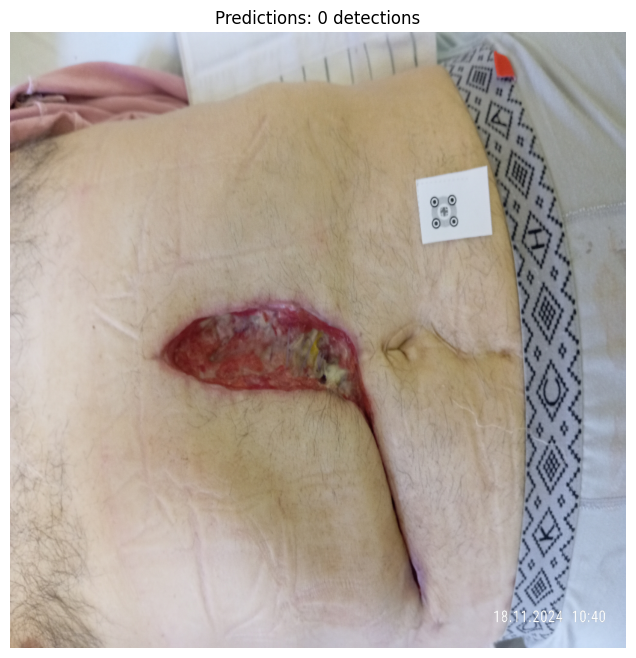


✓ Result saved: ..\results\task_0_image_001_result.json


In [9]:
# ============================================================================
# Load Model and Predict
# ============================================================================

# Load better checkpoint (epoch 15 has better results than best_model.pth)
# best_model.pth is from epoch 7, but epoch 11 had the best val_loss (3.1325)
model_path = Path(CONFIG['checkpoints_dir']) / 'checkpoint_epoch_15.pth'

if model_path.exists():
    print(f"Loading model from: {model_path}")
    checkpoint = torch.load(model_path, map_location=CONFIG['device'], weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("✓ Model loaded successfully!")
    if 'epoch' in checkpoint:
        print(f"  - Epoch: {checkpoint['epoch']}")
else:
    print("⚠️ Model not found! Please train the model first (Part 6)")

# تغيير المسار إلى صورة تريد التنبؤ عليها
image_path = 'data/task_0/data/task_0_image_001.jpg'  # ⬅️ عدّل هذا المسار

# Lower confidence threshold for better recall (0.3 instead of 0.5)
CONF_THRESHOLD = 0.3

print("\n" + "=" * 60)
print("Wound Detection - Prediction")
print("=" * 60)
print(f"\nImage: {image_path}")
print(f"Confidence Threshold: {CONF_THRESHOLD}")

# Predict with lower threshold
print("\nPredicting...")
result, predictions = predict_image(image_path, model, CONFIG['device'], conf_threshold=CONF_THRESHOLD)

# Print result
print("\nResults:")
print("-" * 40)
print(f"Detections: {result['num_detections']}")
print(f"Wound Area: {result['wound_area_cm2']} cm²" if result['wound_area_cm2'] else "Wound Area: N/A")
print(f"Infection: {'YES' if result['has_infection'] else 'NO'} (confidence: {result['infection_confidence']:.2f})")
print("\nFindings:")
for finding, present in result['findings'].items():
    print(f"  {finding}: {'✓' if present else '✗'}")

# Visualize
print("\nVisualizing...")
visualize_prediction(image_path, predictions)

# Save result
output_dir = Path(CONFIG['results_dir'])
output_dir.mkdir(exist_ok=True)

result_file = output_dir / f"{Path(image_path).stem}_result.json"
with open(result_file, 'w') as f:
    json.dump(result, f, indent=2)
print(f"\n✓ Result saved: {result_file}")
